# TESS Atlas fit for TOI 281

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 281.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-281.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-281.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-281.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 281

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 281 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

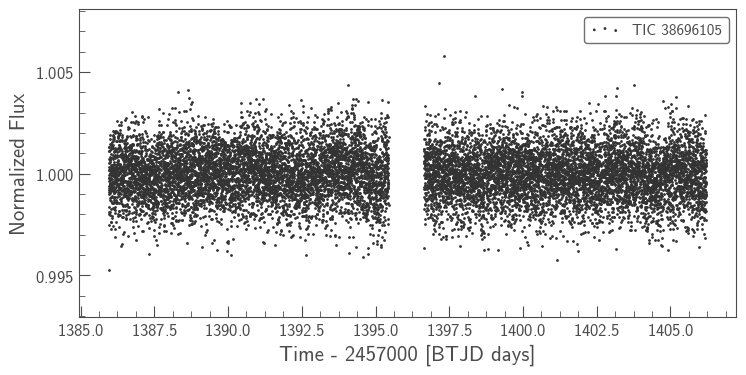

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -27411.627304172973 -> -27383.449702390113


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -22630.82995781599 -> -21605.913054907145


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -21605.913054907145 -> -21594.150697603345


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -21594.150697603345 -> -21594.145284885548


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -21594.145284885548 -> -21594.13180809042


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -21594.13180809042 -> -21594.13159271981


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -21594.13159271981 -> -21592.061726192933


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']
message: Optimization terminated successfully.
logp: -21592.061726192936 -> -21592.061726192875


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -21592.061726192875 -> -21592.06172619285


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -21592.06172619285 -> -21592.06172619285


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -21592.06172619285 -> -21592.06172619285


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -21592.06172619285 -> -21592.06172619285


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -21592.06172619285 -> -21592.06172619285


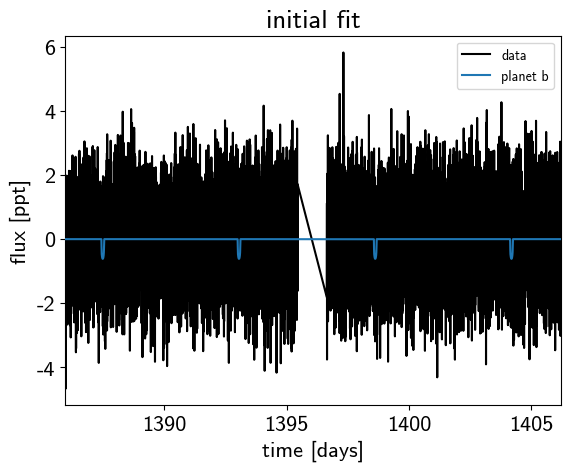

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   8%|▊         | 8/104 [00:00<00:07, 13.28draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:01<00:13,  6.86draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:16,  5.46draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:18,  4.90draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:19,  4.63draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:22,  3.88draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:21,  3.89draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:20,  3.95draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:16,  4.78draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:05<00:22,  3.60draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:19,  4.05draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:22,  3.49draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:19,  4.03draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:06<00:22,  3.33draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:22,  3.40draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:06<00:21,  3.45draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:21,  3.46draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:07<00:22,  3.13draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:07<00:21,  3.19draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:08<00:20,  3.40draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:08<00:18,  3.70draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:09<00:18,  3.55draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:09<00:19,  3.41draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:09<00:16,  3.81draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:09<00:19,  3.20draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:10<00:15,  3.92draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:10<00:18,  3.32draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:10<00:14,  4.02draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:11<00:18,  3.25draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:11<00:17,  3.37draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:11<00:17,  3.22draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:12<00:18,  3.09draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:12<00:15,  3.49draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:12<00:18,  2.86draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:13<00:17,  3.04draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:13<00:15,  3.25draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:14<00:14,  3.36draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:14<00:11,  4.19draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:14<00:13,  3.40draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:15<00:12,  3.53draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:15<00:12,  3.65draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:15<00:13,  3.09draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:16<00:13,  3.15draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:16<00:11,  3.28draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:17<00:09,  3.97draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:17<00:10,  3.50draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:17<00:09,  3.85draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:17<00:09,  3.70draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:18<00:08,  3.93draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:18<00:08,  3.94draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:18<00:07,  4.05draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:18<00:07,  4.05draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:19<00:08,  3.66draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:19<00:08,  3.43draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:19<00:07,  3.88draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:20<00:07,  3.45draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:20<00:07,  3.50draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:20<00:06,  3.59draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:21<00:07,  3.16draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:21<00:06,  3.35draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:21<00:05,  3.85draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:22<00:05,  3.48draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:22<00:05,  3.78draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:22<00:05,  3.51draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:22<00:04,  4.12draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:23<00:05,  3.02draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:24<00:04,  2.96draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:24<00:03,  3.18draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:24<00:02,  3.87draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:25<00:03,  3.23draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:25<00:02,  3.74draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:25<00:02,  3.45draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:25<00:01,  3.87draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:26<00:01,  3.55draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:26<00:01,  3.81draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:26<00:01,  2.96draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:27<00:01,  2.32draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:28<00:00,  2.18draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:30<00:00,  1.54draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   8%|▊         | 8/104 [00:00<00:01, 67.44draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:09,  9.35draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:13,  6.90draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:15,  5.75draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:17,  4.86draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:02<00:16,  5.37draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:20,  4.05draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:21,  3.87draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:20,  4.09draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:03<00:22,  3.59draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:18,  4.34draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:04<00:21,  3.79draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:18,  4.29draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:04<00:20,  3.78draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:19,  3.92draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:05<00:19,  3.91draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:05<00:17,  4.30draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:05<00:18,  4.02draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:21,  3.44draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:06<00:19,  3.65draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:06<00:22,  3.15draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:07<00:20,  3.33draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:07<00:17,  3.91draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:07<00:18,  3.60draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:08<00:17,  3.73draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:08<00:18,  3.46draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:08<00:17,  3.68draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:09<00:18,  3.49draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:09<00:16,  3.77draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:09<00:14,  4.13draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:09<00:14,  4.14draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:09<00:14,  3.95draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:10<00:15,  3.86draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:10<00:13,  4.09draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:10<00:10,  5.17draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:11<00:13,  4.00draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:11<00:11,  4.68draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:11<00:14,  3.69draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:11<00:11,  4.29draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:12<00:12,  3.99draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:12<00:11,  4.06draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:12<00:12,  3.66draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:12<00:10,  4.19draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:13<00:10,  4.02draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:13<00:10,  3.96draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:14<00:10,  3.76draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:15<00:10,  3.79draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:15<00:09,  4.08draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:15<00:10,  3.55draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:15<00:09,  3.82draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:16<00:09,  3.49draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:16<00:09,  3.58draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:16<00:08,  3.59draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:17<00:09,  3.28draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:17<00:07,  4.02draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:17<00:08,  3.49draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:17<00:07,  3.98draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:18<00:07,  3.49draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:18<00:07,  3.54draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:18<00:06,  3.83draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:19<00:07,  3.08draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:19<00:07,  3.13draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:20<00:06,  3.28draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:20<00:05,  3.47draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:21<00:04,  3.59draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:21<00:03,  3.81draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:21<00:03,  3.59draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:22<00:03,  3.33draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:22<00:03,  3.88draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:22<00:03,  3.02draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:23<00:02,  3.24draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:23<00:02,  3.58draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:23<00:02,  3.50draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:24<00:01,  3.58draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:24<00:01,  3.53draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:24<00:01,  3.65draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:25<00:01,  2.94draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:25<00:00,  2.55draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:26<00:00,  1.91draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:27<00:00,  1.42draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<00:37,  5.40draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<00:35,  5.60draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:00<00:32,  6.09draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:01<00:35,  5.51draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:01<00:41,  4.77draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:01<00:37,  5.26draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:02<00:42,  4.50draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:02<00:45,  4.20draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:02<00:38,  4.92draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:02<00:33,  5.71draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:03<00:30,  6.06draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:03<00:26,  7.08draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:03<00:32,  5.71draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:04<00:39,  4.62draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:04<00:34,  5.27draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:04<00:30,  5.85draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:04<00:34,  5.13draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:04<00:31,  5.65draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:05<00:30,  5.75draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:05<00:29,  5.86draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:05<00:28,  5.97draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:05<00:28,  6.14draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:06<00:28,  5.88draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:06<00:30,  5.62draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:06<00:35,  4.75draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:07<00:50,  3.31draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:07<00:39,  4.22draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:07<00:42,  3.86draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:08<00:41,  3.84draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:08<00:39,  4.09draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:08<00:34,  4.64draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:09<00:47,  3.34draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:09<00:37,  4.15draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:09<00:43,  3.58draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:09<00:35,  4.31draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:10<00:33,  4.62draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:10<00:30,  4.99draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:10<00:25,  5.77draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:11<00:39,  3.78draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:11<00:34,  4.29draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:12<00:32,  4.39draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:12<00:26,  5.38draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:12<00:36,  3.86draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:12<00:36,  3.79draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:13<00:28,  4.81draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:13<00:27,  4.85draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:13<00:26,  5.03draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:14<00:20,  6.28draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:14<00:20,  6.49draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:14<00:23,  5.35draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:14<00:20,  6.25draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:15<00:16,  7.65draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:15<00:19,  6.37draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:15<00:22,  5.43draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:16<00:19,  5.96draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:16<00:19,  6.18draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:16<00:25,  4.57draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:16<00:21,  5.42draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:17<00:32,  3.50draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:17<00:29,  3.78draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:17<00:24,  4.50draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:17<00:19,  5.77draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:18<00:28,  3.81draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:18<00:23,  4.67draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:18<00:21,  5.04draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:18<00:20,  5.23draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:19<00:21,  4.89draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:19<00:17,  5.83draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:19<00:20,  4.84draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:20<00:22,  4.39draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:20<00:22,  4.50draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:20<00:20,  4.80draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:20<00:17,  5.42draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:20<00:16,  5.99draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:20<00:18,  5.15draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:21<00:19,  4.87draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:21<00:20,  4.51draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:21<00:15,  5.71draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:21<00:14,  6.05draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:22<00:18,  4.79draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:22<00:15,  5.40draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:22<00:20,  4.19draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:23<00:18,  4.61draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:23<00:15,  5.35draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:23<00:15,  5.21draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:23<00:14,  5.33draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:24<00:12,  6.06draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:24<00:21,  3.65draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:25<00:20,  3.68draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:25<00:18,  3.95draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:25<00:16,  4.36draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:25<00:15,  4.70draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:26<00:17,  3.91draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:26<00:16,  4.26draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:26<00:16,  4.06draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:26<00:16,  4.03draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:27<00:15,  4.08draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:27<00:12,  5.01draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:27<00:11,  5.24draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:28<00:10,  5.56draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:28<00:11,  4.99draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:28<00:12,  4.78draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:28<00:10,  5.47draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:29<00:09,  5.57draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:29<00:09,  5.47draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:29<00:10,  5.14draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:29<00:10,  4.75draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:29<00:09,  5.52draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:30<00:11,  4.25draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:30<00:08,  5.46draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:30<00:10,  4.40draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:31<00:09,  4.52draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:31<00:07,  5.55draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:31<00:09,  4.38draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:31<00:07,  5.49draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:31<00:05,  6.54draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:32<00:07,  4.73draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:32<00:05,  5.77draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:32<00:06,  5.14draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:32<00:04,  6.77draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:33<00:04,  5.64draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [00:33<00:05,  4.82draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [00:34<00:05,  4.48draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:34<00:05,  4.30draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:35<00:04,  5.06draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:35<00:03,  5.33draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:35<00:03,  5.60draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:35<00:02,  6.02draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:36<00:03,  4.37draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:36<00:02,  4.85draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:36<00:01,  5.76draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:37<00:01,  5.03draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:37<00:01,  4.58draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:38<00:00,  5.07draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:38<00:00,  5.20draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:38<00:00,  4.74draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:38<00:00,  4.54draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:39<00:00,  3.61draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:39<00:00,  4.29draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:14, 27.41draws/s]

Sampling 2 chains:   2%|▏         | 9/404 [00:00<00:16, 23.62draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:00<00:17, 22.53draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:00<00:19, 19.62draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:00<00:22, 17.05draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:00<00:24, 15.66draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:01<00:21, 17.47draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:01<00:21, 18.05draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:01<00:24, 15.27draws/s]

Sampling 2 chains:   7%|▋         | 30/404 [00:01<00:23, 15.64draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:01<00:30, 12.23draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:02<00:27, 13.23draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:02<00:30, 12.22draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:02<00:29, 12.50draws/s]

Sampling 2 chains:  10%|▉         | 40/404 [00:02<00:27, 13.36draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:02<00:25, 14.03draws/s]

Sampling 2 chains:  11%|█         | 44/404 [00:02<00:24, 14.55draws/s]

Sampling 2 chains:  11%|█▏        | 46/404 [00:02<00:24, 14.76draws/s]

Sampling 2 chains:  12%|█▏        | 50/404 [00:03<00:20, 17.30draws/s]

Sampling 2 chains:  13%|█▎        | 54/404 [00:03<00:17, 20.43draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:03<00:16, 21.57draws/s]

Sampling 2 chains:  15%|█▌        | 61/404 [00:03<00:13, 24.81draws/s]

Sampling 2 chains:  16%|█▌        | 64/404 [00:03<00:13, 24.79draws/s]

Sampling 2 chains:  17%|█▋        | 67/404 [00:03<00:14, 23.95draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:03<00:11, 27.81draws/s]

Sampling 2 chains:  19%|█▉        | 76/404 [00:03<00:11, 28.14draws/s]

Sampling 2 chains:  20%|██        | 82/404 [00:03<00:09, 32.66draws/s]

Sampling 2 chains:  22%|██▏       | 88/404 [00:04<00:08, 37.73draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:04<00:12, 25.44draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:04<00:17, 17.56draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:04<00:17, 17.43draws/s]

Sampling 2 chains:  25%|██▌       | 103/404 [00:05<00:17, 17.18draws/s]

Sampling 2 chains:  26%|██▌       | 106/404 [00:05<00:24, 12.10draws/s]

Sampling 2 chains:  27%|██▋       | 108/404 [00:05<00:28, 10.45draws/s]

Sampling 2 chains:  27%|██▋       | 110/404 [00:06<00:26, 11.08draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:06<00:29,  9.84draws/s]

Sampling 2 chains:  28%|██▊       | 114/404 [00:06<00:26, 10.93draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:06<00:21, 13.23draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:06<00:26, 10.86draws/s]

Sampling 2 chains:  30%|███       | 122/404 [00:06<00:23, 12.24draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:07<00:19, 14.14draws/s]

Sampling 2 chains:  31%|███▏      | 127/404 [00:07<00:17, 15.45draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:07<00:15, 18.05draws/s]

Sampling 2 chains:  33%|███▎      | 133/404 [00:07<00:15, 17.26draws/s]

Sampling 2 chains:  33%|███▎      | 135/404 [00:07<00:15, 17.83draws/s]

Sampling 2 chains:  34%|███▍      | 137/404 [00:07<00:14, 17.97draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:07<00:17, 15.23draws/s]

Sampling 2 chains:  35%|███▍      | 141/404 [00:08<00:21, 12.03draws/s]

Sampling 2 chains:  35%|███▌      | 143/404 [00:08<00:19, 13.10draws/s]

Sampling 2 chains:  36%|███▌      | 145/404 [00:08<00:19, 13.55draws/s]

Sampling 2 chains:  36%|███▋      | 147/404 [00:08<00:24, 10.32draws/s]

Sampling 2 chains:  37%|███▋      | 149/404 [00:08<00:22, 11.55draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:08<00:20, 12.26draws/s]

Sampling 2 chains:  38%|███▊      | 153/404 [00:09<00:20, 12.35draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:09<00:18, 13.13draws/s]

Sampling 2 chains:  39%|███▉      | 157/404 [00:09<00:19, 12.36draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:09<00:28,  8.63draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:09<00:25,  9.59draws/s]

Sampling 2 chains:  40%|████      | 163/404 [00:10<00:27,  8.62draws/s]

Sampling 2 chains:  41%|████      | 165/404 [00:10<00:25,  9.24draws/s]

Sampling 2 chains:  41%|████▏     | 167/404 [00:10<00:23,  9.98draws/s]

Sampling 2 chains:  42%|████▏     | 169/404 [00:10<00:30,  7.75draws/s]

Sampling 2 chains:  42%|████▏     | 170/404 [00:11<00:29,  7.94draws/s]

Sampling 2 chains:  42%|████▏     | 171/404 [00:11<00:31,  7.39draws/s]

Sampling 2 chains:  43%|████▎     | 172/404 [00:11<00:52,  4.42draws/s]

Sampling 2 chains:  43%|████▎     | 173/404 [00:11<00:46,  4.99draws/s]

Sampling 2 chains:  43%|████▎     | 174/404 [00:12<01:04,  3.57draws/s]

Sampling 2 chains:  43%|████▎     | 175/404 [00:12<00:51,  4.42draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [00:12<00:44,  5.13draws/s]

Sampling 2 chains:  44%|████▍     | 177/404 [00:12<00:39,  5.71draws/s]

Sampling 2 chains:  44%|████▍     | 178/404 [00:12<00:43,  5.21draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [00:13<00:35,  6.38draws/s]

Sampling 2 chains:  45%|████▍     | 181/404 [00:13<00:33,  6.72draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:13<00:31,  6.97draws/s]

Sampling 2 chains:  45%|████▌     | 183/404 [00:13<00:31,  6.92draws/s]

Sampling 2 chains:  46%|████▌     | 184/404 [00:13<00:31,  6.99draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:13<00:24,  8.81draws/s]

Sampling 2 chains:  47%|████▋     | 189/404 [00:13<00:21, 10.16draws/s]

Sampling 2 chains:  47%|████▋     | 191/404 [00:13<00:18, 11.55draws/s]

Sampling 2 chains:  48%|████▊     | 193/404 [00:14<00:19, 11.05draws/s]

Sampling 2 chains:  49%|████▊     | 196/404 [00:14<00:16, 12.93draws/s]

Sampling 2 chains:  49%|████▉     | 199/404 [00:14<00:22,  9.02draws/s]

Sampling 2 chains:  50%|████▉     | 201/404 [00:15<00:23,  8.66draws/s]

Sampling 2 chains:  50%|█████     | 203/404 [00:15<00:32,  6.24draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:15<00:30,  6.58draws/s]

Sampling 2 chains:  51%|█████     | 206/404 [00:16<00:31,  6.34draws/s]

Sampling 2 chains:  51%|█████     | 207/404 [00:16<00:30,  6.39draws/s]

Sampling 2 chains:  52%|█████▏    | 209/404 [00:16<00:26,  7.39draws/s]

Sampling 2 chains:  52%|█████▏    | 210/404 [00:16<00:25,  7.48draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [00:16<00:24,  7.72draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:16<00:20,  9.42draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [00:16<00:18, 10.19draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:17<00:17, 10.41draws/s]

Sampling 2 chains:  54%|█████▍    | 219/404 [00:17<00:15, 11.67draws/s]

Sampling 2 chains:  55%|█████▌    | 223/404 [00:17<00:12, 14.67draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [00:17<00:11, 14.85draws/s]

Sampling 2 chains:  57%|█████▋    | 229/404 [00:17<00:12, 13.69draws/s]

Sampling 2 chains:  57%|█████▋    | 231/404 [00:17<00:13, 12.97draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:18<00:13, 12.43draws/s]

Sampling 2 chains:  58%|█████▊    | 235/404 [00:18<00:12, 13.18draws/s]

Sampling 2 chains:  59%|█████▉    | 238/404 [00:18<00:11, 14.20draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:18<00:12, 13.24draws/s]

Sampling 2 chains:  60%|█████▉    | 242/404 [00:18<00:12, 12.71draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:18<00:11, 14.19draws/s]

Sampling 2 chains:  61%|██████    | 247/404 [00:19<00:12, 13.05draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:19<00:12, 12.47draws/s]

Sampling 2 chains:  62%|██████▏   | 251/404 [00:19<00:12, 12.43draws/s]

Sampling 2 chains:  63%|██████▎   | 254/404 [00:19<00:10, 13.84draws/s]

Sampling 2 chains:  63%|██████▎   | 256/404 [00:19<00:10, 13.54draws/s]

Sampling 2 chains:  64%|██████▍   | 258/404 [00:19<00:11, 13.09draws/s]

Sampling 2 chains:  64%|██████▍   | 260/404 [00:20<00:11, 12.63draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [00:20<00:11, 12.33draws/s]

Sampling 2 chains:  65%|██████▌   | 264/404 [00:20<00:11, 12.48draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [00:20<00:10, 13.25draws/s]

Sampling 2 chains:  67%|██████▋   | 269/404 [00:20<00:08, 15.02draws/s]

Sampling 2 chains:  67%|██████▋   | 271/404 [00:20<00:08, 14.82draws/s]

Sampling 2 chains:  68%|██████▊   | 273/404 [00:20<00:08, 15.25draws/s]

Sampling 2 chains:  68%|██████▊   | 275/404 [00:21<00:08, 15.36draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:21<00:15,  8.32draws/s]

Sampling 2 chains:  69%|██████▉   | 279/404 [00:22<00:28,  4.41draws/s]

Sampling 2 chains:  69%|██████▉   | 280/404 [00:22<00:36,  3.36draws/s]

Sampling 2 chains:  70%|██████▉   | 281/404 [00:23<00:44,  2.79draws/s]

Sampling 2 chains:  70%|██████▉   | 282/404 [00:23<00:36,  3.34draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [00:24<00:39,  3.03draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:24<00:44,  2.70draws/s]

Sampling 2 chains:  71%|███████   | 285/404 [00:24<00:39,  3.00draws/s]

Sampling 2 chains:  71%|███████   | 286/404 [00:24<00:32,  3.64draws/s]

Sampling 2 chains:  71%|███████   | 287/404 [00:25<00:30,  3.83draws/s]

Sampling 2 chains:  71%|███████▏  | 288/404 [00:25<00:29,  3.90draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [00:25<00:24,  4.62draws/s]

Sampling 2 chains:  72%|███████▏  | 290/404 [00:25<00:21,  5.35draws/s]

Sampling 2 chains:  72%|███████▏  | 291/404 [00:25<00:18,  6.06draws/s]

Sampling 2 chains:  72%|███████▏  | 292/404 [00:25<00:20,  5.42draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:26<00:21,  5.10draws/s]

Sampling 2 chains:  73%|███████▎  | 294/404 [00:26<00:18,  5.83draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [00:26<00:16,  6.47draws/s]

Sampling 2 chains:  73%|███████▎  | 296/404 [00:26<00:15,  6.85draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [00:26<00:15,  6.84draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [00:26<00:15,  6.86draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:27<00:13,  7.54draws/s]

Sampling 2 chains:  75%|███████▍  | 302/404 [00:27<00:12,  7.89draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [00:27<00:13,  7.71draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [00:27<00:13,  7.24draws/s]

Sampling 2 chains:  75%|███████▌  | 305/404 [00:27<00:13,  7.49draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:27<00:10,  9.03draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [00:27<00:10,  9.48draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [00:28<00:08, 11.00draws/s]

Sampling 2 chains:  78%|███████▊  | 314/404 [00:28<00:07, 11.51draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [00:28<00:09,  9.43draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:28<00:09,  8.73draws/s]

Sampling 2 chains:  79%|███████▉  | 319/404 [00:29<00:09,  8.68draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [00:29<00:09,  8.64draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [00:29<00:08, 10.11draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [00:29<00:06, 11.46draws/s]

Sampling 2 chains:  81%|████████  | 327/404 [00:29<00:05, 13.10draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [00:29<00:06, 12.44draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [00:29<00:05, 13.51draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [00:29<00:04, 14.46draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [00:30<00:04, 15.84draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [00:30<00:04, 16.23draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [00:30<00:03, 16.98draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [00:30<00:04, 15.14draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [00:30<00:03, 15.48draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [00:30<00:03, 16.00draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [00:30<00:03, 17.60draws/s]

Sampling 2 chains:  87%|████████▋ | 351/404 [00:31<00:03, 14.77draws/s]

Sampling 2 chains:  87%|████████▋ | 353/404 [00:31<00:03, 16.00draws/s]

Sampling 2 chains:  88%|████████▊ | 355/404 [00:31<00:03, 16.14draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [00:31<00:02, 16.15draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [00:31<00:02, 15.42draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [00:31<00:02, 14.73draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:32<00:03, 10.96draws/s]

Sampling 2 chains:  91%|█████████ | 366/404 [00:32<00:03,  9.93draws/s]

Sampling 2 chains:  91%|█████████ | 368/404 [00:32<00:03,  9.43draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [00:32<00:03, 10.87draws/s]

Sampling 2 chains:  92%|█████████▏| 372/404 [00:32<00:02, 12.09draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [00:32<00:02, 12.88draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [00:33<00:02, 12.56draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [00:33<00:01, 13.64draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [00:33<00:01, 14.52draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [00:33<00:01, 14.62draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [00:33<00:01, 11.42draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:33<00:01,  9.79draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:34<00:01, 10.12draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [00:34<00:01, 10.35draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [00:34<00:01, 10.51draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [00:34<00:01,  9.24draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [00:34<00:01,  8.95draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [00:35<00:00,  8.96draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [00:35<00:00,  8.86draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [00:35<00:00,  8.81draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [00:35<00:00,  8.74draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [00:35<00:00,  8.33draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [00:35<00:00,  7.85draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [00:35<00:00,  8.05draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:35<00:00,  9.04draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/804 [00:00<00:20, 39.81draws/s]

Sampling 2 chains:   1%|          | 8/804 [00:00<00:27, 29.00draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:00<00:36, 21.92draws/s]

Sampling 2 chains:   2%|▏         | 13/804 [00:00<00:39, 20.27draws/s]

Sampling 2 chains:   2%|▏         | 15/804 [00:00<00:48, 16.35draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:00<00:48, 16.34draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:01<00:47, 16.46draws/s]

Sampling 2 chains:   3%|▎         | 21/804 [00:01<00:45, 17.11draws/s]

Sampling 2 chains:   3%|▎         | 23/804 [00:01<00:57, 13.52draws/s]

Sampling 2 chains:   3%|▎         | 25/804 [00:01<00:54, 14.33draws/s]

Sampling 2 chains:   3%|▎         | 27/804 [00:01<01:07, 11.52draws/s]

Sampling 2 chains:   4%|▎         | 29/804 [00:02<01:16, 10.18draws/s]

Sampling 2 chains:   4%|▍         | 32/804 [00:02<01:06, 11.58draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:02<01:15, 10.18draws/s]

Sampling 2 chains:   5%|▍         | 37/804 [00:02<01:07, 11.44draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:02<01:07, 11.29draws/s]

Sampling 2 chains:   5%|▌         | 41/804 [00:03<01:22,  9.28draws/s]

Sampling 2 chains:   5%|▌         | 43/804 [00:03<01:53,  6.73draws/s]

Sampling 2 chains:   5%|▌         | 44/804 [00:04<02:50,  4.45draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:04<02:23,  5.29draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:04<03:13,  3.91draws/s]

Sampling 2 chains:   6%|▌         | 48/804 [00:04<03:01,  4.16draws/s]

Sampling 2 chains:   6%|▌         | 50/804 [00:05<02:42,  4.63draws/s]

Sampling 2 chains:   6%|▋         | 51/804 [00:05<02:48,  4.47draws/s]

Sampling 2 chains:   6%|▋         | 52/804 [00:05<02:53,  4.33draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:06<02:59,  4.19draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:06<02:31,  4.94draws/s]

Sampling 2 chains:   7%|▋         | 57/804 [00:06<02:00,  6.18draws/s]

Sampling 2 chains:   7%|▋         | 58/804 [00:06<01:52,  6.63draws/s]

Sampling 2 chains:   7%|▋         | 60/804 [00:06<01:32,  8.01draws/s]

Sampling 2 chains:   8%|▊         | 62/804 [00:06<01:18,  9.42draws/s]

Sampling 2 chains:   8%|▊         | 64/804 [00:06<01:06, 11.15draws/s]

Sampling 2 chains:   8%|▊         | 66/804 [00:07<01:05, 11.23draws/s]

Sampling 2 chains:   8%|▊         | 68/804 [00:07<01:12, 10.14draws/s]

Sampling 2 chains:   9%|▊         | 70/804 [00:07<01:02, 11.74draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:07<01:12, 10.08draws/s]

Sampling 2 chains:   9%|▉         | 74/804 [00:07<01:06, 10.93draws/s]

Sampling 2 chains:   9%|▉         | 76/804 [00:08<01:09, 10.54draws/s]

Sampling 2 chains:  10%|▉         | 80/804 [00:08<00:53, 13.47draws/s]

Sampling 2 chains:  10%|█         | 82/804 [00:08<00:58, 12.41draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:08<00:58, 12.36draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:08<00:52, 13.78draws/s]

Sampling 2 chains:  11%|█         | 90/804 [00:08<00:45, 15.53draws/s]

Sampling 2 chains:  11%|█▏        | 92/804 [00:08<00:43, 16.54draws/s]

Sampling 2 chains:  12%|█▏        | 94/804 [00:08<00:44, 16.01draws/s]

Sampling 2 chains:  12%|█▏        | 96/804 [00:09<00:49, 14.36draws/s]

Sampling 2 chains:  12%|█▏        | 98/804 [00:09<00:48, 14.43draws/s]

Sampling 2 chains:  12%|█▏        | 100/804 [00:09<00:52, 13.37draws/s]

Sampling 2 chains:  13%|█▎        | 102/804 [00:09<00:55, 12.73draws/s]

Sampling 2 chains:  13%|█▎        | 104/804 [00:09<00:55, 12.64draws/s]

Sampling 2 chains:  13%|█▎        | 107/804 [00:09<00:47, 14.76draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:10<00:39, 17.69draws/s]

Sampling 2 chains:  14%|█▍        | 115/804 [00:10<00:33, 20.41draws/s]

Sampling 2 chains:  15%|█▍        | 118/804 [00:10<00:30, 22.51draws/s]

Sampling 2 chains:  15%|█▌        | 122/804 [00:10<00:27, 24.62draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:10<00:43, 15.62draws/s]

Sampling 2 chains:  16%|█▌        | 128/804 [00:11<00:54, 12.39draws/s]

Sampling 2 chains:  16%|█▌        | 130/804 [00:11<00:56, 11.99draws/s]

Sampling 2 chains:  16%|█▋        | 132/804 [00:11<00:56, 11.82draws/s]

Sampling 2 chains:  17%|█▋        | 135/804 [00:11<00:48, 13.69draws/s]

Sampling 2 chains:  17%|█▋        | 137/804 [00:11<00:52, 12.73draws/s]

Sampling 2 chains:  17%|█▋        | 139/804 [00:12<00:58, 11.31draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:12<00:49, 13.42draws/s]

Sampling 2 chains:  18%|█▊        | 144/804 [00:12<00:47, 13.96draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:12<00:46, 14.29draws/s]

Sampling 2 chains:  19%|█▊        | 149/804 [00:12<00:39, 16.65draws/s]

Sampling 2 chains:  19%|█▉        | 152/804 [00:12<00:34, 18.92draws/s]

Sampling 2 chains:  19%|█▉        | 156/804 [00:12<00:30, 21.48draws/s]

Sampling 2 chains:  20%|█▉        | 159/804 [00:12<00:28, 22.74draws/s]

Sampling 2 chains:  20%|██        | 162/804 [00:12<00:27, 23.52draws/s]

Sampling 2 chains:  21%|██        | 165/804 [00:13<00:30, 21.19draws/s]

Sampling 2 chains:  21%|██        | 168/804 [00:13<00:30, 21.04draws/s]

Sampling 2 chains:  21%|██▏       | 172/804 [00:13<00:27, 22.85draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:13<00:30, 20.48draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [00:13<00:30, 20.84draws/s]

Sampling 2 chains:  23%|██▎       | 181/804 [00:13<00:28, 21.89draws/s]

Sampling 2 chains:  23%|██▎       | 184/804 [00:14<00:29, 20.68draws/s]

Sampling 2 chains:  23%|██▎       | 187/804 [00:14<00:27, 22.40draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:14<00:31, 19.37draws/s]

Sampling 2 chains:  24%|██▍       | 193/804 [00:14<00:29, 20.77draws/s]

Sampling 2 chains:  24%|██▍       | 196/804 [00:14<00:30, 19.89draws/s]

Sampling 2 chains:  25%|██▍       | 199/804 [00:14<00:30, 19.75draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [00:15<00:34, 17.50draws/s]

Sampling 2 chains:  25%|██▌       | 204/804 [00:15<00:34, 17.23draws/s]

Sampling 2 chains:  26%|██▌       | 207/804 [00:15<00:31, 19.01draws/s]

Sampling 2 chains:  26%|██▌       | 211/804 [00:15<00:27, 21.95draws/s]

Sampling 2 chains:  27%|██▋       | 214/804 [00:15<00:26, 22.66draws/s]

Sampling 2 chains:  27%|██▋       | 217/804 [00:15<00:29, 20.24draws/s]

Sampling 2 chains:  27%|██▋       | 220/804 [00:15<00:30, 18.98draws/s]

Sampling 2 chains:  28%|██▊       | 223/804 [00:16<00:35, 16.34draws/s]

Sampling 2 chains:  28%|██▊       | 227/804 [00:16<00:31, 18.57draws/s]

Sampling 2 chains:  29%|██▊       | 230/804 [00:16<00:28, 20.36draws/s]

Sampling 2 chains:  29%|██▉       | 233/804 [00:16<00:35, 16.01draws/s]

Sampling 2 chains:  29%|██▉       | 235/804 [00:16<00:34, 16.32draws/s]

Sampling 2 chains:  29%|██▉       | 237/804 [00:16<00:33, 16.76draws/s]

Sampling 2 chains:  30%|██▉       | 241/804 [00:17<00:30, 18.75draws/s]

Sampling 2 chains:  30%|███       | 245/804 [00:17<00:26, 21.49draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:17<00:27, 20.53draws/s]

Sampling 2 chains:  31%|███       | 251/804 [00:17<00:28, 19.09draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [00:17<00:26, 21.00draws/s]

Sampling 2 chains:  32%|███▏      | 257/804 [00:17<00:24, 22.28draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:17<00:23, 23.37draws/s]

Sampling 2 chains:  33%|███▎      | 263/804 [00:17<00:22, 24.14draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [00:18<00:24, 21.77draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [00:18<00:30, 17.50draws/s]

Sampling 2 chains:  34%|███▎      | 271/804 [00:18<00:33, 15.97draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [00:18<00:32, 16.23draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [00:18<00:32, 16.50draws/s]

Sampling 2 chains:  35%|███▍      | 278/804 [00:18<00:32, 16.10draws/s]

Sampling 2 chains:  35%|███▍      | 281/804 [00:19<00:30, 17.16draws/s]

Sampling 2 chains:  35%|███▌      | 283/804 [00:19<00:30, 16.83draws/s]

Sampling 2 chains:  35%|███▌      | 285/804 [00:19<00:30, 16.81draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:19<00:31, 16.22draws/s]

Sampling 2 chains:  36%|███▌      | 289/804 [00:19<00:31, 16.53draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [00:19<00:28, 18.05draws/s]

Sampling 2 chains:  37%|███▋      | 294/804 [00:19<00:29, 17.58draws/s]

Sampling 2 chains:  37%|███▋      | 297/804 [00:19<00:26, 19.33draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:20<00:26, 19.05draws/s]

Sampling 2 chains:  38%|███▊      | 302/804 [00:20<00:28, 17.82draws/s]

Sampling 2 chains:  38%|███▊      | 304/804 [00:20<00:27, 18.13draws/s]

Sampling 2 chains:  38%|███▊      | 307/804 [00:20<00:26, 18.64draws/s]

Sampling 2 chains:  39%|███▊      | 310/804 [00:20<00:25, 19.73draws/s]

Sampling 2 chains:  39%|███▉      | 313/804 [00:20<00:26, 18.43draws/s]

Sampling 2 chains:  39%|███▉      | 317/804 [00:20<00:23, 20.99draws/s]

Sampling 2 chains:  40%|███▉      | 321/804 [00:21<00:21, 22.26draws/s]

Sampling 2 chains:  40%|████      | 324/804 [00:21<00:22, 21.66draws/s]

Sampling 2 chains:  41%|████      | 327/804 [00:21<00:21, 22.30draws/s]

Sampling 2 chains:  41%|████      | 331/804 [00:21<00:20, 23.59draws/s]

Sampling 2 chains:  42%|████▏     | 334/804 [00:21<00:22, 20.83draws/s]

Sampling 2 chains:  42%|████▏     | 337/804 [00:21<00:21, 22.17draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [00:21<00:20, 22.75draws/s]

Sampling 2 chains:  43%|████▎     | 343/804 [00:22<00:23, 19.82draws/s]

Sampling 2 chains:  43%|████▎     | 346/804 [00:22<00:25, 17.85draws/s]

Sampling 2 chains:  44%|████▎     | 350/804 [00:22<00:24, 18.48draws/s]

Sampling 2 chains:  44%|████▍     | 355/804 [00:22<00:21, 20.99draws/s]

Sampling 2 chains:  45%|████▍     | 358/804 [00:22<00:20, 22.17draws/s]

Sampling 2 chains:  45%|████▍     | 361/804 [00:23<00:21, 20.22draws/s]

Sampling 2 chains:  45%|████▌     | 364/804 [00:23<00:26, 16.76draws/s]

Sampling 2 chains:  46%|████▌     | 366/804 [00:23<00:26, 16.73draws/s]

Sampling 2 chains:  46%|████▌     | 368/804 [00:23<00:25, 16.83draws/s]

Sampling 2 chains:  46%|████▌     | 370/804 [00:23<00:28, 15.27draws/s]

Sampling 2 chains:  47%|████▋     | 374/804 [00:23<00:26, 16.45draws/s]

Sampling 2 chains:  47%|████▋     | 377/804 [00:24<00:25, 16.52draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [00:24<00:21, 19.27draws/s]

Sampling 2 chains:  48%|████▊     | 386/804 [00:24<00:19, 21.87draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [00:24<00:25, 16.12draws/s]

Sampling 2 chains:  49%|████▉     | 392/804 [00:24<00:28, 14.49draws/s]

Sampling 2 chains:  49%|████▉     | 394/804 [00:25<00:28, 14.37draws/s]

Sampling 2 chains:  49%|████▉     | 396/804 [00:25<00:26, 15.66draws/s]

Sampling 2 chains:  50%|████▉     | 398/804 [00:25<00:28, 14.34draws/s]

Sampling 2 chains:  50%|████▉     | 400/804 [00:25<00:30, 13.17draws/s]

Sampling 2 chains:  50%|█████     | 402/804 [00:25<00:29, 13.58draws/s]

Sampling 2 chains:  50%|█████     | 405/804 [00:25<00:25, 15.40draws/s]

Sampling 2 chains:  51%|█████     | 408/804 [00:25<00:23, 16.86draws/s]

Sampling 2 chains:  51%|█████     | 411/804 [00:26<00:21, 18.09draws/s]

Sampling 2 chains:  51%|█████▏    | 413/804 [00:26<00:23, 16.87draws/s]

Sampling 2 chains:  52%|█████▏    | 415/804 [00:26<00:30, 12.95draws/s]

Sampling 2 chains:  52%|█████▏    | 417/804 [00:26<00:31, 12.38draws/s]

Sampling 2 chains:  52%|█████▏    | 419/804 [00:26<00:28, 13.37draws/s]

Sampling 2 chains:  52%|█████▏    | 421/804 [00:26<00:26, 14.33draws/s]

Sampling 2 chains:  53%|█████▎    | 423/804 [00:26<00:25, 14.72draws/s]

Sampling 2 chains:  53%|█████▎    | 425/804 [00:27<00:31, 11.86draws/s]

Sampling 2 chains:  53%|█████▎    | 427/804 [00:27<00:32, 11.47draws/s]

Sampling 2 chains:  53%|█████▎    | 429/804 [00:27<00:40,  9.37draws/s]

Sampling 2 chains:  54%|█████▎    | 431/804 [00:27<00:37,  9.85draws/s]

Sampling 2 chains:  54%|█████▍    | 433/804 [00:28<00:37,  9.78draws/s]

Sampling 2 chains:  54%|█████▍    | 435/804 [00:28<00:37,  9.90draws/s]

Sampling 2 chains:  54%|█████▍    | 437/804 [00:28<00:32, 11.38draws/s]

Sampling 2 chains:  55%|█████▍    | 439/804 [00:28<00:36, 10.00draws/s]

Sampling 2 chains:  55%|█████▍    | 441/804 [00:28<00:32, 11.26draws/s]

Sampling 2 chains:  55%|█████▌    | 443/804 [00:28<00:29, 12.04draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [00:29<00:32, 11.15draws/s]

Sampling 2 chains:  56%|█████▌    | 448/804 [00:29<00:27, 13.10draws/s]

Sampling 2 chains:  56%|█████▌    | 450/804 [00:29<00:32, 11.02draws/s]

Sampling 2 chains:  56%|█████▌    | 452/804 [00:29<00:34, 10.07draws/s]

Sampling 2 chains:  56%|█████▋    | 454/804 [00:29<00:33, 10.46draws/s]

Sampling 2 chains:  57%|█████▋    | 458/804 [00:30<00:27, 12.74draws/s]

Sampling 2 chains:  57%|█████▋    | 460/804 [00:30<00:24, 13.76draws/s]

Sampling 2 chains:  57%|█████▋    | 462/804 [00:30<00:29, 11.55draws/s]

Sampling 2 chains:  58%|█████▊    | 464/804 [00:30<00:29, 11.48draws/s]

Sampling 2 chains:  58%|█████▊    | 466/804 [00:30<00:33, 10.24draws/s]

Sampling 2 chains:  58%|█████▊    | 469/804 [00:31<00:29, 11.47draws/s]

Sampling 2 chains:  59%|█████▊    | 471/804 [00:31<00:31, 10.45draws/s]

Sampling 2 chains:  59%|█████▉    | 473/804 [00:31<00:31, 10.53draws/s]

Sampling 2 chains:  59%|█████▉    | 475/804 [00:31<00:27, 11.75draws/s]

Sampling 2 chains:  59%|█████▉    | 477/804 [00:31<00:33,  9.83draws/s]

Sampling 2 chains:  60%|█████▉    | 479/804 [00:31<00:29, 10.93draws/s]

Sampling 2 chains:  60%|█████▉    | 481/804 [00:32<00:27, 11.81draws/s]

Sampling 2 chains:  60%|██████    | 483/804 [00:32<00:31, 10.06draws/s]

Sampling 2 chains:  60%|██████    | 485/804 [00:32<00:32,  9.93draws/s]

Sampling 2 chains:  61%|██████    | 487/804 [00:32<00:35,  9.04draws/s]

Sampling 2 chains:  61%|██████    | 489/804 [00:32<00:30, 10.30draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [00:33<00:30, 10.43draws/s]

Sampling 2 chains:  61%|██████▏   | 494/804 [00:33<00:27, 11.42draws/s]

Sampling 2 chains:  62%|██████▏   | 496/804 [00:33<00:24, 12.40draws/s]

Sampling 2 chains:  62%|██████▏   | 498/804 [00:33<00:25, 11.85draws/s]

Sampling 2 chains:  62%|██████▏   | 501/804 [00:33<00:23, 13.01draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [00:34<00:28, 10.57draws/s]

Sampling 2 chains:  63%|██████▎   | 505/804 [00:34<00:29, 10.11draws/s]

Sampling 2 chains:  63%|██████▎   | 507/804 [00:34<00:26, 11.40draws/s]

Sampling 2 chains:  63%|██████▎   | 510/804 [00:34<00:22, 13.34draws/s]

Sampling 2 chains:  64%|██████▎   | 512/804 [00:34<00:23, 12.59draws/s]

Sampling 2 chains:  64%|██████▍   | 514/804 [00:35<00:31,  9.13draws/s]

Sampling 2 chains:  64%|██████▍   | 516/804 [00:35<00:29,  9.65draws/s]

Sampling 2 chains:  64%|██████▍   | 518/804 [00:35<00:25, 11.14draws/s]

Sampling 2 chains:  65%|██████▍   | 520/804 [00:35<00:28,  9.79draws/s]

Sampling 2 chains:  65%|██████▌   | 523/804 [00:35<00:24, 11.64draws/s]

Sampling 2 chains:  65%|██████▌   | 526/804 [00:36<00:20, 13.46draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [00:36<00:20, 13.66draws/s]

Sampling 2 chains:  66%|██████▌   | 530/804 [00:36<00:19, 14.35draws/s]

Sampling 2 chains:  66%|██████▋   | 533/804 [00:36<00:16, 15.95draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [00:36<00:15, 17.25draws/s]

Sampling 2 chains:  67%|██████▋   | 538/804 [00:36<00:19, 13.97draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [00:36<00:18, 14.59draws/s]

Sampling 2 chains:  67%|██████▋   | 542/804 [00:36<00:17, 15.14draws/s]

Sampling 2 chains:  68%|██████▊   | 546/804 [00:37<00:15, 17.12draws/s]

Sampling 2 chains:  68%|██████▊   | 548/804 [00:37<00:15, 17.00draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [00:37<00:14, 17.14draws/s]

Sampling 2 chains:  69%|██████▊   | 552/804 [00:37<00:16, 14.90draws/s]

Sampling 2 chains:  69%|██████▉   | 554/804 [00:37<00:16, 15.40draws/s]

Sampling 2 chains:  69%|██████▉   | 557/804 [00:37<00:14, 17.34draws/s]

Sampling 2 chains:  70%|██████▉   | 561/804 [00:38<00:13, 17.66draws/s]

Sampling 2 chains:  70%|███████   | 563/804 [00:38<00:16, 14.58draws/s]

Sampling 2 chains:  70%|███████   | 565/804 [00:38<00:20, 11.64draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [00:38<00:17, 13.24draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [00:38<00:15, 15.32draws/s]

Sampling 2 chains:  71%|███████▏  | 573/804 [00:38<00:14, 15.83draws/s]

Sampling 2 chains:  72%|███████▏  | 575/804 [00:38<00:14, 16.26draws/s]

Sampling 2 chains:  72%|███████▏  | 577/804 [00:39<00:13, 16.55draws/s]

Sampling 2 chains:  72%|███████▏  | 579/804 [00:39<00:13, 17.10draws/s]

Sampling 2 chains:  72%|███████▏  | 582/804 [00:39<00:12, 18.13draws/s]

Sampling 2 chains:  73%|███████▎  | 584/804 [00:39<00:12, 17.49draws/s]

Sampling 2 chains:  73%|███████▎  | 586/804 [00:39<00:14, 15.33draws/s]

Sampling 2 chains:  73%|███████▎  | 590/804 [00:39<00:11, 18.11draws/s]

Sampling 2 chains:  74%|███████▍  | 593/804 [00:39<00:11, 19.02draws/s]

Sampling 2 chains:  74%|███████▍  | 596/804 [00:41<00:41,  5.05draws/s]

Sampling 2 chains:  74%|███████▍  | 598/804 [00:42<00:54,  3.77draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [00:43<01:03,  3.19draws/s]

Sampling 2 chains:  75%|███████▍  | 601/804 [00:43<01:07,  2.99draws/s]

Sampling 2 chains:  75%|███████▍  | 602/804 [00:43<00:59,  3.42draws/s]

Sampling 2 chains:  75%|███████▌  | 603/804 [00:44<01:18,  2.56draws/s]

Sampling 2 chains:  75%|███████▌  | 604/804 [00:44<01:14,  2.68draws/s]

Sampling 2 chains:  75%|███████▌  | 605/804 [00:44<01:02,  3.18draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [00:45<01:08,  2.88draws/s]

Sampling 2 chains:  75%|███████▌  | 607/804 [00:45<01:11,  2.76draws/s]

Sampling 2 chains:  76%|███████▌  | 608/804 [00:46<01:05,  3.00draws/s]

Sampling 2 chains:  76%|███████▌  | 609/804 [00:46<00:56,  3.43draws/s]

Sampling 2 chains:  76%|███████▌  | 611/804 [00:46<00:51,  3.73draws/s]

Sampling 2 chains:  76%|███████▌  | 612/804 [00:46<00:44,  4.33draws/s]

Sampling 2 chains:  76%|███████▌  | 613/804 [00:46<00:39,  4.86draws/s]

Sampling 2 chains:  76%|███████▋  | 615/804 [00:47<00:34,  5.48draws/s]

Sampling 2 chains:  77%|███████▋  | 616/804 [00:47<00:32,  5.79draws/s]

Sampling 2 chains:  77%|███████▋  | 617/804 [00:47<00:31,  5.98draws/s]

Sampling 2 chains:  77%|███████▋  | 619/804 [00:47<00:26,  7.10draws/s]

Sampling 2 chains:  77%|███████▋  | 621/804 [00:47<00:22,  8.00draws/s]

Sampling 2 chains:  77%|███████▋  | 623/804 [00:47<00:20,  8.81draws/s]

Sampling 2 chains:  78%|███████▊  | 625/804 [00:48<00:17, 10.27draws/s]

Sampling 2 chains:  78%|███████▊  | 627/804 [00:48<00:18,  9.65draws/s]

Sampling 2 chains:  78%|███████▊  | 629/804 [00:48<00:20,  8.55draws/s]

Sampling 2 chains:  78%|███████▊  | 630/804 [00:48<00:23,  7.38draws/s]

Sampling 2 chains:  78%|███████▊  | 631/804 [00:49<00:25,  6.70draws/s]

Sampling 2 chains:  79%|███████▊  | 633/804 [00:49<00:23,  7.23draws/s]

Sampling 2 chains:  79%|███████▉  | 634/804 [00:49<00:31,  5.37draws/s]

Sampling 2 chains:  79%|███████▉  | 635/804 [00:49<00:32,  5.26draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [00:49<00:33,  4.98draws/s]

Sampling 2 chains:  79%|███████▉  | 637/804 [00:50<00:34,  4.91draws/s]

Sampling 2 chains:  79%|███████▉  | 638/804 [00:50<00:34,  4.74draws/s]

Sampling 2 chains:  79%|███████▉  | 639/804 [00:50<00:35,  4.66draws/s]

Sampling 2 chains:  80%|███████▉  | 640/804 [00:50<00:36,  4.49draws/s]

Sampling 2 chains:  80%|███████▉  | 641/804 [00:51<00:37,  4.39draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [00:51<00:31,  5.10draws/s]

Sampling 2 chains:  80%|███████▉  | 643/804 [00:51<00:28,  5.73draws/s]

Sampling 2 chains:  80%|████████  | 644/804 [00:51<00:25,  6.24draws/s]

Sampling 2 chains:  80%|████████  | 645/804 [00:51<00:23,  6.75draws/s]

Sampling 2 chains:  80%|████████  | 646/804 [00:51<00:27,  5.72draws/s]

Sampling 2 chains:  80%|████████  | 647/804 [00:52<00:28,  5.49draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [00:52<00:28,  5.56draws/s]

Sampling 2 chains:  81%|████████  | 650/804 [00:52<00:22,  6.71draws/s]

Sampling 2 chains:  81%|████████  | 652/804 [00:52<00:19,  7.94draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [00:52<00:16,  8.89draws/s]

Sampling 2 chains:  82%|████████▏ | 656/804 [00:52<00:14, 10.56draws/s]

Sampling 2 chains:  82%|████████▏ | 658/804 [00:52<00:14, 10.31draws/s]

Sampling 2 chains:  82%|████████▏ | 660/804 [00:53<00:13, 10.70draws/s]

Sampling 2 chains:  82%|████████▏ | 662/804 [00:53<00:12, 11.24draws/s]

Sampling 2 chains:  83%|████████▎ | 664/804 [00:53<00:12, 11.28draws/s]

Sampling 2 chains:  83%|████████▎ | 666/804 [00:53<00:11, 12.29draws/s]

Sampling 2 chains:  83%|████████▎ | 668/804 [00:53<00:11, 11.82draws/s]

Sampling 2 chains:  83%|████████▎ | 670/804 [00:54<00:13, 10.09draws/s]

Sampling 2 chains:  84%|████████▎ | 672/804 [00:54<00:12, 10.39draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [00:54<00:11, 11.23draws/s]

Sampling 2 chains:  84%|████████▍ | 676/804 [00:54<00:13,  9.74draws/s]

Sampling 2 chains:  84%|████████▍ | 678/804 [00:54<00:13,  9.03draws/s]

Sampling 2 chains:  84%|████████▍ | 679/804 [00:55<00:14,  8.34draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [00:55<00:16,  7.72draws/s]

Sampling 2 chains:  85%|████████▍ | 681/804 [00:55<00:16,  7.48draws/s]

Sampling 2 chains:  85%|████████▍ | 682/804 [00:55<00:16,  7.37draws/s]

Sampling 2 chains:  85%|████████▌ | 684/804 [00:55<00:15,  7.83draws/s]

Sampling 2 chains:  85%|████████▌ | 685/804 [00:55<00:16,  7.30draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [00:56<00:17,  6.76draws/s]

Sampling 2 chains:  85%|████████▌ | 687/804 [00:56<00:17,  6.62draws/s]

Sampling 2 chains:  86%|████████▌ | 688/804 [00:56<00:17,  6.77draws/s]

Sampling 2 chains:  86%|████████▌ | 689/804 [00:56<00:16,  6.88draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [00:56<00:15,  7.47draws/s]

Sampling 2 chains:  86%|████████▌ | 691/804 [00:56<00:15,  7.31draws/s]

Sampling 2 chains:  86%|████████▌ | 692/804 [00:56<00:15,  7.19draws/s]

Sampling 2 chains:  86%|████████▋ | 694/804 [00:57<00:13,  8.39draws/s]

Sampling 2 chains:  87%|████████▋ | 696/804 [00:57<00:11,  9.48draws/s]

Sampling 2 chains:  87%|████████▋ | 698/804 [00:57<00:11,  9.30draws/s]

Sampling 2 chains:  87%|████████▋ | 700/804 [00:57<00:11,  9.22draws/s]

Sampling 2 chains:  87%|████████▋ | 702/804 [00:57<00:09, 10.78draws/s]

Sampling 2 chains:  88%|████████▊ | 704/804 [00:57<00:08, 11.41draws/s]

Sampling 2 chains:  88%|████████▊ | 706/804 [00:58<00:09, 10.48draws/s]

Sampling 2 chains:  88%|████████▊ | 708/804 [00:58<00:08, 11.22draws/s]

Sampling 2 chains:  88%|████████▊ | 710/804 [00:58<00:09, 10.30draws/s]

Sampling 2 chains:  89%|████████▊ | 712/804 [00:58<00:08, 10.90draws/s]

Sampling 2 chains:  89%|████████▉ | 714/804 [00:58<00:09,  9.89draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [00:59<00:08,  9.85draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [00:59<00:10,  8.08draws/s]

Sampling 2 chains:  89%|████████▉ | 719/804 [00:59<00:10,  8.27draws/s]

Sampling 2 chains:  90%|████████▉ | 721/804 [00:59<00:09,  9.20draws/s]

Sampling 2 chains:  90%|████████▉ | 723/804 [00:59<00:08, 10.08draws/s]

Sampling 2 chains:  90%|█████████ | 725/804 [01:00<00:07, 10.61draws/s]

Sampling 2 chains:  90%|█████████ | 727/804 [01:00<00:06, 11.27draws/s]

Sampling 2 chains:  91%|█████████ | 729/804 [01:00<00:06, 11.37draws/s]

Sampling 2 chains:  91%|█████████ | 731/804 [01:00<00:06, 11.23draws/s]

Sampling 2 chains:  91%|█████████ | 733/804 [01:00<00:06, 11.03draws/s]

Sampling 2 chains:  91%|█████████▏| 735/804 [01:00<00:06, 10.00draws/s]

Sampling 2 chains:  92%|█████████▏| 737/804 [01:01<00:06, 10.38draws/s]

Sampling 2 chains:  92%|█████████▏| 739/804 [01:01<00:06, 10.68draws/s]

Sampling 2 chains:  92%|█████████▏| 741/804 [01:01<00:07,  8.74draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [01:01<00:06,  9.73draws/s]

Sampling 2 chains:  93%|█████████▎| 745/804 [01:01<00:05, 10.05draws/s]

Sampling 2 chains:  93%|█████████▎| 747/804 [01:02<00:05, 10.51draws/s]

Sampling 2 chains:  93%|█████████▎| 749/804 [01:02<00:04, 11.13draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [01:02<00:06,  7.74draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [01:02<00:08,  6.16draws/s]

Sampling 2 chains:  94%|█████████▎| 753/804 [01:03<00:09,  5.39draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [01:03<00:08,  6.01draws/s]

Sampling 2 chains:  94%|█████████▍| 756/804 [01:03<00:07,  6.80draws/s]

Sampling 2 chains:  94%|█████████▍| 757/804 [01:03<00:06,  7.27draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [01:03<00:06,  7.54draws/s]

Sampling 2 chains:  94%|█████████▍| 759/804 [01:03<00:05,  7.71draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [01:04<00:07,  6.25draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [01:04<00:07,  6.11draws/s]

Sampling 2 chains:  95%|█████████▍| 763/804 [01:04<00:06,  6.78draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [01:04<00:05,  6.84draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [01:04<00:05,  6.83draws/s]

Sampling 2 chains:  95%|█████████▌| 766/804 [01:04<00:05,  6.84draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [01:05<00:05,  6.35draws/s]

Sampling 2 chains:  96%|█████████▌| 769/804 [01:05<00:04,  7.48draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [01:05<00:03,  8.64draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [01:05<00:03,  8.02draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [01:05<00:04,  7.58draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [01:05<00:03,  8.06draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [01:06<00:03,  7.73draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [01:06<00:03,  7.47draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [01:06<00:02,  8.59draws/s]

Sampling 2 chains:  97%|█████████▋| 781/804 [01:06<00:02,  9.70draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [01:06<00:01, 10.60draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [01:06<00:01, 11.32draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [01:06<00:01, 12.58draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [01:07<00:01, 10.97draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [01:07<00:01,  9.73draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [01:07<00:01,  9.67draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [01:07<00:00, 10.73draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [01:07<00:00, 12.02draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [01:08<00:00, 11.05draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [01:08<00:00, 10.33draws/s]

Sampling 2 chains: 100%|█████████▉| 803/804 [01:08<00:00,  8.45draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [01:08<00:00, 11.69draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/4404 [00:00<02:36, 28.17draws/s]

Sampling 2 chains:   0%|          | 8/4404 [00:00<02:19, 31.46draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:00<02:33, 28.71draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:00<02:47, 26.25draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:00<02:54, 25.12draws/s]

Sampling 2 chains:   0%|          | 20/4404 [00:00<03:26, 21.25draws/s]

Sampling 2 chains:   1%|          | 23/4404 [00:00<03:30, 20.82draws/s]

Sampling 2 chains:   1%|          | 27/4404 [00:01<03:20, 21.79draws/s]

Sampling 2 chains:   1%|          | 32/4404 [00:01<03:01, 24.10draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:01<03:53, 18.73draws/s]

Sampling 2 chains:   1%|          | 38/4404 [00:01<03:30, 20.78draws/s]

Sampling 2 chains:   1%|          | 41/4404 [00:01<03:34, 20.36draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:02<04:11, 17.36draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:02<05:06, 14.24draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:02<05:03, 14.36draws/s]

Sampling 2 chains:   1%|          | 50/4404 [00:02<05:29, 13.21draws/s]

Sampling 2 chains:   1%|          | 53/4404 [00:02<05:07, 14.16draws/s]

Sampling 2 chains:   1%|          | 55/4404 [00:02<05:41, 12.72draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:03<05:58, 12.11draws/s]

Sampling 2 chains:   1%|▏         | 60/4404 [00:03<06:01, 12.01draws/s]

Sampling 2 chains:   1%|▏         | 62/4404 [00:03<06:10, 11.72draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:03<06:26, 11.24draws/s]

Sampling 2 chains:   1%|▏         | 66/4404 [00:03<06:53, 10.49draws/s]

Sampling 2 chains:   2%|▏         | 69/4404 [00:04<06:03, 11.92draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:04<05:20, 13.52draws/s]

Sampling 2 chains:   2%|▏         | 73/4404 [00:04<06:24, 11.25draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:04<07:11, 10.04draws/s]

Sampling 2 chains:   2%|▏         | 77/4404 [00:04<06:21, 11.34draws/s]

Sampling 2 chains:   2%|▏         | 79/4404 [00:05<06:50, 10.55draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:05<06:06, 11.80draws/s]

Sampling 2 chains:   2%|▏         | 83/4404 [00:05<05:26, 13.22draws/s]

Sampling 2 chains:   2%|▏         | 85/4404 [00:05<05:06, 14.10draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:05<05:34, 12.90draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:05<05:17, 13.59draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:05<05:03, 14.19draws/s]

Sampling 2 chains:   2%|▏         | 94/4404 [00:06<05:07, 14.02draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:06<05:33, 12.93draws/s]

Sampling 2 chains:   2%|▏         | 98/4404 [00:06<05:15, 13.65draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:06<06:33, 10.93draws/s]

Sampling 2 chains:   2%|▏         | 103/4404 [00:06<05:47, 12.38draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:07<06:47, 10.55draws/s]

Sampling 2 chains:   2%|▏         | 107/4404 [00:07<06:50, 10.47draws/s]

Sampling 2 chains:   2%|▏         | 110/4404 [00:07<05:34, 12.82draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:07<05:01, 14.23draws/s]

Sampling 2 chains:   3%|▎         | 114/4404 [00:07<04:51, 14.72draws/s]

Sampling 2 chains:   3%|▎         | 117/4404 [00:07<04:19, 16.55draws/s]

Sampling 2 chains:   3%|▎         | 119/4404 [00:07<04:25, 16.12draws/s]

Sampling 2 chains:   3%|▎         | 121/4404 [00:08<04:44, 15.06draws/s]

Sampling 2 chains:   3%|▎         | 125/4404 [00:08<04:07, 17.29draws/s]

Sampling 2 chains:   3%|▎         | 127/4404 [00:08<04:12, 16.91draws/s]

Sampling 2 chains:   3%|▎         | 129/4404 [00:08<04:18, 16.53draws/s]

Sampling 2 chains:   3%|▎         | 131/4404 [00:08<04:47, 14.84draws/s]

Sampling 2 chains:   3%|▎         | 133/4404 [00:08<06:12, 11.46draws/s]

Sampling 2 chains:   3%|▎         | 135/4404 [00:08<05:55, 12.01draws/s]

Sampling 2 chains:   3%|▎         | 137/4404 [00:09<05:17, 13.42draws/s]

Sampling 2 chains:   3%|▎         | 139/4404 [00:09<05:35, 12.73draws/s]

Sampling 2 chains:   3%|▎         | 142/4404 [00:09<06:16, 11.32draws/s]

Sampling 2 chains:   3%|▎         | 144/4404 [00:09<07:00, 10.13draws/s]

Sampling 2 chains:   3%|▎         | 146/4404 [00:10<10:30,  6.75draws/s]

Sampling 2 chains:   3%|▎         | 148/4404 [00:10<08:34,  8.27draws/s]

Sampling 2 chains:   3%|▎         | 150/4404 [00:10<07:54,  8.97draws/s]

Sampling 2 chains:   3%|▎         | 152/4404 [00:10<07:50,  9.04draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:11<07:32,  9.40draws/s]

Sampling 2 chains:   4%|▎         | 156/4404 [00:11<07:12,  9.82draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:11<07:36,  9.29draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:11<06:50, 10.34draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:11<05:53, 11.99draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:11<04:56, 14.31draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:11<04:45, 14.84draws/s]

Sampling 2 chains:   4%|▍         | 169/4404 [00:12<04:36, 15.32draws/s]

Sampling 2 chains:   4%|▍         | 172/4404 [00:12<04:02, 17.45draws/s]

Sampling 2 chains:   4%|▍         | 176/4404 [00:12<03:32, 19.94draws/s]

Sampling 2 chains:   4%|▍         | 179/4404 [00:12<03:23, 20.77draws/s]

Sampling 2 chains:   4%|▍         | 182/4404 [00:12<03:11, 22.03draws/s]

Sampling 2 chains:   4%|▍         | 185/4404 [00:12<03:18, 21.29draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:13<04:27, 15.76draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:13<04:47, 14.66draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:13<04:33, 15.42draws/s]

Sampling 2 chains:   4%|▍         | 194/4404 [00:13<05:00, 14.00draws/s]

Sampling 2 chains:   4%|▍         | 196/4404 [00:13<06:09, 11.40draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:13<05:38, 12.44draws/s]

Sampling 2 chains:   5%|▍         | 201/4404 [00:14<05:11, 13.48draws/s]

Sampling 2 chains:   5%|▍         | 203/4404 [00:14<06:04, 11.54draws/s]

Sampling 2 chains:   5%|▍         | 206/4404 [00:14<05:07, 13.67draws/s]

Sampling 2 chains:   5%|▍         | 208/4404 [00:14<04:56, 14.17draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:14<05:25, 12.88draws/s]

Sampling 2 chains:   5%|▍         | 213/4404 [00:14<04:39, 15.00draws/s]

Sampling 2 chains:   5%|▍         | 215/4404 [00:14<04:23, 15.90draws/s]

Sampling 2 chains:   5%|▍         | 217/4404 [00:15<04:21, 16.00draws/s]

Sampling 2 chains:   5%|▍         | 219/4404 [00:15<04:15, 16.38draws/s]

Sampling 2 chains:   5%|▌         | 221/4404 [00:15<05:38, 12.35draws/s]

Sampling 2 chains:   5%|▌         | 223/4404 [00:15<05:12, 13.39draws/s]

Sampling 2 chains:   5%|▌         | 226/4404 [00:15<04:29, 15.52draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:15<04:15, 16.35draws/s]

Sampling 2 chains:   5%|▌         | 231/4404 [00:15<04:09, 16.75draws/s]

Sampling 2 chains:   5%|▌         | 235/4404 [00:16<03:37, 19.14draws/s]

Sampling 2 chains:   5%|▌         | 240/4404 [00:16<03:14, 21.39draws/s]

Sampling 2 chains:   6%|▌         | 243/4404 [00:16<03:33, 19.46draws/s]

Sampling 2 chains:   6%|▌         | 246/4404 [00:16<03:45, 18.41draws/s]

Sampling 2 chains:   6%|▌         | 249/4404 [00:16<03:27, 20.07draws/s]

Sampling 2 chains:   6%|▌         | 252/4404 [00:17<04:00, 17.25draws/s]

Sampling 2 chains:   6%|▌         | 255/4404 [00:17<03:38, 18.96draws/s]

Sampling 2 chains:   6%|▌         | 258/4404 [00:17<03:24, 20.27draws/s]

Sampling 2 chains:   6%|▌         | 261/4404 [00:17<03:41, 18.74draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:17<03:18, 20.88draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:17<03:08, 21.97draws/s]

Sampling 2 chains:   6%|▌         | 271/4404 [00:17<03:06, 22.17draws/s]

Sampling 2 chains:   6%|▌         | 274/4404 [00:17<03:01, 22.81draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:18<03:51, 17.81draws/s]

Sampling 2 chains:   6%|▋         | 281/4404 [00:18<03:31, 19.54draws/s]

Sampling 2 chains:   6%|▋         | 285/4404 [00:18<03:16, 20.92draws/s]

Sampling 2 chains:   7%|▋         | 288/4404 [00:18<03:04, 22.26draws/s]

Sampling 2 chains:   7%|▋         | 291/4404 [00:18<03:10, 21.58draws/s]

Sampling 2 chains:   7%|▋         | 294/4404 [00:18<03:08, 21.79draws/s]

Sampling 2 chains:   7%|▋         | 298/4404 [00:19<03:09, 21.71draws/s]

Sampling 2 chains:   7%|▋         | 302/4404 [00:19<03:06, 22.05draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [00:19<03:29, 19.53draws/s]

Sampling 2 chains:   7%|▋         | 308/4404 [00:19<04:34, 14.92draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [00:20<04:29, 15.22draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [00:20<04:35, 14.83draws/s]

Sampling 2 chains:   7%|▋         | 315/4404 [00:20<04:57, 13.76draws/s]

Sampling 2 chains:   7%|▋         | 318/4404 [00:20<05:02, 13.52draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:20<04:34, 14.89draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [00:20<04:19, 15.75draws/s]

Sampling 2 chains:   7%|▋         | 325/4404 [00:20<04:24, 15.42draws/s]

Sampling 2 chains:   7%|▋         | 328/4404 [00:21<04:32, 14.97draws/s]

Sampling 2 chains:   7%|▋         | 330/4404 [00:21<04:21, 15.59draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:21<03:44, 18.10draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [00:21<03:39, 18.51draws/s]

Sampling 2 chains:   8%|▊         | 338/4404 [00:21<03:31, 19.25draws/s]

Sampling 2 chains:   8%|▊         | 341/4404 [00:21<03:26, 19.71draws/s]

Sampling 2 chains:   8%|▊         | 344/4404 [00:21<03:47, 17.85draws/s]

Sampling 2 chains:   8%|▊         | 346/4404 [00:22<03:40, 18.40draws/s]

Sampling 2 chains:   8%|▊         | 348/4404 [00:22<03:53, 17.34draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:22<03:54, 17.28draws/s]

Sampling 2 chains:   8%|▊         | 353/4404 [00:22<03:49, 17.65draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:22<03:59, 16.89draws/s]

Sampling 2 chains:   8%|▊         | 357/4404 [00:22<04:15, 15.84draws/s]

Sampling 2 chains:   8%|▊         | 360/4404 [00:22<04:05, 16.46draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:23<03:47, 17.74draws/s]

Sampling 2 chains:   8%|▊         | 365/4404 [00:23<04:04, 16.51draws/s]

Sampling 2 chains:   8%|▊         | 367/4404 [00:23<04:32, 14.83draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:23<04:39, 14.44draws/s]

Sampling 2 chains:   8%|▊         | 372/4404 [00:23<04:12, 15.95draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [00:23<05:33, 12.09draws/s]

Sampling 2 chains:   9%|▊         | 376/4404 [00:24<06:40, 10.07draws/s]

Sampling 2 chains:   9%|▊         | 378/4404 [00:24<08:05,  8.29draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [00:24<07:38,  8.77draws/s]

Sampling 2 chains:   9%|▊         | 382/4404 [00:24<06:24, 10.46draws/s]

Sampling 2 chains:   9%|▊         | 384/4404 [00:25<06:27, 10.38draws/s]

Sampling 2 chains:   9%|▉         | 386/4404 [00:25<07:00,  9.55draws/s]

Sampling 2 chains:   9%|▉         | 388/4404 [00:25<06:27, 10.37draws/s]

Sampling 2 chains:   9%|▉         | 390/4404 [00:25<08:09,  8.21draws/s]

Sampling 2 chains:   9%|▉         | 391/4404 [00:25<08:11,  8.17draws/s]

Sampling 2 chains:   9%|▉         | 392/4404 [00:26<08:02,  8.32draws/s]

Sampling 2 chains:   9%|▉         | 394/4404 [00:26<07:26,  8.98draws/s]

Sampling 2 chains:   9%|▉         | 396/4404 [00:26<06:40, 10.01draws/s]

Sampling 2 chains:   9%|▉         | 398/4404 [00:26<06:32, 10.20draws/s]

Sampling 2 chains:   9%|▉         | 400/4404 [00:26<06:27, 10.33draws/s]

Sampling 2 chains:   9%|▉         | 402/4404 [00:27<07:21,  9.07draws/s]

Sampling 2 chains:   9%|▉         | 404/4404 [00:27<07:01,  9.48draws/s]

Sampling 2 chains:   9%|▉         | 405/4404 [00:27<08:39,  7.70draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [00:27<07:56,  8.39draws/s]

Sampling 2 chains:   9%|▉         | 409/4404 [00:27<07:25,  8.97draws/s]

Sampling 2 chains:   9%|▉         | 411/4404 [00:27<06:42,  9.91draws/s]

Sampling 2 chains:   9%|▉         | 413/4404 [00:28<06:20, 10.49draws/s]

Sampling 2 chains:   9%|▉         | 415/4404 [00:28<06:21, 10.46draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [00:28<05:43, 11.59draws/s]

Sampling 2 chains:  10%|▉         | 419/4404 [00:28<05:30, 12.05draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:28<04:56, 13.42draws/s]

Sampling 2 chains:  10%|▉         | 423/4404 [00:28<04:50, 13.72draws/s]

Sampling 2 chains:  10%|▉         | 425/4404 [00:28<04:29, 14.78draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:29<04:31, 14.63draws/s]

Sampling 2 chains:  10%|▉         | 429/4404 [00:29<05:15, 12.61draws/s]

Sampling 2 chains:  10%|▉         | 432/4404 [00:29<04:34, 14.45draws/s]

Sampling 2 chains:  10%|▉         | 434/4404 [00:29<05:19, 12.42draws/s]

Sampling 2 chains:  10%|▉         | 436/4404 [00:29<05:25, 12.19draws/s]

Sampling 2 chains:  10%|▉         | 438/4404 [00:29<05:16, 12.54draws/s]

Sampling 2 chains:  10%|▉         | 440/4404 [00:30<05:13, 12.66draws/s]

Sampling 2 chains:  10%|█         | 442/4404 [00:30<04:58, 13.29draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [00:30<04:49, 13.67draws/s]

Sampling 2 chains:  10%|█         | 446/4404 [00:30<05:04, 13.02draws/s]

Sampling 2 chains:  10%|█         | 448/4404 [00:30<04:53, 13.47draws/s]

Sampling 2 chains:  10%|█         | 451/4404 [00:31<06:02, 10.90draws/s]

Sampling 2 chains:  10%|█         | 453/4404 [00:31<07:56,  8.29draws/s]

Sampling 2 chains:  10%|█         | 454/4404 [00:31<08:18,  7.93draws/s]

Sampling 2 chains:  10%|█         | 456/4404 [00:32<09:59,  6.58draws/s]

Sampling 2 chains:  10%|█         | 458/4404 [00:32<10:34,  6.22draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [00:32<12:07,  5.42draws/s]

Sampling 2 chains:  10%|█         | 461/4404 [00:32<11:03,  5.94draws/s]

Sampling 2 chains:  10%|█         | 462/4404 [00:32<10:05,  6.51draws/s]

Sampling 2 chains:  11%|█         | 463/4404 [00:33<09:23,  6.99draws/s]

Sampling 2 chains:  11%|█         | 465/4404 [00:33<07:47,  8.43draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [00:33<08:35,  7.64draws/s]

Sampling 2 chains:  11%|█         | 470/4404 [00:33<06:57,  9.42draws/s]

Sampling 2 chains:  11%|█         | 472/4404 [00:33<06:52,  9.53draws/s]

Sampling 2 chains:  11%|█         | 474/4404 [00:34<06:10, 10.60draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [00:34<05:07, 12.77draws/s]

Sampling 2 chains:  11%|█         | 480/4404 [00:34<04:28, 14.62draws/s]

Sampling 2 chains:  11%|█         | 482/4404 [00:34<04:17, 15.25draws/s]

Sampling 2 chains:  11%|█         | 485/4404 [00:34<03:57, 16.51draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [00:34<03:26, 18.99draws/s]

Sampling 2 chains:  11%|█         | 491/4404 [00:34<03:32, 18.44draws/s]

Sampling 2 chains:  11%|█         | 494/4404 [00:35<03:39, 17.79draws/s]

Sampling 2 chains:  11%|█▏        | 496/4404 [00:35<03:44, 17.44draws/s]

Sampling 2 chains:  11%|█▏        | 499/4404 [00:35<03:24, 19.08draws/s]

Sampling 2 chains:  11%|█▏        | 502/4404 [00:35<03:12, 20.26draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [00:35<02:53, 22.52draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [00:35<02:49, 23.03draws/s]

Sampling 2 chains:  12%|█▏        | 512/4404 [00:35<03:16, 19.79draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [00:36<03:47, 17.07draws/s]

Sampling 2 chains:  12%|█▏        | 517/4404 [00:36<04:17, 15.08draws/s]

Sampling 2 chains:  12%|█▏        | 520/4404 [00:36<04:36, 14.07draws/s]

Sampling 2 chains:  12%|█▏        | 523/4404 [00:36<03:58, 16.27draws/s]

Sampling 2 chains:  12%|█▏        | 525/4404 [00:36<03:51, 16.76draws/s]

Sampling 2 chains:  12%|█▏        | 527/4404 [00:36<04:32, 14.24draws/s]

Sampling 2 chains:  12%|█▏        | 529/4404 [00:37<05:18, 12.17draws/s]

Sampling 2 chains:  12%|█▏        | 531/4404 [00:37<05:01, 12.85draws/s]

Sampling 2 chains:  12%|█▏        | 533/4404 [00:37<06:02, 10.68draws/s]

Sampling 2 chains:  12%|█▏        | 535/4404 [00:37<05:42, 11.31draws/s]

Sampling 2 chains:  12%|█▏        | 537/4404 [00:37<06:08, 10.50draws/s]

Sampling 2 chains:  12%|█▏        | 539/4404 [00:38<05:42, 11.28draws/s]

Sampling 2 chains:  12%|█▏        | 541/4404 [00:38<05:19, 12.07draws/s]

Sampling 2 chains:  12%|█▏        | 543/4404 [00:38<05:35, 11.51draws/s]

Sampling 2 chains:  12%|█▏        | 546/4404 [00:38<04:51, 13.23draws/s]

Sampling 2 chains:  12%|█▏        | 549/4404 [00:38<04:31, 14.20draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [00:38<03:59, 16.09draws/s]

Sampling 2 chains:  13%|█▎        | 555/4404 [00:38<03:42, 17.32draws/s]

Sampling 2 chains:  13%|█▎        | 558/4404 [00:39<03:30, 18.26draws/s]

Sampling 2 chains:  13%|█▎        | 560/4404 [00:39<04:16, 14.98draws/s]

Sampling 2 chains:  13%|█▎        | 563/4404 [00:39<03:41, 17.32draws/s]

Sampling 2 chains:  13%|█▎        | 565/4404 [00:39<03:56, 16.24draws/s]

Sampling 2 chains:  13%|█▎        | 567/4404 [00:39<04:00, 15.98draws/s]

Sampling 2 chains:  13%|█▎        | 569/4404 [00:39<04:05, 15.63draws/s]

Sampling 2 chains:  13%|█▎        | 571/4404 [00:39<04:03, 15.77draws/s]

Sampling 2 chains:  13%|█▎        | 574/4404 [00:40<03:43, 17.17draws/s]

Sampling 2 chains:  13%|█▎        | 576/4404 [00:40<03:44, 17.07draws/s]

Sampling 2 chains:  13%|█▎        | 578/4404 [00:40<03:55, 16.27draws/s]

Sampling 2 chains:  13%|█▎        | 580/4404 [00:40<04:33, 13.98draws/s]

Sampling 2 chains:  13%|█▎        | 584/4404 [00:40<03:48, 16.72draws/s]

Sampling 2 chains:  13%|█▎        | 586/4404 [00:40<03:50, 16.56draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [00:40<03:27, 18.39draws/s]

Sampling 2 chains:  13%|█▎        | 592/4404 [00:41<03:18, 19.16draws/s]

Sampling 2 chains:  14%|█▎        | 595/4404 [00:41<03:12, 19.76draws/s]

Sampling 2 chains:  14%|█▎        | 598/4404 [00:41<03:12, 19.78draws/s]

Sampling 2 chains:  14%|█▎        | 601/4404 [00:41<03:04, 20.63draws/s]

Sampling 2 chains:  14%|█▎        | 604/4404 [00:41<02:59, 21.16draws/s]

Sampling 2 chains:  14%|█▍        | 607/4404 [00:41<03:03, 20.68draws/s]

Sampling 2 chains:  14%|█▍        | 610/4404 [00:41<02:52, 22.05draws/s]

Sampling 2 chains:  14%|█▍        | 613/4404 [00:42<03:15, 19.38draws/s]

Sampling 2 chains:  14%|█▍        | 617/4404 [00:42<02:50, 22.26draws/s]

Sampling 2 chains:  14%|█▍        | 620/4404 [00:42<02:45, 22.91draws/s]

Sampling 2 chains:  14%|█▍        | 624/4404 [00:42<02:28, 25.47draws/s]

Sampling 2 chains:  14%|█▍        | 628/4404 [00:42<02:23, 26.35draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [00:42<02:26, 25.83draws/s]

Sampling 2 chains:  14%|█▍        | 635/4404 [00:42<02:35, 24.26draws/s]

Sampling 2 chains:  15%|█▍        | 639/4404 [00:42<02:24, 26.02draws/s]

Sampling 2 chains:  15%|█▍        | 642/4404 [00:43<02:43, 23.03draws/s]

Sampling 2 chains:  15%|█▍        | 645/4404 [00:43<03:23, 18.44draws/s]

Sampling 2 chains:  15%|█▍        | 648/4404 [00:43<03:19, 18.87draws/s]

Sampling 2 chains:  15%|█▍        | 651/4404 [00:43<03:06, 20.12draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [00:43<03:32, 17.64draws/s]

Sampling 2 chains:  15%|█▍        | 657/4404 [00:44<03:12, 19.48draws/s]

Sampling 2 chains:  15%|█▌        | 661/4404 [00:44<03:08, 19.88draws/s]

Sampling 2 chains:  15%|█▌        | 664/4404 [00:44<02:59, 20.85draws/s]

Sampling 2 chains:  15%|█▌        | 667/4404 [00:44<02:54, 21.41draws/s]

Sampling 2 chains:  15%|█▌        | 670/4404 [00:44<02:43, 22.91draws/s]

Sampling 2 chains:  15%|█▌        | 673/4404 [00:44<02:51, 21.71draws/s]

Sampling 2 chains:  15%|█▌        | 676/4404 [00:44<02:50, 21.89draws/s]

Sampling 2 chains:  15%|█▌        | 679/4404 [00:44<02:50, 21.87draws/s]

Sampling 2 chains:  15%|█▌        | 682/4404 [00:45<02:52, 21.64draws/s]

Sampling 2 chains:  16%|█▌        | 685/4404 [00:45<03:03, 20.23draws/s]

Sampling 2 chains:  16%|█▌        | 688/4404 [00:45<03:06, 19.96draws/s]

Sampling 2 chains:  16%|█▌        | 691/4404 [00:45<03:09, 19.63draws/s]

Sampling 2 chains:  16%|█▌        | 694/4404 [00:45<03:03, 20.24draws/s]

Sampling 2 chains:  16%|█▌        | 697/4404 [00:45<03:22, 18.32draws/s]

Sampling 2 chains:  16%|█▌        | 699/4404 [00:46<03:38, 16.96draws/s]

Sampling 2 chains:  16%|█▌        | 702/4404 [00:46<03:41, 16.75draws/s]

Sampling 2 chains:  16%|█▌        | 704/4404 [00:46<03:42, 16.63draws/s]

Sampling 2 chains:  16%|█▌        | 707/4404 [00:46<03:20, 18.42draws/s]

Sampling 2 chains:  16%|█▌        | 710/4404 [00:46<03:00, 20.51draws/s]

Sampling 2 chains:  16%|█▌        | 713/4404 [00:46<02:48, 21.95draws/s]

Sampling 2 chains:  16%|█▋        | 716/4404 [00:46<02:54, 21.10draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [00:47<03:07, 19.69draws/s]

Sampling 2 chains:  16%|█▋        | 722/4404 [00:47<03:16, 18.70draws/s]

Sampling 2 chains:  16%|█▋        | 725/4404 [00:47<03:14, 18.93draws/s]

Sampling 2 chains:  17%|█▋        | 729/4404 [00:47<02:44, 22.37draws/s]

Sampling 2 chains:  17%|█▋        | 732/4404 [00:47<02:41, 22.74draws/s]

Sampling 2 chains:  17%|█▋        | 735/4404 [00:47<02:29, 24.50draws/s]

Sampling 2 chains:  17%|█▋        | 739/4404 [00:47<02:31, 24.16draws/s]

Sampling 2 chains:  17%|█▋        | 743/4404 [00:48<02:27, 24.85draws/s]

Sampling 2 chains:  17%|█▋        | 746/4404 [00:48<02:25, 25.15draws/s]

Sampling 2 chains:  17%|█▋        | 750/4404 [00:48<02:14, 27.11draws/s]

Sampling 2 chains:  17%|█▋        | 753/4404 [00:48<02:30, 24.22draws/s]

Sampling 2 chains:  17%|█▋        | 756/4404 [00:48<02:36, 23.37draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [00:48<02:29, 24.35draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [00:48<02:23, 25.44draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [00:48<02:24, 25.10draws/s]

Sampling 2 chains:  17%|█▋        | 769/4404 [00:49<02:21, 25.62draws/s]

Sampling 2 chains:  18%|█▊        | 773/4404 [00:49<02:12, 27.34draws/s]

Sampling 2 chains:  18%|█▊        | 777/4404 [00:49<02:03, 29.40draws/s]

Sampling 2 chains:  18%|█▊        | 781/4404 [00:49<02:00, 30.04draws/s]

Sampling 2 chains:  18%|█▊        | 785/4404 [00:49<02:01, 29.69draws/s]

Sampling 2 chains:  18%|█▊        | 789/4404 [00:49<02:00, 30.01draws/s]

Sampling 2 chains:  18%|█▊        | 793/4404 [00:49<02:01, 29.80draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [00:49<02:00, 29.83draws/s]

Sampling 2 chains:  18%|█▊        | 801/4404 [00:50<01:57, 30.71draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [00:50<02:10, 27.54draws/s]

Sampling 2 chains:  18%|█▊        | 808/4404 [00:50<02:19, 25.73draws/s]

Sampling 2 chains:  18%|█▊        | 811/4404 [00:50<02:41, 22.25draws/s]

Sampling 2 chains:  18%|█▊        | 814/4404 [00:50<03:12, 18.63draws/s]

Sampling 2 chains:  19%|█▊        | 817/4404 [00:51<03:29, 17.10draws/s]

Sampling 2 chains:  19%|█▊        | 819/4404 [00:51<03:29, 17.10draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [00:51<03:41, 16.19draws/s]

Sampling 2 chains:  19%|█▊        | 824/4404 [00:51<03:50, 15.56draws/s]

Sampling 2 chains:  19%|█▉        | 826/4404 [00:51<03:35, 16.62draws/s]

Sampling 2 chains:  19%|█▉        | 829/4404 [00:51<03:43, 15.96draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [00:51<03:38, 16.32draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [00:52<03:31, 16.89draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [00:52<03:00, 19.80draws/s]

Sampling 2 chains:  19%|█▉        | 841/4404 [00:52<03:02, 19.49draws/s]

Sampling 2 chains:  19%|█▉        | 846/4404 [00:52<02:31, 23.45draws/s]

Sampling 2 chains:  19%|█▉        | 849/4404 [00:52<02:25, 24.39draws/s]

Sampling 2 chains:  19%|█▉        | 852/4404 [00:52<02:37, 22.53draws/s]

Sampling 2 chains:  19%|█▉        | 855/4404 [00:52<02:47, 21.19draws/s]

Sampling 2 chains:  19%|█▉        | 858/4404 [00:53<02:41, 21.91draws/s]

Sampling 2 chains:  20%|█▉        | 861/4404 [00:53<02:36, 22.66draws/s]

Sampling 2 chains:  20%|█▉        | 864/4404 [00:53<02:31, 23.44draws/s]

Sampling 2 chains:  20%|█▉        | 867/4404 [00:53<02:51, 20.63draws/s]

Sampling 2 chains:  20%|█▉        | 870/4404 [00:53<03:03, 19.29draws/s]

Sampling 2 chains:  20%|█▉        | 873/4404 [00:53<02:54, 20.26draws/s]

Sampling 2 chains:  20%|█▉        | 876/4404 [00:53<02:46, 21.23draws/s]

Sampling 2 chains:  20%|█▉        | 879/4404 [00:54<02:40, 21.96draws/s]

Sampling 2 chains:  20%|██        | 882/4404 [00:54<02:37, 22.30draws/s]

Sampling 2 chains:  20%|██        | 885/4404 [00:54<02:32, 23.03draws/s]

Sampling 2 chains:  20%|██        | 889/4404 [00:54<02:13, 26.29draws/s]

Sampling 2 chains:  20%|██        | 892/4404 [00:54<02:34, 22.68draws/s]

Sampling 2 chains:  20%|██        | 895/4404 [00:54<02:32, 23.05draws/s]

Sampling 2 chains:  20%|██        | 898/4404 [00:54<02:36, 22.42draws/s]

Sampling 2 chains:  20%|██        | 901/4404 [00:54<02:38, 22.15draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [00:55<02:28, 23.56draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [00:55<02:23, 24.31draws/s]

Sampling 2 chains:  21%|██        | 912/4404 [00:55<02:16, 25.55draws/s]

Sampling 2 chains:  21%|██        | 917/4404 [00:55<02:12, 26.24draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [00:55<02:11, 26.56draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [00:55<02:20, 24.77draws/s]

Sampling 2 chains:  21%|██        | 926/4404 [00:55<02:23, 24.18draws/s]

Sampling 2 chains:  21%|██        | 929/4404 [00:56<02:49, 20.46draws/s]

Sampling 2 chains:  21%|██        | 932/4404 [00:56<02:49, 20.48draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [00:56<02:43, 21.24draws/s]

Sampling 2 chains:  21%|██▏       | 941/4404 [00:56<02:23, 24.10draws/s]

Sampling 2 chains:  21%|██▏       | 944/4404 [00:56<02:33, 22.56draws/s]

Sampling 2 chains:  22%|██▏       | 947/4404 [00:56<02:28, 23.29draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [00:57<02:23, 24.14draws/s]

Sampling 2 chains:  22%|██▏       | 954/4404 [00:57<02:29, 23.14draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [00:57<02:20, 24.56draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [00:57<02:19, 24.69draws/s]

Sampling 2 chains:  22%|██▏       | 964/4404 [00:57<02:35, 22.12draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [00:57<02:32, 22.47draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [00:57<02:28, 23.10draws/s]

Sampling 2 chains:  22%|██▏       | 974/4404 [00:57<02:20, 24.42draws/s]

Sampling 2 chains:  22%|██▏       | 978/4404 [00:58<02:13, 25.62draws/s]

Sampling 2 chains:  22%|██▏       | 981/4404 [00:58<02:22, 23.97draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [00:58<02:17, 24.94draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [00:58<02:02, 27.77draws/s]

Sampling 2 chains:  23%|██▎       | 994/4404 [00:58<02:06, 26.90draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [00:58<02:20, 24.29draws/s]

Sampling 2 chains:  23%|██▎       | 1000/4404 [00:59<02:38, 21.54draws/s]

Sampling 2 chains:  23%|██▎       | 1004/4404 [00:59<02:23, 23.65draws/s]

Sampling 2 chains:  23%|██▎       | 1007/4404 [00:59<02:25, 23.27draws/s]

Sampling 2 chains:  23%|██▎       | 1011/4404 [00:59<02:12, 25.58draws/s]

Sampling 2 chains:  23%|██▎       | 1014/4404 [00:59<02:11, 25.84draws/s]

Sampling 2 chains:  23%|██▎       | 1017/4404 [00:59<02:27, 23.04draws/s]

Sampling 2 chains:  23%|██▎       | 1021/4404 [00:59<02:09, 26.03draws/s]

Sampling 2 chains:  23%|██▎       | 1024/4404 [00:59<02:10, 25.90draws/s]

Sampling 2 chains:  23%|██▎       | 1027/4404 [01:00<02:17, 24.58draws/s]

Sampling 2 chains:  23%|██▎       | 1030/4404 [01:00<02:26, 23.10draws/s]

Sampling 2 chains:  23%|██▎       | 1033/4404 [01:00<02:26, 22.99draws/s]

Sampling 2 chains:  24%|██▎       | 1036/4404 [01:00<02:47, 20.06draws/s]

Sampling 2 chains:  24%|██▎       | 1039/4404 [01:00<02:49, 19.86draws/s]

Sampling 2 chains:  24%|██▎       | 1043/4404 [01:00<02:30, 22.36draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [01:00<02:11, 25.44draws/s]

Sampling 2 chains:  24%|██▍       | 1051/4404 [01:01<01:58, 28.33draws/s]

Sampling 2 chains:  24%|██▍       | 1055/4404 [01:01<02:03, 27.21draws/s]

Sampling 2 chains:  24%|██▍       | 1058/4404 [01:01<02:07, 26.17draws/s]

Sampling 2 chains:  24%|██▍       | 1062/4404 [01:01<01:59, 27.95draws/s]

Sampling 2 chains:  24%|██▍       | 1066/4404 [01:01<01:53, 29.54draws/s]

Sampling 2 chains:  24%|██▍       | 1070/4404 [01:01<01:46, 31.44draws/s]

Sampling 2 chains:  24%|██▍       | 1074/4404 [01:01<01:53, 29.43draws/s]

Sampling 2 chains:  24%|██▍       | 1078/4404 [01:01<02:04, 26.71draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [01:02<02:05, 26.53draws/s]

Sampling 2 chains:  25%|██▍       | 1084/4404 [01:02<02:21, 23.41draws/s]

Sampling 2 chains:  25%|██▍       | 1087/4404 [01:02<02:21, 23.50draws/s]

Sampling 2 chains:  25%|██▍       | 1090/4404 [01:02<02:21, 23.43draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [01:02<02:10, 25.43draws/s]

Sampling 2 chains:  25%|██▍       | 1098/4404 [01:02<02:14, 24.56draws/s]

Sampling 2 chains:  25%|██▌       | 1101/4404 [01:02<02:12, 24.85draws/s]

Sampling 2 chains:  25%|██▌       | 1105/4404 [01:03<02:08, 25.77draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [01:03<02:16, 24.20draws/s]

Sampling 2 chains:  25%|██▌       | 1111/4404 [01:03<02:18, 23.73draws/s]

Sampling 2 chains:  25%|██▌       | 1114/4404 [01:03<02:14, 24.50draws/s]

Sampling 2 chains:  25%|██▌       | 1118/4404 [01:03<02:17, 23.91draws/s]

Sampling 2 chains:  25%|██▌       | 1121/4404 [01:03<02:10, 25.16draws/s]

Sampling 2 chains:  26%|██▌       | 1124/4404 [01:03<02:10, 25.14draws/s]

Sampling 2 chains:  26%|██▌       | 1127/4404 [01:03<02:14, 24.29draws/s]

Sampling 2 chains:  26%|██▌       | 1130/4404 [01:04<02:16, 23.94draws/s]

Sampling 2 chains:  26%|██▌       | 1133/4404 [01:04<02:27, 22.18draws/s]

Sampling 2 chains:  26%|██▌       | 1136/4404 [01:04<02:24, 22.69draws/s]

Sampling 2 chains:  26%|██▌       | 1139/4404 [01:04<02:17, 23.71draws/s]

Sampling 2 chains:  26%|██▌       | 1143/4404 [01:04<02:00, 26.96draws/s]

Sampling 2 chains:  26%|██▌       | 1147/4404 [01:04<01:49, 29.88draws/s]

Sampling 2 chains:  26%|██▌       | 1151/4404 [01:04<01:58, 27.37draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [01:05<02:36, 20.77draws/s]

Sampling 2 chains:  26%|██▋       | 1157/4404 [01:05<02:36, 20.81draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [01:05<02:50, 19.02draws/s]

Sampling 2 chains:  26%|██▋       | 1163/4404 [01:05<03:03, 17.70draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [01:05<02:56, 18.33draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [01:05<02:49, 19.07draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [01:06<02:39, 20.23draws/s]

Sampling 2 chains:  27%|██▋       | 1176/4404 [01:06<02:52, 18.70draws/s]

Sampling 2 chains:  27%|██▋       | 1179/4404 [01:06<02:55, 18.42draws/s]

Sampling 2 chains:  27%|██▋       | 1181/4404 [01:06<03:00, 17.88draws/s]

Sampling 2 chains:  27%|██▋       | 1183/4404 [01:06<03:19, 16.11draws/s]

Sampling 2 chains:  27%|██▋       | 1185/4404 [01:06<03:44, 14.32draws/s]

Sampling 2 chains:  27%|██▋       | 1187/4404 [01:07<04:00, 13.36draws/s]

Sampling 2 chains:  27%|██▋       | 1189/4404 [01:07<04:12, 12.75draws/s]

Sampling 2 chains:  27%|██▋       | 1191/4404 [01:07<03:58, 13.46draws/s]

Sampling 2 chains:  27%|██▋       | 1193/4404 [01:07<03:45, 14.24draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [01:07<03:38, 14.69draws/s]

Sampling 2 chains:  27%|██▋       | 1198/4404 [01:07<03:38, 14.65draws/s]

Sampling 2 chains:  27%|██▋       | 1201/4404 [01:07<03:09, 16.88draws/s]

Sampling 2 chains:  27%|██▋       | 1204/4404 [01:08<02:58, 17.91draws/s]

Sampling 2 chains:  27%|██▋       | 1207/4404 [01:08<02:48, 18.97draws/s]

Sampling 2 chains:  27%|██▋       | 1211/4404 [01:08<02:21, 22.51draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [01:08<02:18, 22.98draws/s]

Sampling 2 chains:  28%|██▊       | 1217/4404 [01:08<02:25, 21.95draws/s]

Sampling 2 chains:  28%|██▊       | 1220/4404 [01:08<02:17, 23.24draws/s]

Sampling 2 chains:  28%|██▊       | 1223/4404 [01:08<02:22, 22.25draws/s]

Sampling 2 chains:  28%|██▊       | 1226/4404 [01:09<02:34, 20.63draws/s]

Sampling 2 chains:  28%|██▊       | 1230/4404 [01:09<02:30, 21.15draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [01:09<02:25, 21.87draws/s]

Sampling 2 chains:  28%|██▊       | 1236/4404 [01:09<02:31, 20.97draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [01:09<02:44, 19.28draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [01:09<02:27, 21.45draws/s]

Sampling 2 chains:  28%|██▊       | 1246/4404 [01:09<02:25, 21.68draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [01:10<02:31, 20.83draws/s]

Sampling 2 chains:  28%|██▊       | 1253/4404 [01:10<02:23, 21.96draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [01:10<02:29, 21.07draws/s]

Sampling 2 chains:  29%|██▊       | 1259/4404 [01:10<02:25, 21.63draws/s]

Sampling 2 chains:  29%|██▊       | 1262/4404 [01:10<02:38, 19.84draws/s]

Sampling 2 chains:  29%|██▊       | 1265/4404 [01:10<02:39, 19.69draws/s]

Sampling 2 chains:  29%|██▉       | 1268/4404 [01:11<02:27, 21.24draws/s]

Sampling 2 chains:  29%|██▉       | 1271/4404 [01:11<02:25, 21.52draws/s]

Sampling 2 chains:  29%|██▉       | 1274/4404 [01:11<02:17, 22.70draws/s]

Sampling 2 chains:  29%|██▉       | 1277/4404 [01:11<02:24, 21.65draws/s]

Sampling 2 chains:  29%|██▉       | 1280/4404 [01:11<02:17, 22.73draws/s]

Sampling 2 chains:  29%|██▉       | 1283/4404 [01:11<02:24, 21.67draws/s]

Sampling 2 chains:  29%|██▉       | 1286/4404 [01:11<02:16, 22.82draws/s]

Sampling 2 chains:  29%|██▉       | 1289/4404 [01:11<02:31, 20.54draws/s]

Sampling 2 chains:  29%|██▉       | 1292/4404 [01:12<02:27, 21.07draws/s]

Sampling 2 chains:  29%|██▉       | 1296/4404 [01:12<02:19, 22.28draws/s]

Sampling 2 chains:  30%|██▉       | 1300/4404 [01:12<02:08, 24.18draws/s]

Sampling 2 chains:  30%|██▉       | 1303/4404 [01:12<02:14, 23.05draws/s]

Sampling 2 chains:  30%|██▉       | 1306/4404 [01:12<02:18, 22.43draws/s]

Sampling 2 chains:  30%|██▉       | 1309/4404 [01:12<02:47, 18.44draws/s]

Sampling 2 chains:  30%|██▉       | 1312/4404 [01:13<02:52, 17.91draws/s]

Sampling 2 chains:  30%|██▉       | 1315/4404 [01:13<02:50, 18.15draws/s]

Sampling 2 chains:  30%|██▉       | 1318/4404 [01:13<02:30, 20.53draws/s]

Sampling 2 chains:  30%|███       | 1322/4404 [01:13<02:18, 22.26draws/s]

Sampling 2 chains:  30%|███       | 1326/4404 [01:13<02:06, 24.27draws/s]

Sampling 2 chains:  30%|███       | 1329/4404 [01:13<02:12, 23.21draws/s]

Sampling 2 chains:  30%|███       | 1333/4404 [01:13<02:08, 23.92draws/s]

Sampling 2 chains:  30%|███       | 1336/4404 [01:14<02:06, 24.32draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [01:14<02:04, 24.55draws/s]

Sampling 2 chains:  31%|███       | 1344/4404 [01:14<01:48, 28.25draws/s]

Sampling 2 chains:  31%|███       | 1348/4404 [01:14<02:04, 24.60draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [01:14<02:36, 19.47draws/s]

Sampling 2 chains:  31%|███       | 1354/4404 [01:14<02:43, 18.66draws/s]

Sampling 2 chains:  31%|███       | 1357/4404 [01:15<02:44, 18.54draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [01:15<02:34, 19.72draws/s]

Sampling 2 chains:  31%|███       | 1364/4404 [01:15<02:23, 21.22draws/s]

Sampling 2 chains:  31%|███       | 1367/4404 [01:15<02:28, 20.44draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [01:15<02:14, 22.56draws/s]

Sampling 2 chains:  31%|███       | 1375/4404 [01:15<01:59, 25.29draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [01:15<01:59, 25.40draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [01:16<02:08, 23.59draws/s]

Sampling 2 chains:  31%|███▏      | 1386/4404 [01:16<02:05, 23.98draws/s]

Sampling 2 chains:  32%|███▏      | 1390/4404 [01:16<01:52, 26.79draws/s]

Sampling 2 chains:  32%|███▏      | 1394/4404 [01:16<01:53, 26.56draws/s]

Sampling 2 chains:  32%|███▏      | 1397/4404 [01:16<01:49, 27.39draws/s]

Sampling 2 chains:  32%|███▏      | 1401/4404 [01:16<01:45, 28.44draws/s]

Sampling 2 chains:  32%|███▏      | 1404/4404 [01:16<01:53, 26.39draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [01:16<01:49, 27.31draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [01:17<01:52, 26.68draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [01:17<01:42, 29.15draws/s]

Sampling 2 chains:  32%|███▏      | 1421/4404 [01:17<01:47, 27.64draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [01:17<01:59, 24.99draws/s]

Sampling 2 chains:  32%|███▏      | 1427/4404 [01:17<02:04, 23.93draws/s]

Sampling 2 chains:  32%|███▏      | 1430/4404 [01:17<02:10, 22.77draws/s]

Sampling 2 chains:  33%|███▎      | 1433/4404 [01:17<02:08, 23.14draws/s]

Sampling 2 chains:  33%|███▎      | 1436/4404 [01:18<02:09, 22.86draws/s]

Sampling 2 chains:  33%|███▎      | 1439/4404 [01:18<02:54, 17.01draws/s]

Sampling 2 chains:  33%|███▎      | 1442/4404 [01:18<02:46, 17.80draws/s]

Sampling 2 chains:  33%|███▎      | 1444/4404 [01:18<02:52, 17.16draws/s]

Sampling 2 chains:  33%|███▎      | 1447/4404 [01:18<02:56, 16.73draws/s]

Sampling 2 chains:  33%|███▎      | 1449/4404 [01:19<03:09, 15.55draws/s]

Sampling 2 chains:  33%|███▎      | 1451/4404 [01:19<03:04, 16.04draws/s]

Sampling 2 chains:  33%|███▎      | 1453/4404 [01:19<03:11, 15.42draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [01:19<03:14, 15.19draws/s]

Sampling 2 chains:  33%|███▎      | 1457/4404 [01:19<03:27, 14.23draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [01:19<03:08, 15.59draws/s]

Sampling 2 chains:  33%|███▎      | 1463/4404 [01:19<02:51, 17.19draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [01:19<02:35, 18.86draws/s]

Sampling 2 chains:  33%|███▎      | 1469/4404 [01:20<02:39, 18.46draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [01:20<02:30, 19.47draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [01:20<02:49, 17.27draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [01:20<02:37, 18.61draws/s]

Sampling 2 chains:  34%|███▎      | 1482/4404 [01:20<02:27, 19.81draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [01:20<02:09, 22.50draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [01:21<02:03, 23.67draws/s]

Sampling 2 chains:  34%|███▍      | 1495/4404 [01:21<01:50, 26.34draws/s]

Sampling 2 chains:  34%|███▍      | 1499/4404 [01:21<01:46, 27.30draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [01:21<01:45, 27.48draws/s]

Sampling 2 chains:  34%|███▍      | 1505/4404 [01:21<01:53, 25.43draws/s]

Sampling 2 chains:  34%|███▍      | 1508/4404 [01:21<02:12, 21.93draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [01:21<02:05, 23.06draws/s]

Sampling 2 chains:  34%|███▍      | 1514/4404 [01:22<01:59, 24.09draws/s]

Sampling 2 chains:  34%|███▍      | 1517/4404 [01:22<02:14, 21.53draws/s]

Sampling 2 chains:  35%|███▍      | 1522/4404 [01:22<01:52, 25.68draws/s]

Sampling 2 chains:  35%|███▍      | 1526/4404 [01:22<01:50, 25.95draws/s]

Sampling 2 chains:  35%|███▍      | 1529/4404 [01:22<02:02, 23.49draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [01:22<02:21, 20.29draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [01:22<02:15, 21.20draws/s]

Sampling 2 chains:  35%|███▍      | 1538/4404 [01:23<02:13, 21.43draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [01:23<02:06, 22.67draws/s]

Sampling 2 chains:  35%|███▌      | 1544/4404 [01:23<02:04, 22.92draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [01:23<01:53, 25.20draws/s]

Sampling 2 chains:  35%|███▌      | 1552/4404 [01:23<01:50, 25.78draws/s]

Sampling 2 chains:  35%|███▌      | 1555/4404 [01:23<01:54, 24.98draws/s]

Sampling 2 chains:  35%|███▌      | 1560/4404 [01:23<01:46, 26.81draws/s]

Sampling 2 chains:  36%|███▌      | 1565/4404 [01:23<01:38, 28.70draws/s]

Sampling 2 chains:  36%|███▌      | 1569/4404 [01:24<01:38, 28.72draws/s]

Sampling 2 chains:  36%|███▌      | 1572/4404 [01:24<01:39, 28.59draws/s]

Sampling 2 chains:  36%|███▌      | 1576/4404 [01:24<01:40, 28.13draws/s]

Sampling 2 chains:  36%|███▌      | 1580/4404 [01:24<01:33, 30.23draws/s]

Sampling 2 chains:  36%|███▌      | 1584/4404 [01:24<01:43, 27.30draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [01:24<01:44, 27.07draws/s]

Sampling 2 chains:  36%|███▌      | 1591/4404 [01:24<01:43, 27.24draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [01:25<01:44, 26.88draws/s]

Sampling 2 chains:  36%|███▋      | 1598/4404 [01:25<01:43, 27.11draws/s]

Sampling 2 chains:  36%|███▋      | 1601/4404 [01:25<02:00, 23.19draws/s]

Sampling 2 chains:  36%|███▋      | 1604/4404 [01:25<01:55, 24.14draws/s]

Sampling 2 chains:  36%|███▋      | 1607/4404 [01:25<02:05, 22.34draws/s]

Sampling 2 chains:  37%|███▋      | 1611/4404 [01:25<01:57, 23.85draws/s]

Sampling 2 chains:  37%|███▋      | 1614/4404 [01:25<01:55, 24.21draws/s]

Sampling 2 chains:  37%|███▋      | 1617/4404 [01:26<01:51, 25.11draws/s]

Sampling 2 chains:  37%|███▋      | 1621/4404 [01:26<01:40, 27.62draws/s]

Sampling 2 chains:  37%|███▋      | 1625/4404 [01:26<01:37, 28.61draws/s]

Sampling 2 chains:  37%|███▋      | 1630/4404 [01:26<01:33, 29.72draws/s]

Sampling 2 chains:  37%|███▋      | 1634/4404 [01:26<01:32, 29.95draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [01:26<01:27, 31.52draws/s]

Sampling 2 chains:  37%|███▋      | 1642/4404 [01:26<01:37, 28.20draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [01:27<01:33, 29.43draws/s]

Sampling 2 chains:  38%|███▊      | 1652/4404 [01:27<02:19, 19.68draws/s]

Sampling 2 chains:  38%|███▊      | 1655/4404 [01:27<02:51, 16.01draws/s]

Sampling 2 chains:  38%|███▊      | 1658/4404 [01:27<02:39, 17.27draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [01:27<02:45, 16.55draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [01:28<02:56, 15.55draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [01:28<03:24, 13.42draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [01:28<03:25, 13.32draws/s]

Sampling 2 chains:  38%|███▊      | 1669/4404 [01:28<03:20, 13.66draws/s]

Sampling 2 chains:  38%|███▊      | 1671/4404 [01:28<03:03, 14.87draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [01:28<03:18, 13.74draws/s]

Sampling 2 chains:  38%|███▊      | 1676/4404 [01:29<03:06, 14.60draws/s]

Sampling 2 chains:  38%|███▊      | 1678/4404 [01:29<03:13, 14.07draws/s]

Sampling 2 chains:  38%|███▊      | 1681/4404 [01:29<03:03, 14.88draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [01:29<03:11, 14.18draws/s]

Sampling 2 chains:  38%|███▊      | 1685/4404 [01:29<03:11, 14.17draws/s]

Sampling 2 chains:  38%|███▊      | 1687/4404 [01:29<03:55, 11.56draws/s]

Sampling 2 chains:  38%|███▊      | 1690/4404 [01:30<03:58, 11.40draws/s]

Sampling 2 chains:  38%|███▊      | 1692/4404 [01:30<03:56, 11.45draws/s]

Sampling 2 chains:  38%|███▊      | 1694/4404 [01:30<03:55, 11.53draws/s]

Sampling 2 chains:  39%|███▊      | 1696/4404 [01:30<03:40, 12.26draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [01:30<03:10, 14.21draws/s]

Sampling 2 chains:  39%|███▊      | 1701/4404 [01:30<03:05, 14.58draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [01:31<02:55, 15.39draws/s]

Sampling 2 chains:  39%|███▊      | 1706/4404 [01:31<02:40, 16.85draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [01:31<02:26, 18.44draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [01:31<02:16, 19.78draws/s]

Sampling 2 chains:  39%|███▉      | 1715/4404 [01:31<02:12, 20.23draws/s]

Sampling 2 chains:  39%|███▉      | 1718/4404 [01:31<02:30, 17.89draws/s]

Sampling 2 chains:  39%|███▉      | 1722/4404 [01:31<02:07, 20.97draws/s]

Sampling 2 chains:  39%|███▉      | 1725/4404 [01:32<02:38, 16.95draws/s]

Sampling 2 chains:  39%|███▉      | 1728/4404 [01:32<02:41, 16.61draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [01:32<02:27, 18.12draws/s]

Sampling 2 chains:  39%|███▉      | 1734/4404 [01:32<02:54, 15.32draws/s]

Sampling 2 chains:  39%|███▉      | 1736/4404 [01:32<02:49, 15.73draws/s]

Sampling 2 chains:  39%|███▉      | 1738/4404 [01:33<03:00, 14.75draws/s]

Sampling 2 chains:  40%|███▉      | 1740/4404 [01:33<04:00, 11.07draws/s]

Sampling 2 chains:  40%|███▉      | 1743/4404 [01:33<03:33, 12.47draws/s]

Sampling 2 chains:  40%|███▉      | 1745/4404 [01:33<03:28, 12.76draws/s]

Sampling 2 chains:  40%|███▉      | 1747/4404 [01:33<03:33, 12.42draws/s]

Sampling 2 chains:  40%|███▉      | 1749/4404 [01:33<03:21, 13.19draws/s]

Sampling 2 chains:  40%|███▉      | 1751/4404 [01:34<03:42, 11.91draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [01:34<03:13, 13.68draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [01:34<03:01, 14.60draws/s]

Sampling 2 chains:  40%|███▉      | 1759/4404 [01:34<02:37, 16.78draws/s]

Sampling 2 chains:  40%|███▉      | 1761/4404 [01:34<02:51, 15.43draws/s]

Sampling 2 chains:  40%|████      | 1764/4404 [01:34<02:35, 17.03draws/s]

Sampling 2 chains:  40%|████      | 1768/4404 [01:34<02:10, 20.13draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [01:35<01:50, 23.81draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [01:35<01:48, 24.23draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [01:35<02:19, 18.77draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [01:35<02:42, 16.17draws/s]

Sampling 2 chains:  41%|████      | 1784/4404 [01:35<03:36, 12.09draws/s]

Sampling 2 chains:  41%|████      | 1786/4404 [01:36<03:44, 11.68draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [01:36<04:27,  9.78draws/s]

Sampling 2 chains:  41%|████      | 1790/4404 [01:36<04:26,  9.82draws/s]

Sampling 2 chains:  41%|████      | 1793/4404 [01:36<04:06, 10.58draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [01:37<04:49,  9.01draws/s]

Sampling 2 chains:  41%|████      | 1798/4404 [01:37<04:00, 10.86draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [01:37<04:14, 10.21draws/s]

Sampling 2 chains:  41%|████      | 1803/4404 [01:37<04:02, 10.72draws/s]

Sampling 2 chains:  41%|████      | 1805/4404 [01:37<04:13, 10.24draws/s]

Sampling 2 chains:  41%|████      | 1807/4404 [01:38<04:48,  9.00draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [01:38<04:08, 10.44draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [01:38<03:58, 10.86draws/s]

Sampling 2 chains:  41%|████      | 1813/4404 [01:38<04:17, 10.08draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [01:38<03:42, 11.64draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [01:39<03:52, 11.14draws/s]

Sampling 2 chains:  41%|████▏     | 1819/4404 [01:39<03:56, 10.95draws/s]

Sampling 2 chains:  41%|████▏     | 1821/4404 [01:39<04:21,  9.88draws/s]

Sampling 2 chains:  41%|████▏     | 1823/4404 [01:39<03:59, 10.78draws/s]

Sampling 2 chains:  41%|████▏     | 1825/4404 [01:39<03:30, 12.26draws/s]

Sampling 2 chains:  41%|████▏     | 1827/4404 [01:39<03:27, 12.44draws/s]

Sampling 2 chains:  42%|████▏     | 1829/4404 [01:40<03:04, 13.98draws/s]

Sampling 2 chains:  42%|████▏     | 1831/4404 [01:40<02:48, 15.28draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [01:40<02:54, 14.76draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [01:40<02:47, 15.37draws/s]

Sampling 2 chains:  42%|████▏     | 1837/4404 [01:40<02:43, 15.68draws/s]

Sampling 2 chains:  42%|████▏     | 1840/4404 [01:40<02:33, 16.72draws/s]

Sampling 2 chains:  42%|████▏     | 1842/4404 [01:40<02:41, 15.89draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [01:40<02:31, 16.90draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [01:41<02:48, 15.19draws/s]

Sampling 2 chains:  42%|████▏     | 1849/4404 [01:41<02:55, 14.54draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [01:41<03:10, 13.40draws/s]

Sampling 2 chains:  42%|████▏     | 1853/4404 [01:41<03:42, 11.45draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [01:41<03:07, 13.58draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [01:41<02:38, 16.02draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [01:42<02:50, 14.91draws/s]

Sampling 2 chains:  42%|████▏     | 1863/4404 [01:42<03:03, 13.84draws/s]

Sampling 2 chains:  42%|████▏     | 1865/4404 [01:42<02:51, 14.81draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [01:42<03:07, 13.51draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [01:42<03:04, 13.76draws/s]

Sampling 2 chains:  43%|████▎     | 1872/4404 [01:42<03:00, 14.00draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [01:43<03:23, 12.46draws/s]

Sampling 2 chains:  43%|████▎     | 1876/4404 [01:43<03:10, 13.29draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [01:43<02:46, 15.21draws/s]

Sampling 2 chains:  43%|████▎     | 1881/4404 [01:43<02:39, 15.86draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [01:43<02:30, 16.69draws/s]

Sampling 2 chains:  43%|████▎     | 1887/4404 [01:43<02:14, 18.68draws/s]

Sampling 2 chains:  43%|████▎     | 1890/4404 [01:43<02:03, 20.35draws/s]

Sampling 2 chains:  43%|████▎     | 1893/4404 [01:44<02:10, 19.30draws/s]

Sampling 2 chains:  43%|████▎     | 1896/4404 [01:44<02:18, 18.07draws/s]

Sampling 2 chains:  43%|████▎     | 1898/4404 [01:44<02:19, 17.93draws/s]

Sampling 2 chains:  43%|████▎     | 1902/4404 [01:44<01:58, 21.06draws/s]

Sampling 2 chains:  43%|████▎     | 1906/4404 [01:44<01:46, 23.43draws/s]

Sampling 2 chains:  43%|████▎     | 1909/4404 [01:44<01:41, 24.55draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [01:44<01:41, 24.65draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [01:44<01:45, 23.50draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [01:45<01:46, 23.44draws/s]

Sampling 2 chains:  44%|████▎     | 1921/4404 [01:45<01:47, 23.05draws/s]

Sampling 2 chains:  44%|████▎     | 1925/4404 [01:45<01:53, 21.82draws/s]

Sampling 2 chains:  44%|████▍     | 1929/4404 [01:45<01:51, 22.12draws/s]

Sampling 2 chains:  44%|████▍     | 1932/4404 [01:45<01:44, 23.61draws/s]

Sampling 2 chains:  44%|████▍     | 1935/4404 [01:45<01:51, 22.20draws/s]

Sampling 2 chains:  44%|████▍     | 1939/4404 [01:45<01:42, 24.09draws/s]

Sampling 2 chains:  44%|████▍     | 1942/4404 [01:46<01:55, 21.30draws/s]

Sampling 2 chains:  44%|████▍     | 1946/4404 [01:46<02:13, 18.38draws/s]

Sampling 2 chains:  44%|████▍     | 1948/4404 [01:46<02:23, 17.09draws/s]

Sampling 2 chains:  44%|████▍     | 1951/4404 [01:46<02:06, 19.33draws/s]

Sampling 2 chains:  44%|████▍     | 1954/4404 [01:46<01:55, 21.30draws/s]

Sampling 2 chains:  44%|████▍     | 1957/4404 [01:46<01:49, 22.39draws/s]

Sampling 2 chains:  45%|████▍     | 1960/4404 [01:47<01:44, 23.34draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [01:47<01:36, 25.36draws/s]

Sampling 2 chains:  45%|████▍     | 1969/4404 [01:47<01:26, 28.21draws/s]

Sampling 2 chains:  45%|████▍     | 1973/4404 [01:47<01:23, 29.03draws/s]

Sampling 2 chains:  45%|████▍     | 1978/4404 [01:47<01:20, 30.12draws/s]

Sampling 2 chains:  45%|████▌     | 1982/4404 [01:47<01:40, 24.09draws/s]

Sampling 2 chains:  45%|████▌     | 1985/4404 [01:47<01:41, 23.75draws/s]

Sampling 2 chains:  45%|████▌     | 1989/4404 [01:48<01:39, 24.34draws/s]

Sampling 2 chains:  45%|████▌     | 1992/4404 [01:48<01:42, 23.44draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [01:48<01:46, 22.58draws/s]

Sampling 2 chains:  45%|████▌     | 1998/4404 [01:48<01:47, 22.47draws/s]

Sampling 2 chains:  45%|████▌     | 2002/4404 [01:48<01:41, 23.75draws/s]

Sampling 2 chains:  46%|████▌     | 2005/4404 [01:48<01:52, 21.39draws/s]

Sampling 2 chains:  46%|████▌     | 2008/4404 [01:48<01:45, 22.63draws/s]

Sampling 2 chains:  46%|████▌     | 2011/4404 [01:49<01:58, 20.19draws/s]

Sampling 2 chains:  46%|████▌     | 2014/4404 [01:49<01:51, 21.51draws/s]

Sampling 2 chains:  46%|████▌     | 2017/4404 [01:49<02:09, 18.42draws/s]

Sampling 2 chains:  46%|████▌     | 2019/4404 [01:49<02:19, 17.12draws/s]

Sampling 2 chains:  46%|████▌     | 2021/4404 [01:49<02:17, 17.36draws/s]

Sampling 2 chains:  46%|████▌     | 2024/4404 [01:49<02:08, 18.46draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [01:49<01:50, 21.48draws/s]

Sampling 2 chains:  46%|████▌     | 2032/4404 [01:50<01:58, 20.06draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [01:50<02:25, 16.25draws/s]

Sampling 2 chains:  46%|████▋     | 2037/4404 [01:50<03:40, 10.75draws/s]

Sampling 2 chains:  46%|████▋     | 2039/4404 [01:50<03:13, 12.23draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [01:51<03:19, 11.87draws/s]

Sampling 2 chains:  46%|████▋     | 2043/4404 [01:51<03:48, 10.32draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [01:51<04:10,  9.41draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [01:51<04:05,  9.58draws/s]

Sampling 2 chains:  47%|████▋     | 2050/4404 [01:51<03:33, 11.00draws/s]

Sampling 2 chains:  47%|████▋     | 2052/4404 [01:52<03:33, 11.00draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [01:52<03:43, 10.49draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [01:52<03:15, 12.00draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [01:52<02:58, 13.11draws/s]

Sampling 2 chains:  47%|████▋     | 2062/4404 [01:52<02:32, 15.34draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [01:52<02:33, 15.22draws/s]

Sampling 2 chains:  47%|████▋     | 2067/4404 [01:53<02:27, 15.86draws/s]

Sampling 2 chains:  47%|████▋     | 2070/4404 [01:53<02:22, 16.42draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [01:53<02:16, 17.03draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [01:53<02:09, 17.94draws/s]

Sampling 2 chains:  47%|████▋     | 2079/4404 [01:53<02:00, 19.23draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [01:53<01:58, 19.63draws/s]

Sampling 2 chains:  47%|████▋     | 2085/4404 [01:53<01:49, 21.17draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [01:54<01:53, 20.32draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [01:54<01:48, 21.25draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [01:54<01:46, 21.68draws/s]

Sampling 2 chains:  48%|████▊     | 2099/4404 [01:54<01:38, 23.32draws/s]

Sampling 2 chains:  48%|████▊     | 2102/4404 [01:54<01:37, 23.68draws/s]

Sampling 2 chains:  48%|████▊     | 2105/4404 [01:54<01:40, 22.97draws/s]

Sampling 2 chains:  48%|████▊     | 2108/4404 [01:54<01:33, 24.66draws/s]

Sampling 2 chains:  48%|████▊     | 2111/4404 [01:55<01:39, 23.01draws/s]

Sampling 2 chains:  48%|████▊     | 2114/4404 [01:55<01:36, 23.85draws/s]

Sampling 2 chains:  48%|████▊     | 2117/4404 [01:55<01:47, 21.31draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [01:55<01:45, 21.64draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [01:55<01:54, 19.98draws/s]

Sampling 2 chains:  48%|████▊     | 2127/4404 [01:55<01:49, 20.72draws/s]

Sampling 2 chains:  48%|████▊     | 2130/4404 [01:55<01:51, 20.36draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [01:56<02:01, 18.67draws/s]

Sampling 2 chains:  48%|████▊     | 2135/4404 [01:56<02:04, 18.24draws/s]

Sampling 2 chains:  49%|████▊     | 2138/4404 [01:56<01:54, 19.72draws/s]

Sampling 2 chains:  49%|████▊     | 2141/4404 [01:56<01:56, 19.41draws/s]

Sampling 2 chains:  49%|████▊     | 2144/4404 [01:56<01:54, 19.72draws/s]

Sampling 2 chains:  49%|████▉     | 2147/4404 [01:56<01:49, 20.69draws/s]

Sampling 2 chains:  49%|████▉     | 2150/4404 [01:57<01:53, 19.84draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [01:57<02:08, 17.52draws/s]

Sampling 2 chains:  49%|████▉     | 2156/4404 [01:57<01:59, 18.86draws/s]

Sampling 2 chains:  49%|████▉     | 2159/4404 [01:57<01:53, 19.78draws/s]

Sampling 2 chains:  49%|████▉     | 2162/4404 [01:57<01:49, 20.54draws/s]

Sampling 2 chains:  49%|████▉     | 2165/4404 [01:57<01:48, 20.73draws/s]

Sampling 2 chains:  49%|████▉     | 2168/4404 [01:57<01:45, 21.29draws/s]

Sampling 2 chains:  49%|████▉     | 2171/4404 [01:58<01:41, 21.97draws/s]

Sampling 2 chains:  49%|████▉     | 2175/4404 [01:58<01:38, 22.70draws/s]

Sampling 2 chains:  49%|████▉     | 2179/4404 [01:58<01:33, 23.75draws/s]

Sampling 2 chains:  50%|████▉     | 2182/4404 [01:58<01:52, 19.74draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [01:58<02:13, 16.58draws/s]

Sampling 2 chains:  50%|████▉     | 2188/4404 [01:58<02:13, 16.61draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [01:59<02:13, 16.61draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [01:59<02:13, 16.59draws/s]

Sampling 2 chains:  50%|████▉     | 2198/4404 [01:59<02:02, 17.99draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [01:59<02:01, 18.15draws/s]

Sampling 2 chains:  50%|█████     | 2203/4404 [01:59<02:04, 17.65draws/s]

Sampling 2 chains:  50%|█████     | 2205/4404 [01:59<02:26, 15.03draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [02:00<02:38, 13.85draws/s]

Sampling 2 chains:  50%|█████     | 2210/4404 [02:00<02:19, 15.76draws/s]

Sampling 2 chains:  50%|█████     | 2212/4404 [02:00<02:24, 15.20draws/s]

Sampling 2 chains:  50%|█████     | 2214/4404 [02:00<02:32, 14.38draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [02:00<02:22, 15.32draws/s]

Sampling 2 chains:  50%|█████     | 2219/4404 [02:00<02:15, 16.12draws/s]

Sampling 2 chains:  50%|█████     | 2222/4404 [02:01<02:03, 17.62draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [02:01<02:15, 16.07draws/s]

Sampling 2 chains:  51%|█████     | 2226/4404 [02:01<02:11, 16.52draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [02:01<01:53, 19.11draws/s]

Sampling 2 chains:  51%|█████     | 2233/4404 [02:01<01:49, 19.92draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [02:01<01:46, 20.29draws/s]

Sampling 2 chains:  51%|█████     | 2239/4404 [02:01<01:43, 20.94draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [02:01<01:36, 22.31draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [02:02<01:42, 21.05draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [02:02<01:35, 22.63draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [02:02<01:29, 24.03draws/s]

Sampling 2 chains:  51%|█████     | 2255/4404 [02:02<01:40, 21.35draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [02:02<01:48, 19.78draws/s]

Sampling 2 chains:  51%|█████▏    | 2262/4404 [02:02<01:41, 21.20draws/s]

Sampling 2 chains:  51%|█████▏    | 2265/4404 [02:02<01:39, 21.41draws/s]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [02:03<01:37, 21.84draws/s]

Sampling 2 chains:  52%|█████▏    | 2272/4404 [02:03<01:25, 24.89draws/s]

Sampling 2 chains:  52%|█████▏    | 2275/4404 [02:03<01:24, 25.31draws/s]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [02:03<01:31, 23.12draws/s]

Sampling 2 chains:  52%|█████▏    | 2281/4404 [02:03<01:28, 24.05draws/s]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [02:03<01:26, 24.56draws/s]

Sampling 2 chains:  52%|█████▏    | 2288/4404 [02:03<01:22, 25.66draws/s]

Sampling 2 chains:  52%|█████▏    | 2291/4404 [02:03<01:19, 26.59draws/s]

Sampling 2 chains:  52%|█████▏    | 2295/4404 [02:04<01:13, 28.65draws/s]

Sampling 2 chains:  52%|█████▏    | 2299/4404 [02:04<01:14, 28.44draws/s]

Sampling 2 chains:  52%|█████▏    | 2304/4404 [02:04<01:08, 30.88draws/s]

Sampling 2 chains:  52%|█████▏    | 2308/4404 [02:04<01:07, 30.97draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [02:04<01:03, 32.75draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [02:04<01:10, 29.73draws/s]

Sampling 2 chains:  53%|█████▎    | 2320/4404 [02:04<01:12, 28.60draws/s]

Sampling 2 chains:  53%|█████▎    | 2323/4404 [02:05<01:29, 23.29draws/s]

Sampling 2 chains:  53%|█████▎    | 2327/4404 [02:05<01:21, 25.63draws/s]

Sampling 2 chains:  53%|█████▎    | 2330/4404 [02:05<01:28, 23.39draws/s]

Sampling 2 chains:  53%|█████▎    | 2333/4404 [02:05<01:38, 21.10draws/s]

Sampling 2 chains:  53%|█████▎    | 2336/4404 [02:05<01:33, 22.07draws/s]

Sampling 2 chains:  53%|█████▎    | 2339/4404 [02:05<01:39, 20.79draws/s]

Sampling 2 chains:  53%|█████▎    | 2342/4404 [02:05<01:30, 22.73draws/s]

Sampling 2 chains:  53%|█████▎    | 2345/4404 [02:06<01:36, 21.42draws/s]

Sampling 2 chains:  53%|█████▎    | 2349/4404 [02:06<01:31, 22.43draws/s]

Sampling 2 chains:  53%|█████▎    | 2352/4404 [02:06<01:25, 23.88draws/s]

Sampling 2 chains:  53%|█████▎    | 2355/4404 [02:06<01:25, 24.11draws/s]

Sampling 2 chains:  54%|█████▎    | 2358/4404 [02:06<01:26, 23.79draws/s]

Sampling 2 chains:  54%|█████▎    | 2361/4404 [02:06<01:21, 25.19draws/s]

Sampling 2 chains:  54%|█████▎    | 2365/4404 [02:06<01:18, 26.01draws/s]

Sampling 2 chains:  54%|█████▍    | 2368/4404 [02:07<01:31, 22.30draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [02:07<01:24, 24.12draws/s]

Sampling 2 chains:  54%|█████▍    | 2374/4404 [02:07<01:22, 24.69draws/s]

Sampling 2 chains:  54%|█████▍    | 2378/4404 [02:07<01:24, 23.96draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [02:07<01:19, 25.37draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [02:07<01:23, 24.29draws/s]

Sampling 2 chains:  54%|█████▍    | 2388/4404 [02:07<01:22, 24.50draws/s]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [02:07<01:19, 25.48draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [02:08<01:20, 24.84draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [02:08<01:21, 24.69draws/s]

Sampling 2 chains:  55%|█████▍    | 2401/4404 [02:08<01:11, 27.82draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [02:08<01:06, 30.04draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [02:08<01:12, 27.47draws/s]

Sampling 2 chains:  55%|█████▍    | 2412/4404 [02:08<01:22, 24.14draws/s]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [02:08<01:30, 22.07draws/s]

Sampling 2 chains:  55%|█████▍    | 2418/4404 [02:09<01:37, 20.42draws/s]

Sampling 2 chains:  55%|█████▍    | 2421/4404 [02:09<01:37, 20.38draws/s]

Sampling 2 chains:  55%|█████▌    | 2424/4404 [02:09<01:34, 20.97draws/s]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [02:09<01:36, 20.39draws/s]

Sampling 2 chains:  55%|█████▌    | 2430/4404 [02:09<01:42, 19.20draws/s]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [02:09<01:46, 18.43draws/s]

Sampling 2 chains:  55%|█████▌    | 2436/4404 [02:09<01:35, 20.52draws/s]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [02:10<01:38, 20.05draws/s]

Sampling 2 chains:  55%|█████▌    | 2442/4404 [02:10<01:43, 18.90draws/s]

Sampling 2 chains:  56%|█████▌    | 2446/4404 [02:10<01:42, 19.10draws/s]

Sampling 2 chains:  56%|█████▌    | 2448/4404 [02:10<01:43, 18.92draws/s]

Sampling 2 chains:  56%|█████▌    | 2450/4404 [02:10<01:52, 17.34draws/s]

Sampling 2 chains:  56%|█████▌    | 2453/4404 [02:10<01:55, 16.95draws/s]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [02:11<01:59, 16.30draws/s]

Sampling 2 chains:  56%|█████▌    | 2458/4404 [02:11<02:05, 15.55draws/s]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [02:11<02:06, 15.40draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [02:11<01:52, 17.21draws/s]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [02:11<01:46, 18.14draws/s]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [02:11<01:55, 16.74draws/s]

Sampling 2 chains:  56%|█████▌    | 2471/4404 [02:11<01:53, 17.10draws/s]

Sampling 2 chains:  56%|█████▌    | 2475/4404 [02:12<01:43, 18.64draws/s]

Sampling 2 chains:  56%|█████▌    | 2477/4404 [02:12<01:57, 16.44draws/s]

Sampling 2 chains:  56%|█████▋    | 2479/4404 [02:12<01:52, 17.10draws/s]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [02:12<01:49, 17.49draws/s]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [02:12<01:50, 17.44draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [02:12<01:39, 19.17draws/s]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [02:12<01:39, 19.30draws/s]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [02:13<02:01, 15.70draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [02:13<02:12, 14.44draws/s]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [02:13<02:07, 14.97draws/s]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [02:13<01:50, 17.18draws/s]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [02:13<01:34, 20.19draws/s]

Sampling 2 chains:  57%|█████▋    | 2506/4404 [02:13<01:37, 19.55draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [02:13<01:25, 22.05draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [02:14<01:24, 22.38draws/s]

Sampling 2 chains:  57%|█████▋    | 2516/4404 [02:14<01:22, 22.87draws/s]

Sampling 2 chains:  57%|█████▋    | 2519/4404 [02:14<01:20, 23.36draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [02:14<01:33, 20.16draws/s]

Sampling 2 chains:  57%|█████▋    | 2525/4404 [02:14<01:39, 18.95draws/s]

Sampling 2 chains:  57%|█████▋    | 2528/4404 [02:14<01:44, 17.96draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [02:15<01:37, 19.16draws/s]

Sampling 2 chains:  58%|█████▊    | 2534/4404 [02:15<01:43, 18.04draws/s]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [02:15<01:39, 18.68draws/s]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [02:15<01:40, 18.57draws/s]

Sampling 2 chains:  58%|█████▊    | 2542/4404 [02:15<01:38, 18.84draws/s]

Sampling 2 chains:  58%|█████▊    | 2546/4404 [02:15<01:24, 21.96draws/s]

Sampling 2 chains:  58%|█████▊    | 2550/4404 [02:15<01:20, 23.12draws/s]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [02:16<01:15, 24.39draws/s]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [02:16<01:21, 22.70draws/s]

Sampling 2 chains:  58%|█████▊    | 2559/4404 [02:16<01:21, 22.77draws/s]

Sampling 2 chains:  58%|█████▊    | 2562/4404 [02:16<01:19, 23.03draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [02:16<01:18, 23.46draws/s]

Sampling 2 chains:  58%|█████▊    | 2568/4404 [02:16<01:18, 23.38draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [02:16<01:16, 24.06draws/s]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [02:16<01:17, 23.56draws/s]

Sampling 2 chains:  59%|█████▊    | 2577/4404 [02:17<01:25, 21.27draws/s]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [02:17<01:17, 23.44draws/s]

Sampling 2 chains:  59%|█████▊    | 2585/4404 [02:17<01:14, 24.57draws/s]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [02:17<01:12, 25.04draws/s]

Sampling 2 chains:  59%|█████▉    | 2591/4404 [02:17<01:13, 24.52draws/s]

Sampling 2 chains:  59%|█████▉    | 2596/4404 [02:17<01:05, 27.59draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [02:17<01:07, 26.60draws/s]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [02:18<01:14, 24.11draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [02:18<01:13, 24.44draws/s]

Sampling 2 chains:  59%|█████▉    | 2610/4404 [02:18<01:11, 25.23draws/s]

Sampling 2 chains:  59%|█████▉    | 2613/4404 [02:18<01:12, 24.87draws/s]

Sampling 2 chains:  59%|█████▉    | 2616/4404 [02:18<01:27, 20.52draws/s]

Sampling 2 chains:  59%|█████▉    | 2619/4404 [02:18<01:25, 20.83draws/s]

Sampling 2 chains:  60%|█████▉    | 2622/4404 [02:18<01:25, 20.94draws/s]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [02:19<01:23, 21.20draws/s]

Sampling 2 chains:  60%|█████▉    | 2628/4404 [02:19<01:23, 21.18draws/s]

Sampling 2 chains:  60%|█████▉    | 2631/4404 [02:19<01:17, 22.97draws/s]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [02:19<01:15, 23.57draws/s]

Sampling 2 chains:  60%|█████▉    | 2638/4404 [02:19<01:13, 24.13draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [02:19<01:12, 24.20draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [02:19<01:08, 25.52draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [02:19<01:07, 25.83draws/s]

Sampling 2 chains:  60%|██████    | 2651/4404 [02:20<01:13, 23.77draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [02:20<01:25, 20.42draws/s]

Sampling 2 chains:  60%|██████    | 2657/4404 [02:20<01:36, 18.02draws/s]

Sampling 2 chains:  60%|██████    | 2659/4404 [02:20<01:54, 15.23draws/s]

Sampling 2 chains:  60%|██████    | 2662/4404 [02:20<01:45, 16.50draws/s]

Sampling 2 chains:  61%|██████    | 2665/4404 [02:21<01:41, 17.09draws/s]

Sampling 2 chains:  61%|██████    | 2668/4404 [02:21<01:51, 15.50draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [02:21<01:52, 15.48draws/s]

Sampling 2 chains:  61%|██████    | 2673/4404 [02:21<01:41, 17.02draws/s]

Sampling 2 chains:  61%|██████    | 2675/4404 [02:21<01:48, 15.94draws/s]

Sampling 2 chains:  61%|██████    | 2677/4404 [02:21<01:50, 15.56draws/s]

Sampling 2 chains:  61%|██████    | 2679/4404 [02:21<01:51, 15.45draws/s]

Sampling 2 chains:  61%|██████    | 2681/4404 [02:22<01:53, 15.24draws/s]

Sampling 2 chains:  61%|██████    | 2683/4404 [02:22<01:48, 15.83draws/s]

Sampling 2 chains:  61%|██████    | 2687/4404 [02:22<01:43, 16.61draws/s]

Sampling 2 chains:  61%|██████    | 2690/4404 [02:22<01:36, 17.79draws/s]

Sampling 2 chains:  61%|██████    | 2693/4404 [02:22<01:25, 19.92draws/s]

Sampling 2 chains:  61%|██████    | 2696/4404 [02:22<01:32, 18.39draws/s]

Sampling 2 chains:  61%|██████▏   | 2698/4404 [02:22<01:41, 16.83draws/s]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [02:23<01:31, 18.55draws/s]

Sampling 2 chains:  61%|██████▏   | 2704/4404 [02:23<01:26, 19.58draws/s]

Sampling 2 chains:  61%|██████▏   | 2708/4404 [02:23<01:16, 22.06draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [02:23<01:14, 22.88draws/s]

Sampling 2 chains:  62%|██████▏   | 2715/4404 [02:23<01:09, 24.26draws/s]

Sampling 2 chains:  62%|██████▏   | 2718/4404 [02:23<01:06, 25.30draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [02:23<01:02, 26.87draws/s]

Sampling 2 chains:  62%|██████▏   | 2725/4404 [02:23<01:04, 26.18draws/s]

Sampling 2 chains:  62%|██████▏   | 2729/4404 [02:24<01:05, 25.71draws/s]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [02:24<00:58, 28.49draws/s]

Sampling 2 chains:  62%|██████▏   | 2736/4404 [02:24<01:05, 25.48draws/s]

Sampling 2 chains:  62%|██████▏   | 2739/4404 [02:24<01:02, 26.62draws/s]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [02:24<01:04, 25.74draws/s]

Sampling 2 chains:  62%|██████▏   | 2745/4404 [02:24<01:05, 25.36draws/s]

Sampling 2 chains:  62%|██████▏   | 2749/4404 [02:24<01:01, 26.84draws/s]

Sampling 2 chains:  62%|██████▏   | 2752/4404 [02:24<01:01, 26.84draws/s]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [02:25<00:59, 27.57draws/s]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [02:25<00:59, 27.56draws/s]

Sampling 2 chains:  63%|██████▎   | 2764/4404 [02:25<01:01, 26.49draws/s]

Sampling 2 chains:  63%|██████▎   | 2767/4404 [02:25<01:06, 24.75draws/s]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [02:25<01:00, 26.87draws/s]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [02:25<01:07, 24.26draws/s]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [02:26<01:17, 21.12draws/s]

Sampling 2 chains:  63%|██████▎   | 2780/4404 [02:26<01:15, 21.62draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [02:26<01:16, 21.12draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [02:26<01:12, 22.25draws/s]

Sampling 2 chains:  63%|██████▎   | 2789/4404 [02:26<01:14, 21.54draws/s]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [02:26<01:16, 21.13draws/s]

Sampling 2 chains:  63%|██████▎   | 2795/4404 [02:26<01:36, 16.64draws/s]

Sampling 2 chains:  64%|██████▎   | 2798/4404 [02:27<01:29, 17.98draws/s]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [02:27<01:25, 18.69draws/s]

Sampling 2 chains:  64%|██████▎   | 2804/4404 [02:27<01:23, 19.12draws/s]

Sampling 2 chains:  64%|██████▎   | 2806/4404 [02:27<01:31, 17.46draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [02:27<01:20, 19.92draws/s]

Sampling 2 chains:  64%|██████▍   | 2812/4404 [02:27<01:17, 20.54draws/s]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [02:27<01:11, 22.23draws/s]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [02:28<01:07, 23.48draws/s]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [02:28<01:10, 22.29draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [02:28<01:06, 23.90draws/s]

Sampling 2 chains:  64%|██████▍   | 2829/4404 [02:28<01:05, 24.12draws/s]

Sampling 2 chains:  64%|██████▍   | 2833/4404 [02:28<01:01, 25.69draws/s]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [02:28<00:58, 26.76draws/s]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [02:28<00:58, 26.88draws/s]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [02:28<00:55, 28.25draws/s]

Sampling 2 chains:  65%|██████▍   | 2847/4404 [02:29<00:54, 28.73draws/s]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [02:29<00:54, 28.66draws/s]

Sampling 2 chains:  65%|██████▍   | 2855/4404 [02:29<00:54, 28.25draws/s]

Sampling 2 chains:  65%|██████▍   | 2858/4404 [02:29<01:08, 22.65draws/s]

Sampling 2 chains:  65%|██████▍   | 2861/4404 [02:29<01:13, 21.04draws/s]

Sampling 2 chains:  65%|██████▌   | 2864/4404 [02:29<01:10, 21.90draws/s]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [02:29<01:03, 24.03draws/s]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [02:30<01:02, 24.64draws/s]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [02:30<01:04, 23.87draws/s]

Sampling 2 chains:  65%|██████▌   | 2877/4404 [02:30<01:03, 24.07draws/s]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [02:30<00:58, 26.19draws/s]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [02:30<01:01, 24.90draws/s]

Sampling 2 chains:  66%|██████▌   | 2888/4404 [02:30<00:57, 26.60draws/s]

Sampling 2 chains:  66%|██████▌   | 2891/4404 [02:30<00:58, 25.86draws/s]

Sampling 2 chains:  66%|██████▌   | 2895/4404 [02:30<00:55, 27.11draws/s]

Sampling 2 chains:  66%|██████▌   | 2899/4404 [02:31<01:02, 24.21draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [02:31<00:55, 27.27draws/s]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [02:31<00:54, 27.56draws/s]

Sampling 2 chains:  66%|██████▌   | 2910/4404 [02:31<01:01, 24.18draws/s]

Sampling 2 chains:  66%|██████▌   | 2913/4404 [02:31<00:59, 25.15draws/s]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [02:31<00:59, 25.21draws/s]

Sampling 2 chains:  66%|██████▋   | 2919/4404 [02:31<00:57, 25.71draws/s]

Sampling 2 chains:  66%|██████▋   | 2922/4404 [02:32<00:56, 26.24draws/s]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [02:32<00:53, 27.49draws/s]

Sampling 2 chains:  67%|██████▋   | 2929/4404 [02:32<00:53, 27.69draws/s]

Sampling 2 chains:  67%|██████▋   | 2933/4404 [02:32<00:51, 28.48draws/s]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [02:32<00:54, 26.79draws/s]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [02:32<01:00, 24.17draws/s]

Sampling 2 chains:  67%|██████▋   | 2942/4404 [02:32<01:02, 23.38draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [02:32<01:04, 22.65draws/s]

Sampling 2 chains:  67%|██████▋   | 2948/4404 [02:33<01:03, 23.07draws/s]

Sampling 2 chains:  67%|██████▋   | 2951/4404 [02:33<01:02, 23.18draws/s]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [02:33<00:57, 25.00draws/s]

Sampling 2 chains:  67%|██████▋   | 2959/4404 [02:33<00:55, 26.06draws/s]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [02:33<00:52, 27.67draws/s]

Sampling 2 chains:  67%|██████▋   | 2966/4404 [02:33<00:50, 28.31draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [02:33<00:48, 29.54draws/s]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [02:33<00:43, 32.59draws/s]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [02:34<00:44, 32.37draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [02:34<00:43, 32.32draws/s]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [02:34<00:51, 27.33draws/s]

Sampling 2 chains:  68%|██████▊   | 2990/4404 [02:34<00:55, 25.51draws/s]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [02:34<00:58, 24.17draws/s]

Sampling 2 chains:  68%|██████▊   | 2996/4404 [02:34<00:59, 23.77draws/s]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [02:34<00:58, 23.93draws/s]

Sampling 2 chains:  68%|██████▊   | 3002/4404 [02:35<01:00, 23.16draws/s]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [02:35<01:05, 21.31draws/s]

Sampling 2 chains:  68%|██████▊   | 3008/4404 [02:35<01:04, 21.74draws/s]

Sampling 2 chains:  68%|██████▊   | 3011/4404 [02:35<01:02, 22.32draws/s]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [02:35<01:01, 22.63draws/s]

Sampling 2 chains:  69%|██████▊   | 3017/4404 [02:35<01:05, 21.23draws/s]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [02:35<00:58, 23.70draws/s]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [02:36<00:53, 25.78draws/s]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [02:36<00:59, 23.26draws/s]

Sampling 2 chains:  69%|██████▉   | 3032/4404 [02:36<00:56, 24.48draws/s]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [02:36<00:52, 25.84draws/s]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [02:36<00:57, 23.82draws/s]

Sampling 2 chains:  69%|██████▉   | 3041/4404 [02:36<00:54, 25.17draws/s]

Sampling 2 chains:  69%|██████▉   | 3045/4404 [02:36<00:51, 26.50draws/s]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [02:36<00:48, 27.79draws/s]

Sampling 2 chains:  69%|██████▉   | 3053/4404 [02:37<00:45, 29.60draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [02:37<00:47, 28.11draws/s]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [02:37<00:43, 30.78draws/s]

Sampling 2 chains:  70%|██████▉   | 3065/4404 [02:37<00:43, 31.01draws/s]

Sampling 2 chains:  70%|██████▉   | 3069/4404 [02:37<00:47, 27.84draws/s]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [02:37<00:50, 26.31draws/s]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [02:37<00:52, 25.08draws/s]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [02:38<00:55, 24.11draws/s]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [02:38<01:01, 21.35draws/s]

Sampling 2 chains:  70%|███████   | 3085/4404 [02:38<00:56, 23.18draws/s]

Sampling 2 chains:  70%|███████   | 3089/4404 [02:38<00:51, 25.31draws/s]

Sampling 2 chains:  70%|███████   | 3092/4404 [02:38<00:51, 25.52draws/s]

Sampling 2 chains:  70%|███████   | 3096/4404 [02:38<00:46, 27.86draws/s]

Sampling 2 chains:  70%|███████   | 3099/4404 [02:38<00:52, 24.87draws/s]

Sampling 2 chains:  70%|███████   | 3102/4404 [02:38<00:52, 24.71draws/s]

Sampling 2 chains:  71%|███████   | 3106/4404 [02:39<00:52, 24.83draws/s]

Sampling 2 chains:  71%|███████   | 3109/4404 [02:39<00:51, 25.34draws/s]

Sampling 2 chains:  71%|███████   | 3112/4404 [02:39<00:55, 23.21draws/s]

Sampling 2 chains:  71%|███████   | 3115/4404 [02:39<00:59, 21.62draws/s]

Sampling 2 chains:  71%|███████   | 3118/4404 [02:39<01:00, 21.31draws/s]

Sampling 2 chains:  71%|███████   | 3121/4404 [02:39<01:01, 20.83draws/s]

Sampling 2 chains:  71%|███████   | 3124/4404 [02:40<01:06, 19.28draws/s]

Sampling 2 chains:  71%|███████   | 3126/4404 [02:40<01:11, 17.76draws/s]

Sampling 2 chains:  71%|███████   | 3129/4404 [02:40<01:07, 19.00draws/s]

Sampling 2 chains:  71%|███████   | 3131/4404 [02:40<01:13, 17.40draws/s]

Sampling 2 chains:  71%|███████   | 3134/4404 [02:40<01:06, 19.06draws/s]

Sampling 2 chains:  71%|███████   | 3137/4404 [02:40<01:07, 18.75draws/s]

Sampling 2 chains:  71%|███████▏  | 3139/4404 [02:40<01:12, 17.36draws/s]

Sampling 2 chains:  71%|███████▏  | 3141/4404 [02:40<01:13, 17.24draws/s]

Sampling 2 chains:  71%|███████▏  | 3144/4404 [02:41<01:14, 16.87draws/s]

Sampling 2 chains:  71%|███████▏  | 3146/4404 [02:41<01:19, 15.76draws/s]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [02:41<01:19, 15.87draws/s]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [02:41<01:19, 15.79draws/s]

Sampling 2 chains:  72%|███████▏  | 3152/4404 [02:41<01:17, 16.07draws/s]

Sampling 2 chains:  72%|███████▏  | 3154/4404 [02:41<01:18, 15.86draws/s]

Sampling 2 chains:  72%|███████▏  | 3157/4404 [02:41<01:11, 17.47draws/s]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [02:42<01:14, 16.68draws/s]

Sampling 2 chains:  72%|███████▏  | 3162/4404 [02:42<01:10, 17.68draws/s]

Sampling 2 chains:  72%|███████▏  | 3164/4404 [02:42<01:08, 18.01draws/s]

Sampling 2 chains:  72%|███████▏  | 3166/4404 [02:42<01:14, 16.62draws/s]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [02:42<01:09, 17.86draws/s]

Sampling 2 chains:  72%|███████▏  | 3172/4404 [02:42<01:04, 19.11draws/s]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [02:42<00:52, 23.27draws/s]

Sampling 2 chains:  72%|███████▏  | 3180/4404 [02:42<00:54, 22.66draws/s]

Sampling 2 chains:  72%|███████▏  | 3183/4404 [02:43<01:20, 15.16draws/s]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [02:43<01:13, 16.57draws/s]

Sampling 2 chains:  72%|███████▏  | 3189/4404 [02:43<01:13, 16.59draws/s]

Sampling 2 chains:  72%|███████▏  | 3192/4404 [02:43<01:10, 17.21draws/s]

Sampling 2 chains:  73%|███████▎  | 3194/4404 [02:43<01:13, 16.52draws/s]

Sampling 2 chains:  73%|███████▎  | 3196/4404 [02:44<01:13, 16.33draws/s]

Sampling 2 chains:  73%|███████▎  | 3198/4404 [02:44<01:16, 15.78draws/s]

Sampling 2 chains:  73%|███████▎  | 3200/4404 [02:44<01:14, 16.17draws/s]

Sampling 2 chains:  73%|███████▎  | 3202/4404 [02:44<01:22, 14.58draws/s]

Sampling 2 chains:  73%|███████▎  | 3204/4404 [02:44<01:16, 15.68draws/s]

Sampling 2 chains:  73%|███████▎  | 3207/4404 [02:44<01:08, 17.36draws/s]

Sampling 2 chains:  73%|███████▎  | 3209/4404 [02:44<01:17, 15.34draws/s]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [02:45<01:20, 14.89draws/s]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [02:45<01:06, 17.97draws/s]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [02:45<00:55, 21.27draws/s]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [02:45<01:04, 18.40draws/s]

Sampling 2 chains:  73%|███████▎  | 3226/4404 [02:46<02:04,  9.43draws/s]

Sampling 2 chains:  73%|███████▎  | 3228/4404 [02:46<02:31,  7.77draws/s]

Sampling 2 chains:  73%|███████▎  | 3230/4404 [02:46<02:51,  6.84draws/s]

Sampling 2 chains:  73%|███████▎  | 3232/4404 [02:47<02:43,  7.18draws/s]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [02:47<02:22,  8.18draws/s]

Sampling 2 chains:  74%|███████▎  | 3237/4404 [02:47<02:41,  7.23draws/s]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [02:47<02:14,  8.65draws/s]

Sampling 2 chains:  74%|███████▎  | 3241/4404 [02:48<02:12,  8.76draws/s]

Sampling 2 chains:  74%|███████▎  | 3243/4404 [02:48<02:02,  9.51draws/s]

Sampling 2 chains:  74%|███████▎  | 3245/4404 [02:48<01:52, 10.33draws/s]

Sampling 2 chains:  74%|███████▎  | 3247/4404 [02:48<01:47, 10.72draws/s]

Sampling 2 chains:  74%|███████▍  | 3249/4404 [02:48<01:46, 10.89draws/s]

Sampling 2 chains:  74%|███████▍  | 3251/4404 [02:48<01:37, 11.84draws/s]

Sampling 2 chains:  74%|███████▍  | 3253/4404 [02:49<02:01,  9.47draws/s]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [02:49<02:09,  8.87draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [02:49<01:53, 10.08draws/s]

Sampling 2 chains:  74%|███████▍  | 3260/4404 [02:49<01:34, 12.06draws/s]

Sampling 2 chains:  74%|███████▍  | 3262/4404 [02:49<01:35, 11.97draws/s]

Sampling 2 chains:  74%|███████▍  | 3264/4404 [02:50<01:41, 11.27draws/s]

Sampling 2 chains:  74%|███████▍  | 3266/4404 [02:50<01:31, 12.40draws/s]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [02:50<01:25, 13.27draws/s]

Sampling 2 chains:  74%|███████▍  | 3270/4404 [02:50<01:31, 12.41draws/s]

Sampling 2 chains:  74%|███████▍  | 3272/4404 [02:50<01:26, 13.04draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [02:50<01:23, 13.56draws/s]

Sampling 2 chains:  74%|███████▍  | 3277/4404 [02:51<01:18, 14.33draws/s]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [02:51<01:25, 13.17draws/s]

Sampling 2 chains:  75%|███████▍  | 3281/4404 [02:51<01:29, 12.48draws/s]

Sampling 2 chains:  75%|███████▍  | 3283/4404 [02:51<01:46, 10.56draws/s]

Sampling 2 chains:  75%|███████▍  | 3285/4404 [02:51<01:35, 11.69draws/s]

Sampling 2 chains:  75%|███████▍  | 3288/4404 [02:51<01:24, 13.23draws/s]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [02:52<01:25, 13.09draws/s]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [02:52<01:19, 13.94draws/s]

Sampling 2 chains:  75%|███████▍  | 3294/4404 [02:52<01:17, 14.31draws/s]

Sampling 2 chains:  75%|███████▍  | 3296/4404 [02:52<01:15, 14.66draws/s]

Sampling 2 chains:  75%|███████▍  | 3298/4404 [02:52<01:15, 14.74draws/s]

Sampling 2 chains:  75%|███████▍  | 3300/4404 [02:52<01:16, 14.46draws/s]

Sampling 2 chains:  75%|███████▍  | 3302/4404 [02:52<01:26, 12.69draws/s]

Sampling 2 chains:  75%|███████▌  | 3304/4404 [02:53<01:18, 14.05draws/s]

Sampling 2 chains:  75%|███████▌  | 3306/4404 [02:53<01:22, 13.25draws/s]

Sampling 2 chains:  75%|███████▌  | 3308/4404 [02:53<01:23, 13.10draws/s]

Sampling 2 chains:  75%|███████▌  | 3311/4404 [02:53<01:17, 14.13draws/s]

Sampling 2 chains:  75%|███████▌  | 3313/4404 [02:53<01:14, 14.60draws/s]

Sampling 2 chains:  75%|███████▌  | 3315/4404 [02:53<01:13, 14.72draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [02:53<01:08, 15.78draws/s]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [02:54<01:08, 15.77draws/s]

Sampling 2 chains:  75%|███████▌  | 3322/4404 [02:54<01:01, 17.62draws/s]

Sampling 2 chains:  75%|███████▌  | 3324/4404 [02:54<01:05, 16.54draws/s]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [02:54<01:18, 13.77draws/s]

Sampling 2 chains:  76%|███████▌  | 3329/4404 [02:54<01:08, 15.66draws/s]

Sampling 2 chains:  76%|███████▌  | 3331/4404 [02:54<01:19, 13.52draws/s]

Sampling 2 chains:  76%|███████▌  | 3333/4404 [02:55<01:21, 13.20draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [02:55<01:13, 14.52draws/s]

Sampling 2 chains:  76%|███████▌  | 3337/4404 [02:55<01:16, 14.01draws/s]

Sampling 2 chains:  76%|███████▌  | 3340/4404 [02:55<01:05, 16.13draws/s]

Sampling 2 chains:  76%|███████▌  | 3343/4404 [02:55<01:02, 16.87draws/s]

Sampling 2 chains:  76%|███████▌  | 3345/4404 [02:55<01:17, 13.68draws/s]

Sampling 2 chains:  76%|███████▌  | 3347/4404 [02:55<01:23, 12.65draws/s]

Sampling 2 chains:  76%|███████▌  | 3349/4404 [02:56<01:35, 11.04draws/s]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [02:56<01:39, 10.56draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [02:56<01:24, 12.43draws/s]

Sampling 2 chains:  76%|███████▌  | 3356/4404 [02:56<01:22, 12.70draws/s]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [02:56<01:20, 13.03draws/s]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [02:56<01:12, 14.49draws/s]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [02:57<01:03, 16.44draws/s]

Sampling 2 chains:  76%|███████▋  | 3366/4404 [02:57<01:01, 16.75draws/s]

Sampling 2 chains:  76%|███████▋  | 3368/4404 [02:57<01:05, 15.79draws/s]

Sampling 2 chains:  77%|███████▋  | 3370/4404 [02:57<01:16, 13.49draws/s]

Sampling 2 chains:  77%|███████▋  | 3373/4404 [02:57<01:19, 12.89draws/s]

Sampling 2 chains:  77%|███████▋  | 3375/4404 [02:58<01:23, 12.31draws/s]

Sampling 2 chains:  77%|███████▋  | 3377/4404 [02:58<01:21, 12.64draws/s]

Sampling 2 chains:  77%|███████▋  | 3379/4404 [02:58<01:25, 12.06draws/s]

Sampling 2 chains:  77%|███████▋  | 3381/4404 [02:58<01:21, 12.48draws/s]

Sampling 2 chains:  77%|███████▋  | 3383/4404 [02:58<01:17, 13.23draws/s]

Sampling 2 chains:  77%|███████▋  | 3385/4404 [02:58<01:19, 12.84draws/s]

Sampling 2 chains:  77%|███████▋  | 3387/4404 [02:59<01:39, 10.17draws/s]

Sampling 2 chains:  77%|███████▋  | 3389/4404 [02:59<01:51,  9.13draws/s]

Sampling 2 chains:  77%|███████▋  | 3391/4404 [02:59<01:37, 10.40draws/s]

Sampling 2 chains:  77%|███████▋  | 3393/4404 [02:59<01:28, 11.43draws/s]

Sampling 2 chains:  77%|███████▋  | 3395/4404 [02:59<01:47,  9.43draws/s]

Sampling 2 chains:  77%|███████▋  | 3397/4404 [03:00<02:11,  7.67draws/s]

Sampling 2 chains:  77%|███████▋  | 3399/4404 [03:00<01:52,  8.96draws/s]

Sampling 2 chains:  77%|███████▋  | 3401/4404 [03:00<01:53,  8.86draws/s]

Sampling 2 chains:  77%|███████▋  | 3403/4404 [03:00<01:48,  9.19draws/s]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [03:01<01:41,  9.85draws/s]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [03:01<01:36, 10.37draws/s]

Sampling 2 chains:  77%|███████▋  | 3409/4404 [03:01<01:37, 10.25draws/s]

Sampling 2 chains:  77%|███████▋  | 3411/4404 [03:01<01:24, 11.69draws/s]

Sampling 2 chains:  77%|███████▋  | 3413/4404 [03:01<01:16, 12.98draws/s]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [03:01<01:07, 14.60draws/s]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [03:01<01:04, 15.36draws/s]

Sampling 2 chains:  78%|███████▊  | 3420/4404 [03:01<01:01, 15.93draws/s]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [03:02<01:00, 16.36draws/s]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [03:02<01:04, 15.12draws/s]

Sampling 2 chains:  78%|███████▊  | 3426/4404 [03:02<01:11, 13.65draws/s]

Sampling 2 chains:  78%|███████▊  | 3428/4404 [03:02<01:16, 12.84draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [03:02<01:12, 13.35draws/s]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [03:02<01:08, 14.19draws/s]

Sampling 2 chains:  78%|███████▊  | 3435/4404 [03:03<01:14, 13.08draws/s]

Sampling 2 chains:  78%|███████▊  | 3437/4404 [03:03<01:17, 12.42draws/s]

Sampling 2 chains:  78%|███████▊  | 3439/4404 [03:03<01:23, 11.52draws/s]

Sampling 2 chains:  78%|███████▊  | 3441/4404 [03:03<01:24, 11.39draws/s]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [03:03<01:28, 10.81draws/s]

Sampling 2 chains:  78%|███████▊  | 3445/4404 [03:04<01:24, 11.32draws/s]

Sampling 2 chains:  78%|███████▊  | 3447/4404 [03:04<01:14, 12.85draws/s]

Sampling 2 chains:  78%|███████▊  | 3450/4404 [03:04<01:11, 13.30draws/s]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [03:04<01:26, 10.95draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [03:04<01:24, 11.30draws/s]

Sampling 2 chains:  78%|███████▊  | 3456/4404 [03:04<01:25, 11.10draws/s]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [03:05<01:18, 12.11draws/s]

Sampling 2 chains:  79%|███████▊  | 3460/4404 [03:05<01:24, 11.18draws/s]

Sampling 2 chains:  79%|███████▊  | 3462/4404 [03:05<01:18, 12.03draws/s]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [03:05<01:13, 12.83draws/s]

Sampling 2 chains:  79%|███████▊  | 3466/4404 [03:05<01:16, 12.29draws/s]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [03:05<01:18, 12.00draws/s]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [03:06<01:19, 11.81draws/s]

Sampling 2 chains:  79%|███████▉  | 3472/4404 [03:06<01:19, 11.68draws/s]

Sampling 2 chains:  79%|███████▉  | 3476/4404 [03:06<01:04, 14.31draws/s]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [03:06<01:22, 11.27draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [03:06<01:15, 12.16draws/s]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [03:06<01:09, 13.30draws/s]

Sampling 2 chains:  79%|███████▉  | 3485/4404 [03:07<01:14, 12.35draws/s]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [03:07<01:12, 12.67draws/s]

Sampling 2 chains:  79%|███████▉  | 3489/4404 [03:07<01:04, 14.16draws/s]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [03:07<01:09, 13.10draws/s]

Sampling 2 chains:  79%|███████▉  | 3493/4404 [03:07<01:25, 10.68draws/s]

Sampling 2 chains:  79%|███████▉  | 3495/4404 [03:08<01:24, 10.70draws/s]

Sampling 2 chains:  79%|███████▉  | 3497/4404 [03:08<01:20, 11.23draws/s]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [03:08<01:20, 11.21draws/s]

Sampling 2 chains:  80%|███████▉  | 3502/4404 [03:08<01:08, 13.14draws/s]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [03:08<01:07, 13.25draws/s]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [03:08<01:09, 12.90draws/s]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [03:09<01:15, 11.88draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [03:09<01:23, 10.74draws/s]

Sampling 2 chains:  80%|███████▉  | 3512/4404 [03:09<01:13, 12.10draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [03:09<01:10, 12.56draws/s]

Sampling 2 chains:  80%|███████▉  | 3516/4404 [03:09<01:08, 12.89draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [03:09<01:21, 10.89draws/s]

Sampling 2 chains:  80%|███████▉  | 3520/4404 [03:10<01:31,  9.66draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [03:10<01:27, 10.10draws/s]

Sampling 2 chains:  80%|████████  | 3524/4404 [03:10<01:25, 10.25draws/s]

Sampling 2 chains:  80%|████████  | 3527/4404 [03:10<01:09, 12.68draws/s]

Sampling 2 chains:  80%|████████  | 3529/4404 [03:10<01:06, 13.21draws/s]

Sampling 2 chains:  80%|████████  | 3531/4404 [03:10<01:03, 13.66draws/s]

Sampling 2 chains:  80%|████████  | 3533/4404 [03:11<01:09, 12.60draws/s]

Sampling 2 chains:  80%|████████  | 3535/4404 [03:11<01:05, 13.36draws/s]

Sampling 2 chains:  80%|████████  | 3537/4404 [03:11<01:20, 10.81draws/s]

Sampling 2 chains:  80%|████████  | 3539/4404 [03:11<01:30,  9.56draws/s]

Sampling 2 chains:  80%|████████  | 3542/4404 [03:11<01:15, 11.41draws/s]

Sampling 2 chains:  80%|████████  | 3544/4404 [03:12<01:08, 12.60draws/s]

Sampling 2 chains:  81%|████████  | 3546/4404 [03:12<01:14, 11.49draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [03:12<01:09, 12.24draws/s]

Sampling 2 chains:  81%|████████  | 3551/4404 [03:12<01:05, 13.04draws/s]

Sampling 2 chains:  81%|████████  | 3553/4404 [03:12<01:06, 12.88draws/s]

Sampling 2 chains:  81%|████████  | 3555/4404 [03:12<01:15, 11.28draws/s]

Sampling 2 chains:  81%|████████  | 3557/4404 [03:13<01:07, 12.63draws/s]

Sampling 2 chains:  81%|████████  | 3559/4404 [03:13<01:00, 13.86draws/s]

Sampling 2 chains:  81%|████████  | 3561/4404 [03:13<00:57, 14.66draws/s]

Sampling 2 chains:  81%|████████  | 3564/4404 [03:13<00:51, 16.40draws/s]

Sampling 2 chains:  81%|████████  | 3566/4404 [03:13<00:54, 15.41draws/s]

Sampling 2 chains:  81%|████████  | 3568/4404 [03:13<00:58, 14.17draws/s]

Sampling 2 chains:  81%|████████  | 3570/4404 [03:13<00:56, 14.80draws/s]

Sampling 2 chains:  81%|████████  | 3572/4404 [03:14<00:54, 15.19draws/s]

Sampling 2 chains:  81%|████████  | 3574/4404 [03:14<00:57, 14.55draws/s]

Sampling 2 chains:  81%|████████  | 3576/4404 [03:14<01:02, 13.25draws/s]

Sampling 2 chains:  81%|████████▏ | 3579/4404 [03:14<00:53, 15.31draws/s]

Sampling 2 chains:  81%|████████▏ | 3581/4404 [03:14<00:53, 15.34draws/s]

Sampling 2 chains:  81%|████████▏ | 3583/4404 [03:14<00:56, 14.62draws/s]

Sampling 2 chains:  81%|████████▏ | 3585/4404 [03:14<00:54, 15.10draws/s]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [03:15<00:49, 16.58draws/s]

Sampling 2 chains:  82%|████████▏ | 3591/4404 [03:15<00:48, 16.72draws/s]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [03:15<00:55, 14.63draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [03:15<00:53, 15.23draws/s]

Sampling 2 chains:  82%|████████▏ | 3598/4404 [03:15<00:58, 13.82draws/s]

Sampling 2 chains:  82%|████████▏ | 3601/4404 [03:15<00:53, 15.00draws/s]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [03:16<00:52, 15.13draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [03:16<00:51, 15.49draws/s]

Sampling 2 chains:  82%|████████▏ | 3607/4404 [03:16<00:49, 15.98draws/s]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [03:16<00:56, 14.16draws/s]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [03:16<00:48, 16.36draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [03:16<00:44, 17.92draws/s]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [03:16<00:53, 14.68draws/s]

Sampling 2 chains:  82%|████████▏ | 3619/4404 [03:17<01:05, 12.00draws/s]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [03:17<01:01, 12.77draws/s]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [03:17<00:59, 13.19draws/s]

Sampling 2 chains:  82%|████████▏ | 3625/4404 [03:17<00:55, 14.02draws/s]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [03:17<00:53, 14.61draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [03:17<00:47, 16.16draws/s]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [03:17<00:49, 15.50draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [03:18<00:47, 16.32draws/s]

Sampling 2 chains:  83%|████████▎ | 3637/4404 [03:18<00:43, 17.62draws/s]

Sampling 2 chains:  83%|████████▎ | 3639/4404 [03:18<00:43, 17.61draws/s]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [03:18<00:44, 17.21draws/s]

Sampling 2 chains:  83%|████████▎ | 3643/4404 [03:18<00:48, 15.70draws/s]

Sampling 2 chains:  83%|████████▎ | 3645/4404 [03:18<00:50, 15.16draws/s]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [03:18<00:44, 16.85draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [03:18<00:44, 16.80draws/s]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [03:19<00:46, 16.26draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [03:19<00:45, 16.33draws/s]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [03:19<00:46, 16.00draws/s]

Sampling 2 chains:  83%|████████▎ | 3659/4404 [03:19<00:42, 17.46draws/s]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [03:19<00:44, 16.63draws/s]

Sampling 2 chains:  83%|████████▎ | 3663/4404 [03:19<00:55, 13.46draws/s]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [03:20<01:05, 11.28draws/s]

Sampling 2 chains:  83%|████████▎ | 3667/4404 [03:20<01:05, 11.29draws/s]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [03:20<01:09, 10.65draws/s]

Sampling 2 chains:  83%|████████▎ | 3671/4404 [03:20<01:17,  9.49draws/s]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [03:20<01:11, 10.22draws/s]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [03:21<01:28,  8.19draws/s]

Sampling 2 chains:  83%|████████▎ | 3677/4404 [03:21<01:21,  8.92draws/s]

Sampling 2 chains:  84%|████████▎ | 3679/4404 [03:21<01:16,  9.51draws/s]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [03:21<01:10, 10.22draws/s]

Sampling 2 chains:  84%|████████▎ | 3683/4404 [03:21<01:06, 10.86draws/s]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [03:22<01:04, 11.16draws/s]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [03:22<00:59, 11.97draws/s]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [03:22<00:56, 12.73draws/s]

Sampling 2 chains:  84%|████████▍ | 3692/4404 [03:22<00:52, 13.61draws/s]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [03:22<00:49, 14.38draws/s]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [03:22<00:43, 16.37draws/s]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [03:23<00:51, 13.67draws/s]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [03:23<00:49, 14.30draws/s]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [03:23<00:47, 14.60draws/s]

Sampling 2 chains:  84%|████████▍ | 3706/4404 [03:23<00:44, 15.62draws/s]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [03:23<00:49, 13.98draws/s]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [03:23<00:50, 13.88draws/s]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [03:23<00:43, 15.73draws/s]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [03:23<00:37, 18.29draws/s]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [03:24<00:39, 17.41draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [03:24<00:38, 17.74draws/s]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [03:24<00:45, 14.91draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [03:24<00:55, 12.19draws/s]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [03:24<00:55, 12.18draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [03:25<00:55, 12.17draws/s]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [03:25<00:54, 12.28draws/s]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [03:25<00:52, 12.65draws/s]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [03:25<00:55, 12.01draws/s]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [03:25<00:51, 13.05draws/s]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [03:25<00:52, 12.60draws/s]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [03:25<00:49, 13.37draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [03:26<01:03, 10.41draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [03:26<00:59, 11.06draws/s]

Sampling 2 chains:  85%|████████▌ | 3748/4404 [03:26<00:59, 11.09draws/s]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [03:26<00:48, 13.33draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [03:26<00:45, 14.18draws/s]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [03:26<00:42, 15.41draws/s]

Sampling 2 chains:  85%|████████▌ | 3758/4404 [03:27<00:38, 16.69draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [03:27<00:34, 18.39draws/s]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [03:27<00:36, 17.76draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [03:27<00:37, 17.11draws/s]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [03:27<00:33, 18.93draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [03:27<00:35, 18.04draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [03:27<00:35, 17.55draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [03:28<00:49, 12.60draws/s]

Sampling 2 chains:  86%|████████▌ | 3778/4404 [03:28<00:44, 14.14draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [03:28<00:40, 15.23draws/s]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [03:28<00:39, 15.71draws/s]

Sampling 2 chains:  86%|████████▌ | 3785/4404 [03:28<00:34, 17.97draws/s]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [03:28<00:30, 19.91draws/s]

Sampling 2 chains:  86%|████████▌ | 3791/4404 [03:28<00:33, 18.50draws/s]

Sampling 2 chains:  86%|████████▌ | 3794/4404 [03:29<00:37, 16.42draws/s]

Sampling 2 chains:  86%|████████▌ | 3797/4404 [03:29<00:36, 16.83draws/s]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [03:29<00:38, 15.71draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [03:29<00:37, 15.96draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [03:29<00:37, 15.97draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [03:29<00:33, 17.71draws/s]

Sampling 2 chains:  86%|████████▋ | 3808/4404 [03:29<00:36, 16.43draws/s]

Sampling 2 chains:  87%|████████▋ | 3811/4404 [03:30<00:34, 17.28draws/s]

Sampling 2 chains:  87%|████████▋ | 3813/4404 [03:30<00:42, 13.78draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [03:30<00:43, 13.42draws/s]

Sampling 2 chains:  87%|████████▋ | 3817/4404 [03:30<00:43, 13.50draws/s]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [03:30<00:41, 14.07draws/s]

Sampling 2 chains:  87%|████████▋ | 3822/4404 [03:30<00:36, 15.89draws/s]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [03:31<00:36, 15.88draws/s]

Sampling 2 chains:  87%|████████▋ | 3826/4404 [03:31<00:34, 16.85draws/s]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [03:31<00:31, 18.24draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [03:31<00:31, 18.42draws/s]

Sampling 2 chains:  87%|████████▋ | 3836/4404 [03:31<00:29, 19.31draws/s]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [03:31<00:33, 16.82draws/s]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [03:31<00:29, 19.08draws/s]

Sampling 2 chains:  87%|████████▋ | 3844/4404 [03:32<00:38, 14.45draws/s]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [03:32<00:34, 16.19draws/s]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [03:32<00:33, 16.35draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [03:32<00:35, 15.37draws/s]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [03:32<00:35, 15.53draws/s]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [03:32<00:30, 17.97draws/s]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [03:32<00:27, 20.14draws/s]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [03:33<00:23, 22.52draws/s]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [03:33<00:23, 22.59draws/s]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [03:33<00:25, 20.70draws/s]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [03:33<00:23, 22.45draws/s]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [03:33<00:21, 24.26draws/s]

Sampling 2 chains:  88%|████████▊ | 3880/4404 [03:33<00:20, 25.72draws/s]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [03:33<00:24, 21.08draws/s]

Sampling 2 chains:  88%|████████▊ | 3886/4404 [03:34<00:23, 21.77draws/s]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [03:34<00:23, 22.31draws/s]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [03:34<00:22, 23.04draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [03:34<00:20, 25.19draws/s]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [03:34<00:18, 26.90draws/s]

Sampling 2 chains:  89%|████████▊ | 3903/4404 [03:34<00:19, 25.61draws/s]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [03:34<00:17, 27.61draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [03:34<00:16, 29.77draws/s]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [03:35<00:15, 30.72draws/s]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [03:35<00:14, 32.54draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [03:35<00:15, 31.61draws/s]

Sampling 2 chains:  89%|████████▉ | 3928/4404 [03:35<00:13, 34.06draws/s]

Sampling 2 chains:  89%|████████▉ | 3932/4404 [03:35<00:14, 32.23draws/s]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [03:35<00:14, 33.33draws/s]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [03:35<00:13, 35.04draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [03:35<00:14, 30.72draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [03:36<00:14, 30.79draws/s]

Sampling 2 chains:  90%|████████▉ | 3952/4404 [03:36<00:15, 29.08draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [03:36<00:16, 26.40draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [03:36<00:18, 23.49draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [03:36<00:19, 22.29draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [03:36<00:20, 20.97draws/s]

Sampling 2 chains:  90%|█████████ | 3968/4404 [03:37<00:22, 19.20draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [03:37<00:22, 19.12draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [03:37<00:19, 22.41draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [03:37<00:19, 21.99draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [03:37<00:19, 21.84draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [03:37<00:18, 22.87draws/s]

Sampling 2 chains:  91%|█████████ | 3987/4404 [03:37<00:18, 23.14draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [03:37<00:17, 24.12draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [03:38<00:15, 27.28draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [03:38<00:15, 27.02draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [03:38<00:15, 25.59draws/s]

Sampling 2 chains:  91%|█████████ | 4003/4404 [03:38<00:15, 26.65draws/s]

Sampling 2 chains:  91%|█████████ | 4007/4404 [03:38<00:14, 27.34draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [03:38<00:15, 26.13draws/s]

Sampling 2 chains:  91%|█████████ | 4013/4404 [03:38<00:19, 19.62draws/s]

Sampling 2 chains:  91%|█████████ | 4016/4404 [03:39<00:21, 18.17draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [03:39<00:28, 13.28draws/s]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [03:39<00:35, 10.76draws/s]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [03:39<00:34, 10.97draws/s]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [03:40<00:35, 10.82draws/s]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [03:40<00:37, 10.06draws/s]

Sampling 2 chains:  91%|█████████▏| 4029/4404 [03:40<00:40,  9.21draws/s]

Sampling 2 chains:  92%|█████████▏| 4031/4404 [03:40<00:42,  8.78draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [03:40<00:43,  8.52draws/s]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [03:41<00:43,  8.51draws/s]

Sampling 2 chains:  92%|█████████▏| 4035/4404 [03:41<00:39,  9.24draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [03:41<00:40,  9.03draws/s]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [03:41<00:43,  8.49draws/s]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [03:41<00:43,  8.43draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [03:41<00:36,  9.85draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [03:41<00:33, 10.68draws/s]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [03:42<00:30, 11.73draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [03:42<00:28, 12.49draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [03:42<00:28, 12.46draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [03:42<00:29, 11.88draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [03:42<00:27, 12.94draws/s]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [03:42<00:26, 13.24draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [03:42<00:25, 13.82draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [03:43<00:23, 14.78draws/s]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [03:43<00:23, 14.65draws/s]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [03:43<00:22, 15.08draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [03:43<00:22, 15.14draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [03:43<00:22, 15.14draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [03:43<00:18, 18.37draws/s]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [03:43<00:18, 18.18draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [03:44<00:27, 12.06draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [03:44<00:38,  8.42draws/s]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [03:45<00:45,  7.05draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [03:45<00:37,  8.64draws/s]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [03:45<00:43,  7.32draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [03:45<00:43,  7.34draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [03:46<00:52,  6.05draws/s]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [03:46<01:04,  4.90draws/s]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [03:46<00:59,  5.26draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [03:46<01:12,  4.34draws/s]

Sampling 2 chains:  93%|█████████▎| 4091/4404 [03:46<01:02,  4.99draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [03:47<00:56,  5.51draws/s]

Sampling 2 chains:  93%|█████████▎| 4093/4404 [03:47<00:51,  6.07draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [03:47<00:47,  6.49draws/s]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [03:47<00:56,  5.51draws/s]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [03:47<00:51,  5.94draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [03:47<00:44,  6.82draws/s]

Sampling 2 chains:  93%|█████████▎| 4099/4404 [03:48<00:47,  6.40draws/s]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [03:48<00:45,  6.65draws/s]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [03:48<00:46,  6.48draws/s]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [03:48<00:46,  6.50draws/s]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [03:48<00:43,  6.97draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [03:48<00:42,  7.11draws/s]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [03:48<00:43,  6.81draws/s]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [03:49<00:45,  6.60draws/s]

Sampling 2 chains:  93%|█████████▎| 4107/4404 [03:49<00:42,  6.97draws/s]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [03:49<00:41,  7.20draws/s]

Sampling 2 chains:  93%|█████████▎| 4109/4404 [03:49<00:40,  7.33draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [03:49<00:40,  7.31draws/s]

Sampling 2 chains:  93%|█████████▎| 4111/4404 [03:49<00:41,  6.98draws/s]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [03:49<00:34,  8.52draws/s]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [03:50<00:30,  9.36draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [03:50<00:32,  8.80draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [03:50<00:32,  8.68draws/s]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [03:50<00:28, 10.07draws/s]

Sampling 2 chains:  94%|█████████▎| 4122/4404 [03:50<00:27, 10.10draws/s]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [03:50<00:26, 10.41draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [03:51<00:26, 10.58draws/s]

Sampling 2 chains:  94%|█████████▎| 4128/4404 [03:51<00:25, 10.63draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [03:51<00:25, 10.84draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [03:51<00:27, 10.00draws/s]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [03:51<00:26, 10.33draws/s]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [03:52<00:28,  9.33draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [03:52<00:24, 10.81draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [03:52<00:25, 10.47draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [03:52<00:25, 10.34draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [03:52<00:27,  9.51draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [03:53<00:30,  8.47draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [03:53<00:34,  7.47draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [03:53<00:34,  7.44draws/s]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [03:53<00:34,  7.35draws/s]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [03:54<00:33,  7.50draws/s]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [03:54<00:30,  8.18draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [03:54<00:28,  8.76draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [03:54<00:24, 10.14draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [03:54<00:24, 10.12draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [03:54<00:21, 11.20draws/s]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [03:55<00:20, 11.98draws/s]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [03:55<00:18, 12.72draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [03:55<00:18, 12.99draws/s]

Sampling 2 chains:  95%|█████████▍| 4170/4404 [03:55<00:18, 12.36draws/s]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [03:55<00:21, 10.77draws/s]

Sampling 2 chains:  95%|█████████▍| 4175/4404 [03:55<00:18, 12.23draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [03:56<00:18, 12.49draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [03:56<00:17, 13.16draws/s]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [03:56<00:19, 11.18draws/s]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [03:56<00:20, 10.83draws/s]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [03:56<00:18, 11.83draws/s]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [03:56<00:17, 12.09draws/s]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [03:57<00:18, 11.92draws/s]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [03:57<00:18, 11.83draws/s]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [03:57<00:16, 12.59draws/s]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [03:57<00:17, 12.00draws/s]

Sampling 2 chains:  95%|█████████▌| 4197/4404 [03:57<00:17, 11.58draws/s]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [03:57<00:16, 12.27draws/s]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [03:58<00:17, 11.78draws/s]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [03:58<00:17, 11.48draws/s]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [03:58<00:16, 12.22draws/s]

Sampling 2 chains:  96%|█████████▌| 4207/4404 [03:58<00:16, 11.72draws/s]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [03:58<00:15, 12.38draws/s]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [03:58<00:14, 12.90draws/s]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [03:59<00:15, 12.21draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [03:59<00:14, 12.71draws/s]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [03:59<00:15, 12.05draws/s]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [03:59<00:15, 11.66draws/s]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [03:59<00:16, 11.32draws/s]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [04:00<00:15, 11.60draws/s]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [04:00<00:14, 12.71draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [04:00<00:14, 12.30draws/s]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [04:00<00:16, 10.85draws/s]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [04:00<00:15, 11.34draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [04:00<00:13, 12.41draws/s]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [04:01<00:16,  9.94draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [04:01<00:14, 11.20draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [04:01<00:16, 10.24draws/s]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [04:01<00:17,  9.58draws/s]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [04:01<00:15, 10.69draws/s]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [04:02<00:13, 11.37draws/s]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [04:02<00:14, 11.12draws/s]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [04:02<00:14, 11.04draws/s]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [04:02<00:13, 11.41draws/s]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [04:02<00:15,  9.49draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [04:03<00:15,  9.84draws/s]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [04:03<00:14, 10.08draws/s]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [04:03<00:14, 10.28draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [04:03<00:12, 11.22draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [04:03<00:11, 11.95draws/s]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [04:03<00:11, 11.61draws/s]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [04:04<00:11, 11.94draws/s]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [04:04<00:10, 12.97draws/s]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [04:04<00:10, 12.44draws/s]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [04:04<00:10, 12.76draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [04:04<00:09, 12.99draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [04:04<00:09, 13.79draws/s]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [04:04<00:08, 14.31draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [04:04<00:08, 14.76draws/s]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [04:05<00:07, 15.75draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [04:05<00:07, 15.09draws/s]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [04:05<00:07, 15.43draws/s]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [04:05<00:07, 15.54draws/s]

Sampling 2 chains:  97%|█████████▋| 4293/4404 [04:05<00:06, 17.22draws/s]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [04:05<00:06, 16.75draws/s]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [04:05<00:06, 16.59draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [04:06<00:08, 12.60draws/s]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [04:06<00:09, 11.12draws/s]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [04:06<00:08, 12.21draws/s]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [04:06<00:07, 13.12draws/s]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [04:06<00:09,  9.96draws/s]

Sampling 2 chains:  98%|█████████▊| 4309/4404 [04:07<00:10,  9.45draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [04:07<00:11,  8.41draws/s]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [04:07<00:10,  8.86draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [04:07<00:13,  6.56draws/s]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [04:08<00:12,  7.16draws/s]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [04:08<00:10,  8.59draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [04:08<00:08, 10.27draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [04:08<00:07, 10.60draws/s]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [04:08<00:08,  8.95draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [04:09<00:08,  9.16draws/s]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [04:09<00:07, 10.59draws/s]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [04:09<00:07,  9.61draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [04:09<00:07,  9.93draws/s]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [04:09<00:06, 10.12draws/s]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [04:09<00:06, 10.96draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [04:10<00:06, 10.89draws/s]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [04:10<00:05, 10.93draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [04:10<00:05, 12.08draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [04:10<00:05, 11.38draws/s]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [04:10<00:05, 10.87draws/s]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [04:10<00:05, 10.86draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [04:11<00:05,  9.81draws/s]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [04:11<00:04, 11.26draws/s]

Sampling 2 chains:  99%|█████████▉| 4354/4404 [04:11<00:04, 11.09draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [04:11<00:03, 12.36draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [04:11<00:03, 12.67draws/s]

Sampling 2 chains:  99%|█████████▉| 4361/4404 [04:12<00:03, 13.24draws/s]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [04:12<00:03, 13.32draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [04:12<00:02, 14.18draws/s]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [04:12<00:02, 13.12draws/s]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [04:12<00:02, 14.06draws/s]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [04:12<00:01, 16.33draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [04:12<00:01, 16.07draws/s]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [04:13<00:02, 13.59draws/s]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [04:13<00:01, 14.47draws/s]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [04:13<00:01, 12.27draws/s]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [04:13<00:01, 11.77draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [04:13<00:01, 11.46draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [04:13<00:01, 11.05draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [04:14<00:01, 12.37draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [04:14<00:01, 13.18draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [04:14<00:00, 14.50draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [04:14<00:00, 15.25draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [04:14<00:00, 17.83draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [04:14<00:00, 16.81draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [04:14<00:00, 17.09draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/1004 [00:00<00:21, 45.45draws/s]

Sampling 2 chains:   1%|          | 7/1004 [00:00<00:32, 30.80draws/s]

Sampling 2 chains:   1%|          | 10/1004 [00:00<00:40, 24.44draws/s]

Sampling 2 chains:   1%|▏         | 13/1004 [00:00<00:42, 23.53draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:00<00:46, 21.31draws/s]

Sampling 2 chains:   2%|▏         | 17/1004 [00:00<01:10, 14.05draws/s]

Sampling 2 chains:   2%|▏         | 19/1004 [00:01<01:08, 14.38draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:01<01:05, 14.89draws/s]

Sampling 2 chains:   2%|▏         | 23/1004 [00:01<01:07, 14.51draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:01<01:03, 15.34draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:01<01:04, 15.14draws/s]

Sampling 2 chains:   3%|▎         | 30/1004 [00:01<00:56, 17.38draws/s]

Sampling 2 chains:   3%|▎         | 32/1004 [00:01<00:57, 16.82draws/s]

Sampling 2 chains:   3%|▎         | 34/1004 [00:02<01:16, 12.63draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:02<01:28, 10.92draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:02<01:24, 11.41draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:02<01:17, 12.41draws/s]

Sampling 2 chains:   4%|▍         | 43/1004 [00:02<01:14, 12.96draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:02<01:13, 13.10draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:03<01:06, 14.39draws/s]

Sampling 2 chains:   5%|▍         | 50/1004 [00:03<00:59, 15.96draws/s]

Sampling 2 chains:   5%|▌         | 53/1004 [00:03<00:57, 16.41draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:03<01:07, 14.08draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:03<01:38,  9.65draws/s]

Sampling 2 chains:   6%|▌         | 59/1004 [00:04<01:55,  8.19draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:04<01:45,  8.94draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:04<01:49,  8.63draws/s]

Sampling 2 chains:   6%|▋         | 65/1004 [00:04<01:38,  9.56draws/s]

Sampling 2 chains:   7%|▋         | 68/1004 [00:05<01:26, 10.85draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:05<01:26, 10.82draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:05<01:16, 12.20draws/s]

Sampling 2 chains:   7%|▋         | 75/1004 [00:05<01:12, 12.83draws/s]

Sampling 2 chains:   8%|▊         | 79/1004 [00:05<00:58, 15.72draws/s]

Sampling 2 chains:   8%|▊         | 81/1004 [00:05<00:57, 16.11draws/s]

Sampling 2 chains:   8%|▊         | 83/1004 [00:05<01:00, 15.25draws/s]

Sampling 2 chains:   8%|▊         | 85/1004 [00:06<01:03, 14.52draws/s]

Sampling 2 chains:   9%|▊         | 87/1004 [00:06<01:00, 15.06draws/s]

Sampling 2 chains:   9%|▉         | 90/1004 [00:06<00:53, 17.00draws/s]

Sampling 2 chains:   9%|▉         | 93/1004 [00:06<00:49, 18.56draws/s]

Sampling 2 chains:  10%|▉         | 96/1004 [00:06<00:44, 20.36draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:06<00:47, 18.95draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:06<00:46, 19.26draws/s]

Sampling 2 chains:  10%|█         | 105/1004 [00:07<00:46, 19.50draws/s]

Sampling 2 chains:  11%|█         | 108/1004 [00:07<00:45, 19.72draws/s]

Sampling 2 chains:  11%|█         | 111/1004 [00:07<00:46, 19.05draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:07<00:48, 18.23draws/s]

Sampling 2 chains:  12%|█▏        | 116/1004 [00:07<00:52, 16.95draws/s]

Sampling 2 chains:  12%|█▏        | 119/1004 [00:07<00:49, 17.96draws/s]

Sampling 2 chains:  12%|█▏        | 121/1004 [00:07<00:50, 17.37draws/s]

Sampling 2 chains:  12%|█▏        | 124/1004 [00:08<00:46, 18.80draws/s]

Sampling 2 chains:  13%|█▎        | 127/1004 [00:08<00:46, 18.96draws/s]

Sampling 2 chains:  13%|█▎        | 129/1004 [00:08<00:49, 17.65draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:08<00:52, 16.54draws/s]

Sampling 2 chains:  13%|█▎        | 133/1004 [00:08<00:54, 15.89draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:08<01:02, 13.88draws/s]

Sampling 2 chains:  14%|█▎        | 138/1004 [00:08<00:54, 15.97draws/s]

Sampling 2 chains:  14%|█▍        | 140/1004 [00:09<00:54, 15.94draws/s]

Sampling 2 chains:  14%|█▍        | 143/1004 [00:09<00:54, 15.89draws/s]

Sampling 2 chains:  14%|█▍        | 145/1004 [00:09<00:59, 14.35draws/s]

Sampling 2 chains:  15%|█▍        | 147/1004 [00:09<00:57, 14.91draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:09<00:52, 16.21draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:09<00:53, 16.05draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:09<00:49, 17.02draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:10<00:44, 19.00draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:10<00:46, 18.18draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:10<00:44, 18.95draws/s]

Sampling 2 chains:  17%|█▋        | 168/1004 [00:10<00:40, 20.49draws/s]

Sampling 2 chains:  17%|█▋        | 171/1004 [00:10<00:43, 18.96draws/s]

Sampling 2 chains:  17%|█▋        | 174/1004 [00:10<00:40, 20.31draws/s]

Sampling 2 chains:  18%|█▊        | 178/1004 [00:10<00:36, 22.64draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:11<00:31, 25.92draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:11<00:32, 24.92draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:11<00:39, 20.63draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:11<00:38, 21.25draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:11<00:53, 15.15draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [00:12<01:07, 12.06draws/s]

Sampling 2 chains:  20%|█▉        | 198/1004 [00:12<01:05, 12.27draws/s]

Sampling 2 chains:  20%|█▉        | 200/1004 [00:12<01:23,  9.61draws/s]

Sampling 2 chains:  20%|██        | 202/1004 [00:12<01:20,  9.95draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:13<01:17, 10.32draws/s]

Sampling 2 chains:  21%|██        | 207/1004 [00:13<01:14, 10.63draws/s]

Sampling 2 chains:  21%|██        | 210/1004 [00:13<01:05, 12.17draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [00:13<01:25,  9.28draws/s]

Sampling 2 chains:  21%|██▏       | 214/1004 [00:13<01:11, 11.06draws/s]

Sampling 2 chains:  22%|██▏       | 216/1004 [00:14<01:18, 10.07draws/s]

Sampling 2 chains:  22%|██▏       | 218/1004 [00:14<01:11, 10.95draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:14<01:04, 12.22draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [00:14<01:03, 12.25draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [00:14<01:00, 12.96draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [00:14<01:13, 10.52draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [00:15<01:11, 10.77draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [00:15<01:09, 11.17draws/s]

Sampling 2 chains:  23%|██▎       | 233/1004 [00:15<01:02, 12.34draws/s]

Sampling 2 chains:  23%|██▎       | 235/1004 [00:15<00:56, 13.55draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [00:15<00:59, 12.81draws/s]

Sampling 2 chains:  24%|██▍       | 239/1004 [00:15<01:02, 12.15draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [00:16<01:00, 12.56draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [00:16<00:56, 13.53draws/s]

Sampling 2 chains:  25%|██▍       | 246/1004 [00:16<00:58, 12.94draws/s]

Sampling 2 chains:  25%|██▍       | 248/1004 [00:16<01:16,  9.84draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:16<01:07, 11.13draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [00:17<01:14, 10.08draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:17<01:05, 11.51draws/s]

Sampling 2 chains:  26%|██▌       | 257/1004 [00:17<01:12, 10.25draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [00:17<01:14, 10.00draws/s]

Sampling 2 chains:  26%|██▌       | 261/1004 [00:17<01:09, 10.73draws/s]

Sampling 2 chains:  26%|██▌       | 263/1004 [00:18<01:16,  9.63draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:18<01:23,  8.87draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [00:18<01:15,  9.82draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [00:18<01:16,  9.56draws/s]

Sampling 2 chains:  27%|██▋       | 272/1004 [00:18<01:07, 10.90draws/s]

Sampling 2 chains:  27%|██▋       | 274/1004 [00:19<01:00, 12.06draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [00:19<00:59, 12.34draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [00:19<01:01, 11.82draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [00:19<00:56, 12.85draws/s]

Sampling 2 chains:  28%|██▊       | 282/1004 [00:19<01:03, 11.39draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [00:20<01:17,  9.30draws/s]

Sampling 2 chains:  28%|██▊       | 286/1004 [00:20<01:18,  9.10draws/s]

Sampling 2 chains:  29%|██▊       | 287/1004 [00:20<01:32,  7.79draws/s]

Sampling 2 chains:  29%|██▉       | 289/1004 [00:20<01:39,  7.21draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [00:21<01:28,  8.01draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [00:21<01:18,  9.05draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:21<01:08, 10.38draws/s]

Sampling 2 chains:  30%|██▉       | 299/1004 [00:21<01:00, 11.62draws/s]

Sampling 2 chains:  30%|███       | 302/1004 [00:21<00:51, 13.69draws/s]

Sampling 2 chains:  30%|███       | 304/1004 [00:21<00:49, 14.10draws/s]

Sampling 2 chains:  30%|███       | 306/1004 [00:21<00:45, 15.44draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [00:22<00:40, 17.37draws/s]

Sampling 2 chains:  31%|███       | 312/1004 [00:22<00:35, 19.68draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [00:22<00:32, 21.07draws/s]

Sampling 2 chains:  32%|███▏      | 318/1004 [00:22<00:35, 19.20draws/s]

Sampling 2 chains:  32%|███▏      | 321/1004 [00:22<00:33, 20.45draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [00:22<00:30, 22.35draws/s]

Sampling 2 chains:  33%|███▎      | 328/1004 [00:22<00:26, 25.27draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [00:22<00:26, 25.08draws/s]

Sampling 2 chains:  33%|███▎      | 334/1004 [00:23<00:26, 25.04draws/s]

Sampling 2 chains:  34%|███▎      | 337/1004 [00:23<00:29, 22.68draws/s]

Sampling 2 chains:  34%|███▍      | 340/1004 [00:23<00:35, 18.88draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:23<00:33, 19.82draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [00:23<00:34, 18.81draws/s]

Sampling 2 chains:  35%|███▍      | 349/1004 [00:23<00:37, 17.60draws/s]

Sampling 2 chains:  35%|███▌      | 352/1004 [00:24<00:33, 19.60draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:24<00:32, 19.96draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [00:24<00:39, 16.44draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [00:24<00:37, 17.15draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [00:24<00:38, 16.57draws/s]

Sampling 2 chains:  36%|███▋      | 366/1004 [00:24<00:33, 19.22draws/s]

Sampling 2 chains:  37%|███▋      | 369/1004 [00:24<00:32, 19.41draws/s]

Sampling 2 chains:  37%|███▋      | 372/1004 [00:25<00:30, 20.51draws/s]

Sampling 2 chains:  37%|███▋      | 375/1004 [00:25<00:33, 18.61draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [00:25<00:35, 17.76draws/s]

Sampling 2 chains:  38%|███▊      | 379/1004 [00:25<00:34, 18.22draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [00:25<00:35, 17.60draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [00:25<00:39, 15.72draws/s]

Sampling 2 chains:  38%|███▊      | 386/1004 [00:25<00:37, 16.62draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [00:26<00:34, 17.59draws/s]

Sampling 2 chains:  39%|███▉      | 392/1004 [00:26<00:31, 19.31draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [00:26<00:29, 20.95draws/s]

Sampling 2 chains:  40%|███▉      | 398/1004 [00:26<00:37, 16.14draws/s]

Sampling 2 chains:  40%|███▉      | 400/1004 [00:26<00:49, 12.18draws/s]

Sampling 2 chains:  40%|████      | 402/1004 [00:27<00:53, 11.27draws/s]

Sampling 2 chains:  40%|████      | 405/1004 [00:27<00:50, 11.92draws/s]

Sampling 2 chains:  41%|████      | 407/1004 [00:27<00:45, 12.99draws/s]

Sampling 2 chains:  41%|████      | 410/1004 [00:27<00:39, 15.19draws/s]

Sampling 2 chains:  41%|████      | 412/1004 [00:27<00:37, 15.64draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [00:27<00:35, 16.71draws/s]

Sampling 2 chains:  42%|████▏     | 417/1004 [00:27<00:37, 15.59draws/s]

Sampling 2 chains:  42%|████▏     | 419/1004 [00:28<00:37, 15.54draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [00:28<00:33, 17.35draws/s]

Sampling 2 chains:  42%|████▏     | 425/1004 [00:28<00:30, 18.82draws/s]

Sampling 2 chains:  43%|████▎     | 428/1004 [00:28<00:29, 19.82draws/s]

Sampling 2 chains:  43%|████▎     | 431/1004 [00:28<00:26, 21.82draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [00:28<00:25, 22.56draws/s]

Sampling 2 chains:  44%|████▎     | 437/1004 [00:28<00:23, 24.32draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [00:28<00:25, 22.31draws/s]

Sampling 2 chains:  44%|████▍     | 443/1004 [00:29<00:25, 21.78draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [00:29<00:25, 21.48draws/s]

Sampling 2 chains:  45%|████▍     | 449/1004 [00:29<00:23, 23.38draws/s]

Sampling 2 chains:  45%|████▌     | 453/1004 [00:29<00:22, 24.27draws/s]

Sampling 2 chains:  45%|████▌     | 456/1004 [00:29<00:22, 24.70draws/s]

Sampling 2 chains:  46%|████▌     | 459/1004 [00:29<00:26, 20.35draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:29<00:27, 19.77draws/s]

Sampling 2 chains:  46%|████▋     | 465/1004 [00:30<00:24, 21.92draws/s]

Sampling 2 chains:  47%|████▋     | 468/1004 [00:30<00:27, 19.60draws/s]

Sampling 2 chains:  47%|████▋     | 471/1004 [00:30<00:30, 17.34draws/s]

Sampling 2 chains:  47%|████▋     | 474/1004 [00:30<00:27, 19.26draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [00:30<00:28, 18.33draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [00:30<00:26, 19.93draws/s]

Sampling 2 chains:  48%|████▊     | 483/1004 [00:31<00:25, 20.62draws/s]

Sampling 2 chains:  48%|████▊     | 486/1004 [00:31<00:23, 21.77draws/s]

Sampling 2 chains:  49%|████▉     | 490/1004 [00:31<00:21, 23.81draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [00:31<00:20, 24.90draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [00:31<00:20, 25.24draws/s]

Sampling 2 chains:  50%|████▉     | 501/1004 [00:31<00:18, 26.87draws/s]

Sampling 2 chains:  50%|█████     | 504/1004 [00:31<00:19, 26.23draws/s]

Sampling 2 chains:  50%|█████     | 507/1004 [00:31<00:19, 25.72draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [00:32<00:17, 27.77draws/s]

Sampling 2 chains:  51%|█████     | 514/1004 [00:32<00:17, 27.61draws/s]

Sampling 2 chains:  52%|█████▏    | 518/1004 [00:32<00:17, 28.48draws/s]

Sampling 2 chains:  52%|█████▏    | 521/1004 [00:32<00:18, 25.89draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [00:32<00:18, 26.00draws/s]

Sampling 2 chains:  53%|█████▎    | 528/1004 [00:32<00:18, 26.36draws/s]

Sampling 2 chains:  53%|█████▎    | 532/1004 [00:32<00:17, 27.60draws/s]

Sampling 2 chains:  53%|█████▎    | 535/1004 [00:32<00:16, 28.04draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [00:33<00:18, 24.66draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [00:33<00:18, 24.87draws/s]

Sampling 2 chains:  54%|█████▍    | 544/1004 [00:33<00:21, 21.78draws/s]

Sampling 2 chains:  54%|█████▍    | 547/1004 [00:33<00:23, 19.77draws/s]

Sampling 2 chains:  55%|█████▍    | 550/1004 [00:33<00:25, 17.59draws/s]

Sampling 2 chains:  55%|█████▌    | 553/1004 [00:33<00:27, 16.35draws/s]

Sampling 2 chains:  55%|█████▌    | 555/1004 [00:34<00:27, 16.60draws/s]

Sampling 2 chains:  56%|█████▌    | 558/1004 [00:34<00:24, 18.26draws/s]

Sampling 2 chains:  56%|█████▌    | 561/1004 [00:34<00:22, 20.03draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [00:34<00:20, 20.98draws/s]

Sampling 2 chains:  57%|█████▋    | 568/1004 [00:34<00:19, 22.14draws/s]

Sampling 2 chains:  57%|█████▋    | 571/1004 [00:34<00:18, 22.84draws/s]

Sampling 2 chains:  57%|█████▋    | 575/1004 [00:34<00:17, 24.17draws/s]

Sampling 2 chains:  58%|█████▊    | 578/1004 [00:34<00:17, 24.30draws/s]

Sampling 2 chains:  58%|█████▊    | 581/1004 [00:35<00:18, 22.80draws/s]

Sampling 2 chains:  58%|█████▊    | 584/1004 [00:35<00:19, 21.99draws/s]

Sampling 2 chains:  58%|█████▊    | 587/1004 [00:35<00:20, 20.47draws/s]

Sampling 2 chains:  59%|█████▉    | 590/1004 [00:35<00:19, 21.05draws/s]

Sampling 2 chains:  59%|█████▉    | 593/1004 [00:35<00:22, 18.35draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [00:35<00:25, 15.87draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [00:36<00:27, 15.05draws/s]

Sampling 2 chains:  60%|█████▉    | 600/1004 [00:36<00:25, 15.95draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [00:36<00:26, 14.93draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [00:36<00:25, 15.69draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [00:36<00:22, 17.81draws/s]

Sampling 2 chains:  61%|██████    | 610/1004 [00:36<00:22, 17.19draws/s]

Sampling 2 chains:  61%|██████    | 612/1004 [00:37<00:25, 15.13draws/s]

Sampling 2 chains:  61%|██████    | 614/1004 [00:37<00:27, 14.17draws/s]

Sampling 2 chains:  62%|██████▏   | 618/1004 [00:37<00:24, 15.51draws/s]

Sampling 2 chains:  62%|██████▏   | 622/1004 [00:37<00:22, 17.22draws/s]

Sampling 2 chains:  62%|██████▏   | 625/1004 [00:37<00:20, 18.54draws/s]

Sampling 2 chains:  63%|██████▎   | 629/1004 [00:37<00:18, 20.48draws/s]

Sampling 2 chains:  63%|██████▎   | 632/1004 [00:38<00:20, 18.43draws/s]

Sampling 2 chains:  63%|██████▎   | 634/1004 [00:38<00:20, 18.29draws/s]

Sampling 2 chains:  63%|██████▎   | 636/1004 [00:38<00:20, 18.13draws/s]

Sampling 2 chains:  64%|██████▎   | 639/1004 [00:38<00:20, 18.07draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [00:38<00:17, 20.36draws/s]

Sampling 2 chains:  64%|██████▍   | 646/1004 [00:38<00:22, 16.04draws/s]

Sampling 2 chains:  65%|██████▍   | 648/1004 [00:39<00:23, 14.88draws/s]

Sampling 2 chains:  65%|██████▍   | 650/1004 [00:39<00:24, 14.56draws/s]

Sampling 2 chains:  65%|██████▌   | 653/1004 [00:39<00:25, 13.84draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [00:39<00:36,  9.64draws/s]

Sampling 2 chains:  66%|██████▌   | 658/1004 [00:39<00:30, 11.49draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [00:40<00:31, 10.78draws/s]

Sampling 2 chains:  66%|██████▌   | 662/1004 [00:40<00:36,  9.36draws/s]

Sampling 2 chains:  66%|██████▌   | 665/1004 [00:40<00:30, 11.25draws/s]

Sampling 2 chains:  66%|██████▋   | 667/1004 [00:40<00:34,  9.69draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [00:40<00:33, 10.11draws/s]

Sampling 2 chains:  67%|██████▋   | 672/1004 [00:41<00:28, 11.70draws/s]

Sampling 2 chains:  67%|██████▋   | 674/1004 [00:41<00:29, 11.21draws/s]

Sampling 2 chains:  67%|██████▋   | 676/1004 [00:41<00:31, 10.54draws/s]

Sampling 2 chains:  68%|██████▊   | 678/1004 [00:41<00:29, 11.04draws/s]

Sampling 2 chains:  68%|██████▊   | 680/1004 [00:41<00:28, 11.25draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [00:42<00:32,  9.86draws/s]

Sampling 2 chains:  68%|██████▊   | 684/1004 [00:42<00:30, 10.33draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [00:42<00:32,  9.68draws/s]

Sampling 2 chains:  69%|██████▊   | 689/1004 [00:42<00:26, 11.90draws/s]

Sampling 2 chains:  69%|██████▉   | 692/1004 [00:42<00:23, 13.22draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [00:42<00:20, 15.15draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [00:43<00:19, 15.42draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [00:43<00:19, 15.81draws/s]

Sampling 2 chains:  70%|██████▉   | 701/1004 [00:43<00:18, 16.67draws/s]

Sampling 2 chains:  70%|███████   | 704/1004 [00:43<00:17, 17.18draws/s]

Sampling 2 chains:  71%|███████   | 709/1004 [00:43<00:15, 19.55draws/s]

Sampling 2 chains:  71%|███████   | 712/1004 [00:43<00:14, 19.61draws/s]

Sampling 2 chains:  71%|███████   | 715/1004 [00:43<00:14, 19.28draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [00:44<00:16, 17.11draws/s]

Sampling 2 chains:  72%|███████▏  | 720/1004 [00:44<00:16, 16.98draws/s]

Sampling 2 chains:  72%|███████▏  | 722/1004 [00:44<00:16, 16.95draws/s]

Sampling 2 chains:  72%|███████▏  | 724/1004 [00:44<00:16, 16.90draws/s]

Sampling 2 chains:  72%|███████▏  | 726/1004 [00:44<00:16, 16.61draws/s]

Sampling 2 chains:  73%|███████▎  | 729/1004 [00:44<00:15, 18.03draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [00:44<00:14, 18.29draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [00:45<00:15, 17.77draws/s]

Sampling 2 chains:  73%|███████▎  | 736/1004 [00:45<00:14, 18.78draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [00:45<00:12, 21.63draws/s]

Sampling 2 chains:  74%|███████▍  | 743/1004 [00:45<00:12, 20.33draws/s]

Sampling 2 chains:  74%|███████▍  | 746/1004 [00:45<00:13, 18.95draws/s]

Sampling 2 chains:  75%|███████▍  | 749/1004 [00:45<00:15, 16.39draws/s]

Sampling 2 chains:  75%|███████▍  | 751/1004 [00:46<00:16, 15.62draws/s]

Sampling 2 chains:  75%|███████▌  | 754/1004 [00:46<00:16, 15.00draws/s]

Sampling 2 chains:  75%|███████▌  | 756/1004 [00:46<00:16, 15.41draws/s]

Sampling 2 chains:  76%|███████▌  | 759/1004 [00:46<00:13, 17.74draws/s]

Sampling 2 chains:  76%|███████▌  | 762/1004 [00:46<00:13, 17.77draws/s]

Sampling 2 chains:  76%|███████▋  | 766/1004 [00:46<00:11, 21.30draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [00:47<00:17, 13.73draws/s]

Sampling 2 chains:  77%|███████▋  | 771/1004 [00:47<00:16, 14.06draws/s]

Sampling 2 chains:  77%|███████▋  | 773/1004 [00:47<00:18, 12.45draws/s]

Sampling 2 chains:  77%|███████▋  | 775/1004 [00:47<00:21, 10.59draws/s]

Sampling 2 chains:  77%|███████▋  | 778/1004 [00:47<00:18, 12.03draws/s]

Sampling 2 chains:  78%|███████▊  | 780/1004 [00:48<00:22,  9.97draws/s]

Sampling 2 chains:  78%|███████▊  | 782/1004 [00:48<00:21, 10.40draws/s]

Sampling 2 chains:  78%|███████▊  | 784/1004 [00:48<00:21, 10.30draws/s]

Sampling 2 chains:  78%|███████▊  | 786/1004 [00:48<00:19, 11.05draws/s]

Sampling 2 chains:  78%|███████▊  | 788/1004 [00:48<00:17, 12.18draws/s]

Sampling 2 chains:  79%|███████▊  | 790/1004 [00:49<00:19, 10.99draws/s]

Sampling 2 chains:  79%|███████▉  | 792/1004 [00:49<00:18, 11.47draws/s]

Sampling 2 chains:  79%|███████▉  | 794/1004 [00:49<00:20, 10.34draws/s]

Sampling 2 chains:  79%|███████▉  | 796/1004 [00:49<00:21,  9.74draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [00:49<00:22,  9.22draws/s]

Sampling 2 chains:  80%|███████▉  | 799/1004 [00:50<00:21,  9.36draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [00:50<00:18, 10.77draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [00:50<00:16, 12.08draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [00:50<00:15, 13.07draws/s]

Sampling 2 chains:  80%|████████  | 807/1004 [00:50<00:16, 12.16draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [00:50<00:14, 13.37draws/s]

Sampling 2 chains:  81%|████████  | 812/1004 [00:50<00:13, 14.66draws/s]

Sampling 2 chains:  81%|████████  | 815/1004 [00:50<00:11, 16.62draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [00:51<00:10, 17.37draws/s]

Sampling 2 chains:  82%|████████▏ | 819/1004 [00:51<00:13, 13.59draws/s]

Sampling 2 chains:  82%|████████▏ | 821/1004 [00:51<00:13, 13.95draws/s]

Sampling 2 chains:  82%|████████▏ | 823/1004 [00:51<00:12, 14.23draws/s]

Sampling 2 chains:  82%|████████▏ | 825/1004 [00:51<00:12, 14.64draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [00:51<00:10, 16.31draws/s]

Sampling 2 chains:  83%|████████▎ | 830/1004 [00:51<00:10, 16.43draws/s]

Sampling 2 chains:  83%|████████▎ | 832/1004 [00:52<00:11, 14.67draws/s]

Sampling 2 chains:  83%|████████▎ | 834/1004 [00:52<00:11, 14.99draws/s]

Sampling 2 chains:  83%|████████▎ | 836/1004 [00:52<00:11, 14.04draws/s]

Sampling 2 chains:  84%|████████▎ | 840/1004 [00:52<00:10, 16.34draws/s]

Sampling 2 chains:  84%|████████▍ | 843/1004 [00:52<00:09, 16.66draws/s]

Sampling 2 chains:  84%|████████▍ | 845/1004 [00:52<00:10, 14.88draws/s]

Sampling 2 chains:  84%|████████▍ | 847/1004 [00:53<00:11, 14.17draws/s]

Sampling 2 chains:  85%|████████▍ | 849/1004 [00:53<00:10, 15.42draws/s]

Sampling 2 chains:  85%|████████▍ | 851/1004 [00:53<00:09, 16.04draws/s]

Sampling 2 chains:  85%|████████▍ | 853/1004 [00:53<00:10, 14.59draws/s]

Sampling 2 chains:  85%|████████▌ | 855/1004 [00:53<00:11, 13.18draws/s]

Sampling 2 chains:  85%|████████▌ | 858/1004 [00:53<00:11, 13.17draws/s]

Sampling 2 chains:  86%|████████▌ | 860/1004 [00:53<00:10, 14.03draws/s]

Sampling 2 chains:  86%|████████▌ | 862/1004 [00:54<00:09, 14.88draws/s]

Sampling 2 chains:  86%|████████▌ | 865/1004 [00:54<00:08, 16.76draws/s]

Sampling 2 chains:  86%|████████▋ | 867/1004 [00:54<00:08, 16.79draws/s]

Sampling 2 chains:  87%|████████▋ | 870/1004 [00:54<00:06, 19.16draws/s]

Sampling 2 chains:  87%|████████▋ | 873/1004 [00:54<00:06, 20.56draws/s]

Sampling 2 chains:  87%|████████▋ | 876/1004 [00:54<00:05, 22.16draws/s]

Sampling 2 chains:  88%|████████▊ | 880/1004 [00:54<00:04, 24.95draws/s]

Sampling 2 chains:  88%|████████▊ | 883/1004 [00:54<00:04, 24.24draws/s]

Sampling 2 chains:  88%|████████▊ | 886/1004 [00:55<00:05, 23.58draws/s]

Sampling 2 chains:  89%|████████▊ | 890/1004 [00:55<00:04, 24.37draws/s]

Sampling 2 chains:  89%|████████▉ | 893/1004 [00:55<00:04, 23.63draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [00:55<00:04, 23.35draws/s]

Sampling 2 chains:  90%|████████▉ | 899/1004 [00:55<00:05, 20.26draws/s]

Sampling 2 chains:  90%|████████▉ | 902/1004 [00:55<00:04, 21.13draws/s]

Sampling 2 chains:  90%|█████████ | 906/1004 [00:56<00:04, 20.41draws/s]

Sampling 2 chains:  91%|█████████ | 909/1004 [00:56<00:04, 20.59draws/s]

Sampling 2 chains:  91%|█████████ | 912/1004 [00:56<00:04, 19.33draws/s]

Sampling 2 chains:  91%|█████████ | 915/1004 [00:56<00:04, 20.81draws/s]

Sampling 2 chains:  91%|█████████▏| 918/1004 [00:56<00:04, 19.22draws/s]

Sampling 2 chains:  92%|█████████▏| 921/1004 [00:56<00:04, 20.61draws/s]

Sampling 2 chains:  92%|█████████▏| 924/1004 [00:56<00:03, 20.60draws/s]

Sampling 2 chains:  92%|█████████▏| 927/1004 [00:57<00:03, 21.61draws/s]

Sampling 2 chains:  93%|█████████▎| 930/1004 [00:57<00:04, 17.98draws/s]

Sampling 2 chains:  93%|█████████▎| 932/1004 [00:57<00:04, 16.97draws/s]

Sampling 2 chains:  93%|█████████▎| 934/1004 [00:57<00:03, 17.56draws/s]

Sampling 2 chains:  93%|█████████▎| 937/1004 [00:57<00:03, 18.33draws/s]

Sampling 2 chains:  94%|█████████▎| 940/1004 [00:57<00:03, 19.88draws/s]

Sampling 2 chains:  94%|█████████▍| 943/1004 [00:57<00:02, 21.23draws/s]

Sampling 2 chains:  94%|█████████▍| 946/1004 [00:58<00:03, 15.49draws/s]

Sampling 2 chains:  94%|█████████▍| 948/1004 [00:58<00:03, 15.87draws/s]

Sampling 2 chains:  95%|█████████▍| 951/1004 [00:58<00:02, 17.84draws/s]

Sampling 2 chains:  95%|█████████▌| 954/1004 [00:58<00:03, 16.20draws/s]

Sampling 2 chains:  95%|█████████▌| 956/1004 [00:58<00:03, 14.92draws/s]

Sampling 2 chains:  95%|█████████▌| 958/1004 [00:59<00:04, 10.67draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [00:59<00:04,  9.88draws/s]

Sampling 2 chains:  96%|█████████▌| 962/1004 [00:59<00:04,  9.19draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [00:59<00:04,  9.01draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [01:00<00:03,  9.93draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [01:00<00:03,  9.04draws/s]

Sampling 2 chains:  97%|█████████▋| 970/1004 [01:00<00:03,  9.76draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [01:00<00:03, 10.32draws/s]

Sampling 2 chains:  97%|█████████▋| 974/1004 [01:00<00:02, 11.04draws/s]

Sampling 2 chains:  97%|█████████▋| 976/1004 [01:00<00:02, 11.52draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [01:01<00:02,  9.16draws/s]

Sampling 2 chains:  98%|█████████▊| 980/1004 [01:01<00:03,  7.84draws/s]

Sampling 2 chains:  98%|█████████▊| 981/1004 [01:01<00:03,  7.15draws/s]

Sampling 2 chains:  98%|█████████▊| 983/1004 [01:01<00:02,  8.20draws/s]

Sampling 2 chains:  98%|█████████▊| 984/1004 [01:02<00:02,  6.91draws/s]

Sampling 2 chains:  98%|█████████▊| 986/1004 [01:02<00:02,  7.96draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [01:02<00:02,  8.28draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [01:02<00:01,  9.26draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [01:02<00:01,  8.97draws/s]

Sampling 2 chains:  99%|█████████▉| 993/1004 [01:02<00:01,  9.19draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [01:03<00:00,  9.02draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [01:03<00:01,  7.91draws/s]

Sampling 2 chains:  99%|█████████▉| 998/1004 [01:03<00:00,  8.91draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [01:03<00:00,  8.21draws/s]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [01:03<00:00,  8.30draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [01:04<00:00,  7.74draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [01:04<00:00,  7.44draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [01:04<00:00,  6.79draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<03:54,  8.53draws/s]

Sampling 2 chains:   0%|          | 2/2000 [00:00<04:16,  7.80draws/s]

Sampling 2 chains:   0%|          | 4/2000 [00:00<03:42,  8.99draws/s]

Sampling 2 chains:   0%|          | 7/2000 [00:00<02:57, 11.23draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:00<03:12, 10.34draws/s]

Sampling 2 chains:   1%|          | 12/2000 [00:00<02:37, 12.62draws/s]

Sampling 2 chains:   1%|          | 14/2000 [00:01<02:35, 12.81draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:01<02:13, 14.81draws/s]

Sampling 2 chains:   1%|          | 20/2000 [00:01<01:58, 16.67draws/s]

Sampling 2 chains:   1%|          | 22/2000 [00:01<02:04, 15.90draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:01<01:58, 16.72draws/s]

Sampling 2 chains:   1%|▏         | 27/2000 [00:01<02:03, 15.93draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:01<01:52, 17.50draws/s]

Sampling 2 chains:   2%|▏         | 33/2000 [00:01<01:42, 19.15draws/s]

Sampling 2 chains:   2%|▏         | 36/2000 [00:02<01:45, 18.68draws/s]

Sampling 2 chains:   2%|▏         | 39/2000 [00:02<01:38, 19.91draws/s]

Sampling 2 chains:   2%|▏         | 42/2000 [00:02<01:31, 21.41draws/s]

Sampling 2 chains:   2%|▏         | 45/2000 [00:02<01:43, 18.89draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:02<01:46, 18.35draws/s]

Sampling 2 chains:   3%|▎         | 51/2000 [00:02<01:47, 18.21draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:03<01:30, 21.60draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [00:03<01:25, 22.62draws/s]

Sampling 2 chains:   3%|▎         | 62/2000 [00:03<01:28, 21.90draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:03<01:36, 19.96draws/s]

Sampling 2 chains:   3%|▎         | 68/2000 [00:03<01:39, 19.46draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:03<01:41, 18.98draws/s]

Sampling 2 chains:   4%|▎         | 74/2000 [00:04<01:48, 17.69draws/s]

Sampling 2 chains:   4%|▍         | 76/2000 [00:04<01:50, 17.48draws/s]

Sampling 2 chains:   4%|▍         | 78/2000 [00:04<02:02, 15.65draws/s]

Sampling 2 chains:   4%|▍         | 80/2000 [00:04<02:31, 12.64draws/s]

Sampling 2 chains:   4%|▍         | 82/2000 [00:04<02:37, 12.20draws/s]

Sampling 2 chains:   4%|▍         | 85/2000 [00:04<02:22, 13.41draws/s]

Sampling 2 chains:   4%|▍         | 87/2000 [00:05<02:13, 14.38draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:05<02:29, 12.78draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:05<02:46, 11.48draws/s]

Sampling 2 chains:   5%|▍         | 94/2000 [00:05<02:24, 13.16draws/s]

Sampling 2 chains:   5%|▍         | 96/2000 [00:05<02:24, 13.21draws/s]

Sampling 2 chains:   5%|▍         | 99/2000 [00:05<02:01, 15.67draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:05<01:57, 16.23draws/s]

Sampling 2 chains:   5%|▌         | 103/2000 [00:06<02:05, 15.08draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:06<02:15, 14.00draws/s]

Sampling 2 chains:   5%|▌         | 108/2000 [00:06<02:01, 15.59draws/s]

Sampling 2 chains:   6%|▌         | 111/2000 [00:06<01:44, 18.00draws/s]

Sampling 2 chains:   6%|▌         | 114/2000 [00:06<01:34, 19.93draws/s]

Sampling 2 chains:   6%|▌         | 117/2000 [00:06<01:26, 21.66draws/s]

Sampling 2 chains:   6%|▌         | 120/2000 [00:06<01:22, 22.67draws/s]

Sampling 2 chains:   6%|▋         | 125/2000 [00:06<01:09, 27.00draws/s]

Sampling 2 chains:   7%|▋         | 132/2000 [00:07<01:00, 30.63draws/s]

Sampling 2 chains:   7%|▋         | 136/2000 [00:07<01:10, 26.47draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:07<01:28, 20.94draws/s]

Sampling 2 chains:   7%|▋         | 143/2000 [00:07<01:31, 20.29draws/s]

Sampling 2 chains:   7%|▋         | 146/2000 [00:07<01:37, 19.09draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [00:08<01:38, 18.85draws/s]

Sampling 2 chains:   8%|▊         | 152/2000 [00:08<01:35, 19.37draws/s]

Sampling 2 chains:   8%|▊         | 155/2000 [00:08<01:52, 16.34draws/s]

Sampling 2 chains:   8%|▊         | 157/2000 [00:08<01:47, 17.07draws/s]

Sampling 2 chains:   8%|▊         | 160/2000 [00:08<01:36, 19.04draws/s]

Sampling 2 chains:   8%|▊         | 163/2000 [00:08<01:50, 16.59draws/s]

Sampling 2 chains:   8%|▊         | 165/2000 [00:09<01:57, 15.67draws/s]

Sampling 2 chains:   8%|▊         | 168/2000 [00:09<01:43, 17.78draws/s]

Sampling 2 chains:   8%|▊         | 170/2000 [00:09<01:42, 17.83draws/s]

Sampling 2 chains:   9%|▊         | 172/2000 [00:09<01:40, 18.27draws/s]

Sampling 2 chains:   9%|▉         | 176/2000 [00:09<01:37, 18.77draws/s]

Sampling 2 chains:   9%|▉         | 179/2000 [00:09<01:27, 20.88draws/s]

Sampling 2 chains:   9%|▉         | 182/2000 [00:09<01:30, 20.07draws/s]

Sampling 2 chains:   9%|▉         | 186/2000 [00:10<01:24, 21.48draws/s]

Sampling 2 chains:   9%|▉         | 189/2000 [00:10<01:29, 20.17draws/s]

Sampling 2 chains:  10%|▉         | 192/2000 [00:10<01:29, 20.13draws/s]

Sampling 2 chains:  10%|▉         | 195/2000 [00:10<01:30, 20.03draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:10<01:21, 22.04draws/s]

Sampling 2 chains:  10%|█         | 201/2000 [00:10<01:35, 18.92draws/s]

Sampling 2 chains:  10%|█         | 204/2000 [00:10<01:32, 19.43draws/s]

Sampling 2 chains:  10%|█         | 207/2000 [00:11<01:31, 19.69draws/s]

Sampling 2 chains:  10%|█         | 210/2000 [00:11<01:44, 17.17draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [00:11<01:34, 18.82draws/s]

Sampling 2 chains:  11%|█         | 217/2000 [00:11<01:25, 20.87draws/s]

Sampling 2 chains:  11%|█         | 220/2000 [00:11<01:35, 18.63draws/s]

Sampling 2 chains:  11%|█         | 223/2000 [00:11<01:26, 20.55draws/s]

Sampling 2 chains:  11%|█▏        | 226/2000 [00:12<01:23, 21.24draws/s]

Sampling 2 chains:  11%|█▏        | 229/2000 [00:12<01:34, 18.82draws/s]

Sampling 2 chains:  12%|█▏        | 232/2000 [00:12<01:33, 18.87draws/s]

Sampling 2 chains:  12%|█▏        | 235/2000 [00:12<01:26, 20.35draws/s]

Sampling 2 chains:  12%|█▏        | 238/2000 [00:12<01:31, 19.28draws/s]

Sampling 2 chains:  12%|█▏        | 241/2000 [00:12<01:38, 17.91draws/s]

Sampling 2 chains:  12%|█▏        | 243/2000 [00:13<01:51, 15.69draws/s]

Sampling 2 chains:  12%|█▏        | 245/2000 [00:13<01:51, 15.77draws/s]

Sampling 2 chains:  12%|█▏        | 247/2000 [00:13<01:46, 16.49draws/s]

Sampling 2 chains:  12%|█▏        | 249/2000 [00:13<01:47, 16.36draws/s]

Sampling 2 chains:  13%|█▎        | 251/2000 [00:13<02:08, 13.66draws/s]

Sampling 2 chains:  13%|█▎        | 254/2000 [00:13<01:49, 15.95draws/s]

Sampling 2 chains:  13%|█▎        | 256/2000 [00:13<01:52, 15.51draws/s]

Sampling 2 chains:  13%|█▎        | 259/2000 [00:14<01:47, 16.23draws/s]

Sampling 2 chains:  13%|█▎        | 261/2000 [00:14<01:46, 16.34draws/s]

Sampling 2 chains:  13%|█▎        | 263/2000 [00:14<01:43, 16.78draws/s]

Sampling 2 chains:  13%|█▎        | 265/2000 [00:14<01:50, 15.72draws/s]

Sampling 2 chains:  13%|█▎        | 268/2000 [00:14<01:36, 18.01draws/s]

Sampling 2 chains:  14%|█▎        | 271/2000 [00:14<01:25, 20.19draws/s]

Sampling 2 chains:  14%|█▎        | 274/2000 [00:14<01:25, 20.24draws/s]

Sampling 2 chains:  14%|█▍        | 277/2000 [00:15<01:34, 18.30draws/s]

Sampling 2 chains:  14%|█▍        | 279/2000 [00:15<01:35, 17.96draws/s]

Sampling 2 chains:  14%|█▍        | 281/2000 [00:15<01:33, 18.46draws/s]

Sampling 2 chains:  14%|█▍        | 283/2000 [00:15<01:35, 17.99draws/s]

Sampling 2 chains:  14%|█▍        | 285/2000 [00:15<01:32, 18.50draws/s]

Sampling 2 chains:  14%|█▍        | 288/2000 [00:15<01:32, 18.51draws/s]

Sampling 2 chains:  14%|█▍        | 290/2000 [00:15<01:55, 14.76draws/s]

Sampling 2 chains:  15%|█▍        | 292/2000 [00:15<01:49, 15.59draws/s]

Sampling 2 chains:  15%|█▍        | 294/2000 [00:16<01:45, 16.19draws/s]

Sampling 2 chains:  15%|█▍        | 296/2000 [00:16<01:44, 16.28draws/s]

Sampling 2 chains:  15%|█▍        | 298/2000 [00:16<02:11, 12.90draws/s]

Sampling 2 chains:  15%|█▌        | 300/2000 [00:16<02:09, 13.16draws/s]

Sampling 2 chains:  15%|█▌        | 302/2000 [00:16<02:20, 12.12draws/s]

Sampling 2 chains:  15%|█▌        | 304/2000 [00:16<02:08, 13.17draws/s]

Sampling 2 chains:  15%|█▌        | 306/2000 [00:16<01:58, 14.24draws/s]

Sampling 2 chains:  15%|█▌        | 308/2000 [00:17<01:51, 15.12draws/s]

Sampling 2 chains:  16%|█▌        | 310/2000 [00:17<01:55, 14.68draws/s]

Sampling 2 chains:  16%|█▌        | 312/2000 [00:17<02:08, 13.18draws/s]

Sampling 2 chains:  16%|█▌        | 314/2000 [00:17<02:27, 11.46draws/s]

Sampling 2 chains:  16%|█▌        | 317/2000 [00:17<02:02, 13.78draws/s]

Sampling 2 chains:  16%|█▌        | 321/2000 [00:17<01:41, 16.48draws/s]

Sampling 2 chains:  16%|█▌        | 324/2000 [00:18<01:36, 17.43draws/s]

Sampling 2 chains:  16%|█▋        | 327/2000 [00:18<01:33, 17.84draws/s]

Sampling 2 chains:  16%|█▋        | 329/2000 [00:18<01:34, 17.76draws/s]

Sampling 2 chains:  17%|█▋        | 331/2000 [00:18<01:34, 17.59draws/s]

Sampling 2 chains:  17%|█▋        | 334/2000 [00:18<01:32, 18.06draws/s]

Sampling 2 chains:  17%|█▋        | 336/2000 [00:18<01:31, 18.23draws/s]

Sampling 2 chains:  17%|█▋        | 339/2000 [00:18<01:26, 19.25draws/s]

Sampling 2 chains:  17%|█▋        | 341/2000 [00:18<01:27, 19.06draws/s]

Sampling 2 chains:  17%|█▋        | 346/2000 [00:19<01:19, 20.78draws/s]

Sampling 2 chains:  17%|█▋        | 349/2000 [00:19<01:34, 17.40draws/s]

Sampling 2 chains:  18%|█▊        | 352/2000 [00:19<01:27, 18.91draws/s]

Sampling 2 chains:  18%|█▊        | 355/2000 [00:19<01:33, 17.68draws/s]

Sampling 2 chains:  18%|█▊        | 358/2000 [00:19<01:29, 18.35draws/s]

Sampling 2 chains:  18%|█▊        | 361/2000 [00:19<01:29, 18.29draws/s]

Sampling 2 chains:  18%|█▊        | 364/2000 [00:20<01:31, 17.82draws/s]

Sampling 2 chains:  18%|█▊        | 366/2000 [00:20<01:31, 17.83draws/s]

Sampling 2 chains:  18%|█▊        | 368/2000 [00:20<01:31, 17.90draws/s]

Sampling 2 chains:  19%|█▊        | 371/2000 [00:20<01:22, 19.85draws/s]

Sampling 2 chains:  19%|█▊        | 374/2000 [00:20<01:21, 20.02draws/s]

Sampling 2 chains:  19%|█▉        | 377/2000 [00:20<01:16, 21.09draws/s]

Sampling 2 chains:  19%|█▉        | 380/2000 [00:20<01:11, 22.76draws/s]

Sampling 2 chains:  19%|█▉        | 383/2000 [00:21<01:16, 21.26draws/s]

Sampling 2 chains:  19%|█▉        | 386/2000 [00:21<01:18, 20.64draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [00:21<01:22, 19.43draws/s]

Sampling 2 chains:  20%|█▉        | 393/2000 [00:21<01:15, 21.22draws/s]

Sampling 2 chains:  20%|█▉        | 397/2000 [00:21<01:10, 22.74draws/s]

Sampling 2 chains:  20%|██        | 400/2000 [00:21<01:11, 22.31draws/s]

Sampling 2 chains:  20%|██        | 403/2000 [00:21<01:13, 21.69draws/s]

Sampling 2 chains:  20%|██        | 406/2000 [00:22<01:15, 21.13draws/s]

Sampling 2 chains:  20%|██        | 409/2000 [00:22<01:21, 19.62draws/s]

Sampling 2 chains:  21%|██        | 412/2000 [00:22<01:15, 20.97draws/s]

Sampling 2 chains:  21%|██        | 415/2000 [00:22<01:20, 19.75draws/s]

Sampling 2 chains:  21%|██        | 418/2000 [00:22<01:20, 19.66draws/s]

Sampling 2 chains:  21%|██        | 421/2000 [00:22<01:21, 19.48draws/s]

Sampling 2 chains:  21%|██        | 424/2000 [00:23<01:20, 19.62draws/s]

Sampling 2 chains:  21%|██▏       | 427/2000 [00:23<01:28, 17.81draws/s]

Sampling 2 chains:  22%|██▏       | 431/2000 [00:23<01:22, 19.11draws/s]

Sampling 2 chains:  22%|██▏       | 434/2000 [00:23<01:18, 19.90draws/s]

Sampling 2 chains:  22%|██▏       | 437/2000 [00:23<01:11, 21.89draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [00:23<01:12, 21.60draws/s]

Sampling 2 chains:  22%|██▏       | 443/2000 [00:23<01:16, 20.34draws/s]

Sampling 2 chains:  22%|██▏       | 446/2000 [00:24<01:14, 20.74draws/s]

Sampling 2 chains:  22%|██▎       | 450/2000 [00:24<01:10, 22.05draws/s]

Sampling 2 chains:  23%|██▎       | 453/2000 [00:24<01:10, 21.79draws/s]

Sampling 2 chains:  23%|██▎       | 456/2000 [00:24<01:22, 18.61draws/s]

Sampling 2 chains:  23%|██▎       | 458/2000 [00:24<01:47, 14.37draws/s]

Sampling 2 chains:  23%|██▎       | 460/2000 [00:24<01:38, 15.69draws/s]

Sampling 2 chains:  23%|██▎       | 463/2000 [00:25<01:46, 14.42draws/s]

Sampling 2 chains:  23%|██▎       | 465/2000 [00:25<01:52, 13.65draws/s]

Sampling 2 chains:  23%|██▎       | 467/2000 [00:25<01:49, 14.01draws/s]

Sampling 2 chains:  23%|██▎       | 469/2000 [00:25<01:41, 15.06draws/s]

Sampling 2 chains:  24%|██▎       | 472/2000 [00:25<01:38, 15.46draws/s]

Sampling 2 chains:  24%|██▎       | 474/2000 [00:25<01:43, 14.71draws/s]

Sampling 2 chains:  24%|██▍       | 477/2000 [00:26<01:30, 16.87draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [00:26<01:24, 18.06draws/s]

Sampling 2 chains:  24%|██▍       | 482/2000 [00:26<01:24, 17.94draws/s]

Sampling 2 chains:  24%|██▍       | 485/2000 [00:26<01:17, 19.53draws/s]

Sampling 2 chains:  24%|██▍       | 488/2000 [00:26<01:22, 18.36draws/s]

Sampling 2 chains:  25%|██▍       | 491/2000 [00:26<01:16, 19.66draws/s]

Sampling 2 chains:  25%|██▍       | 494/2000 [00:27<01:48, 13.94draws/s]

Sampling 2 chains:  25%|██▍       | 497/2000 [00:27<01:40, 15.03draws/s]

Sampling 2 chains:  25%|██▍       | 499/2000 [00:27<01:40, 14.99draws/s]

Sampling 2 chains:  25%|██▌       | 501/2000 [00:27<01:57, 12.72draws/s]

Sampling 2 chains:  25%|██▌       | 503/2000 [00:27<02:12, 11.27draws/s]

Sampling 2 chains:  25%|██▌       | 505/2000 [00:27<01:58, 12.58draws/s]

Sampling 2 chains:  25%|██▌       | 507/2000 [00:28<01:55, 12.93draws/s]

Sampling 2 chains:  25%|██▌       | 509/2000 [00:28<02:05, 11.85draws/s]

Sampling 2 chains:  26%|██▌       | 512/2000 [00:28<01:46, 14.02draws/s]

Sampling 2 chains:  26%|██▌       | 514/2000 [00:28<01:40, 14.81draws/s]

Sampling 2 chains:  26%|██▌       | 516/2000 [00:28<01:34, 15.63draws/s]

Sampling 2 chains:  26%|██▌       | 518/2000 [00:28<01:32, 15.99draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:28<01:28, 16.65draws/s]

Sampling 2 chains:  26%|██▌       | 522/2000 [00:28<01:27, 16.95draws/s]

Sampling 2 chains:  26%|██▌       | 524/2000 [00:29<01:26, 17.08draws/s]

Sampling 2 chains:  26%|██▋       | 527/2000 [00:29<01:20, 18.22draws/s]

Sampling 2 chains:  27%|██▋       | 531/2000 [00:29<01:14, 19.84draws/s]

Sampling 2 chains:  27%|██▋       | 534/2000 [00:29<01:15, 19.52draws/s]

Sampling 2 chains:  27%|██▋       | 537/2000 [00:29<01:16, 19.20draws/s]

Sampling 2 chains:  27%|██▋       | 540/2000 [00:29<01:11, 20.28draws/s]

Sampling 2 chains:  27%|██▋       | 543/2000 [00:29<01:12, 20.08draws/s]

Sampling 2 chains:  27%|██▋       | 546/2000 [00:30<01:12, 20.11draws/s]

Sampling 2 chains:  27%|██▋       | 549/2000 [00:30<01:15, 19.27draws/s]

Sampling 2 chains:  28%|██▊       | 552/2000 [00:30<01:17, 18.78draws/s]

Sampling 2 chains:  28%|██▊       | 554/2000 [00:30<01:18, 18.33draws/s]

Sampling 2 chains:  28%|██▊       | 556/2000 [00:30<01:20, 17.89draws/s]

Sampling 2 chains:  28%|██▊       | 558/2000 [00:30<01:30, 15.92draws/s]

Sampling 2 chains:  28%|██▊       | 560/2000 [00:31<01:45, 13.67draws/s]

Sampling 2 chains:  28%|██▊       | 562/2000 [00:31<01:45, 13.68draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:31<01:38, 14.55draws/s]

Sampling 2 chains:  28%|██▊       | 566/2000 [00:31<01:55, 12.45draws/s]

Sampling 2 chains:  28%|██▊       | 568/2000 [00:31<01:44, 13.67draws/s]

Sampling 2 chains:  28%|██▊       | 570/2000 [00:31<01:41, 14.07draws/s]

Sampling 2 chains:  29%|██▊       | 572/2000 [00:32<02:00, 11.82draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [00:32<01:49, 13.07draws/s]

Sampling 2 chains:  29%|██▉       | 576/2000 [00:32<01:40, 14.19draws/s]

Sampling 2 chains:  29%|██▉       | 578/2000 [00:32<01:34, 14.99draws/s]

Sampling 2 chains:  29%|██▉       | 580/2000 [00:32<01:33, 15.15draws/s]

Sampling 2 chains:  29%|██▉       | 582/2000 [00:32<01:47, 13.13draws/s]

Sampling 2 chains:  29%|██▉       | 585/2000 [00:32<01:50, 12.82draws/s]

Sampling 2 chains:  29%|██▉       | 587/2000 [00:33<01:42, 13.72draws/s]

Sampling 2 chains:  29%|██▉       | 589/2000 [00:33<01:34, 14.92draws/s]

Sampling 2 chains:  30%|██▉       | 592/2000 [00:33<01:21, 17.22draws/s]

Sampling 2 chains:  30%|██▉       | 594/2000 [00:33<01:19, 17.64draws/s]

Sampling 2 chains:  30%|██▉       | 596/2000 [00:33<01:31, 15.33draws/s]

Sampling 2 chains:  30%|██▉       | 599/2000 [00:33<01:25, 16.43draws/s]

Sampling 2 chains:  30%|███       | 603/2000 [00:33<01:15, 18.48draws/s]

Sampling 2 chains:  30%|███       | 606/2000 [00:34<01:14, 18.74draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:34<01:14, 18.71draws/s]

Sampling 2 chains:  31%|███       | 613/2000 [00:34<01:05, 21.31draws/s]

Sampling 2 chains:  31%|███       | 617/2000 [00:34<01:02, 22.26draws/s]

Sampling 2 chains:  31%|███       | 620/2000 [00:34<00:57, 23.95draws/s]

Sampling 2 chains:  31%|███       | 623/2000 [00:34<01:04, 21.28draws/s]

Sampling 2 chains:  31%|███▏      | 626/2000 [00:34<01:10, 19.56draws/s]

Sampling 2 chains:  31%|███▏      | 629/2000 [00:35<01:11, 19.30draws/s]

Sampling 2 chains:  32%|███▏      | 632/2000 [00:35<01:10, 19.41draws/s]

Sampling 2 chains:  32%|███▏      | 635/2000 [00:35<01:06, 20.65draws/s]

Sampling 2 chains:  32%|███▏      | 638/2000 [00:35<01:01, 22.18draws/s]

Sampling 2 chains:  32%|███▏      | 641/2000 [00:35<01:03, 21.27draws/s]

Sampling 2 chains:  32%|███▏      | 644/2000 [00:35<00:58, 23.28draws/s]

Sampling 2 chains:  32%|███▏      | 647/2000 [00:35<00:59, 22.90draws/s]

Sampling 2 chains:  32%|███▎      | 650/2000 [00:36<01:04, 21.04draws/s]

Sampling 2 chains:  33%|███▎      | 653/2000 [00:36<01:01, 21.87draws/s]

Sampling 2 chains:  33%|███▎      | 656/2000 [00:36<00:57, 23.22draws/s]

Sampling 2 chains:  33%|███▎      | 659/2000 [00:36<01:05, 20.33draws/s]

Sampling 2 chains:  33%|███▎      | 662/2000 [00:36<01:08, 19.49draws/s]

Sampling 2 chains:  33%|███▎      | 665/2000 [00:36<01:04, 20.78draws/s]

Sampling 2 chains:  33%|███▎      | 669/2000 [00:36<00:57, 23.33draws/s]

Sampling 2 chains:  34%|███▎      | 672/2000 [00:37<00:59, 22.49draws/s]

Sampling 2 chains:  34%|███▍      | 675/2000 [00:37<01:02, 21.10draws/s]

Sampling 2 chains:  34%|███▍      | 678/2000 [00:37<01:02, 21.03draws/s]

Sampling 2 chains:  34%|███▍      | 681/2000 [00:37<01:03, 20.64draws/s]

Sampling 2 chains:  34%|███▍      | 684/2000 [00:37<01:17, 17.03draws/s]

Sampling 2 chains:  34%|███▍      | 686/2000 [00:37<01:15, 17.29draws/s]

Sampling 2 chains:  34%|███▍      | 688/2000 [00:37<01:18, 16.64draws/s]

Sampling 2 chains:  35%|███▍      | 692/2000 [00:38<01:08, 19.11draws/s]

Sampling 2 chains:  35%|███▍      | 695/2000 [00:38<01:16, 17.06draws/s]

Sampling 2 chains:  35%|███▍      | 697/2000 [00:38<01:22, 15.76draws/s]

Sampling 2 chains:  35%|███▌      | 700/2000 [00:38<01:15, 17.26draws/s]

Sampling 2 chains:  35%|███▌      | 702/2000 [00:38<01:23, 15.46draws/s]

Sampling 2 chains:  35%|███▌      | 704/2000 [00:38<01:28, 14.68draws/s]

Sampling 2 chains:  35%|███▌      | 706/2000 [00:39<01:29, 14.43draws/s]

Sampling 2 chains:  36%|███▌      | 710/2000 [00:39<01:16, 16.83draws/s]

Sampling 2 chains:  36%|███▌      | 712/2000 [00:39<01:28, 14.56draws/s]

Sampling 2 chains:  36%|███▌      | 715/2000 [00:39<01:21, 15.69draws/s]

Sampling 2 chains:  36%|███▌      | 717/2000 [00:39<01:27, 14.62draws/s]

Sampling 2 chains:  36%|███▌      | 719/2000 [00:39<01:24, 15.24draws/s]

Sampling 2 chains:  36%|███▌      | 722/2000 [00:39<01:14, 17.04draws/s]

Sampling 2 chains:  36%|███▌      | 724/2000 [00:40<01:18, 16.29draws/s]

Sampling 2 chains:  36%|███▋      | 727/2000 [00:40<01:18, 16.17draws/s]

Sampling 2 chains:  36%|███▋      | 729/2000 [00:40<01:14, 17.07draws/s]

Sampling 2 chains:  37%|███▋      | 731/2000 [00:40<01:19, 15.99draws/s]

Sampling 2 chains:  37%|███▋      | 734/2000 [00:40<01:15, 16.72draws/s]

Sampling 2 chains:  37%|███▋      | 737/2000 [00:40<01:09, 18.05draws/s]

Sampling 2 chains:  37%|███▋      | 741/2000 [00:40<01:05, 19.20draws/s]

Sampling 2 chains:  37%|███▋      | 744/2000 [00:41<00:58, 21.50draws/s]

Sampling 2 chains:  37%|███▋      | 747/2000 [00:41<01:09, 17.91draws/s]

Sampling 2 chains:  38%|███▊      | 750/2000 [00:41<01:05, 19.19draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [00:41<01:00, 20.66draws/s]

Sampling 2 chains:  38%|███▊      | 756/2000 [00:41<01:07, 18.46draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [00:41<01:09, 17.91draws/s]

Sampling 2 chains:  38%|███▊      | 761/2000 [00:42<01:01, 20.07draws/s]

Sampling 2 chains:  38%|███▊      | 764/2000 [00:42<00:59, 20.93draws/s]

Sampling 2 chains:  38%|███▊      | 768/2000 [00:42<00:51, 23.94draws/s]

Sampling 2 chains:  39%|███▊      | 771/2000 [00:42<00:54, 22.75draws/s]

Sampling 2 chains:  39%|███▊      | 774/2000 [00:42<00:57, 21.38draws/s]

Sampling 2 chains:  39%|███▉      | 778/2000 [00:42<00:51, 23.59draws/s]

Sampling 2 chains:  39%|███▉      | 781/2000 [00:42<00:55, 22.10draws/s]

Sampling 2 chains:  39%|███▉      | 785/2000 [00:42<00:52, 23.10draws/s]

Sampling 2 chains:  39%|███▉      | 788/2000 [00:43<01:04, 18.91draws/s]

Sampling 2 chains:  40%|███▉      | 791/2000 [00:43<00:56, 21.24draws/s]

Sampling 2 chains:  40%|███▉      | 794/2000 [00:43<00:57, 20.90draws/s]

Sampling 2 chains:  40%|███▉      | 797/2000 [00:43<00:56, 21.40draws/s]

Sampling 2 chains:  40%|████      | 800/2000 [00:43<01:06, 18.10draws/s]

Sampling 2 chains:  40%|████      | 803/2000 [00:43<01:05, 18.27draws/s]

Sampling 2 chains:  40%|████      | 807/2000 [00:44<01:05, 18.14draws/s]

Sampling 2 chains:  41%|████      | 811/2000 [00:44<00:58, 20.27draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [00:44<00:59, 19.84draws/s]

Sampling 2 chains:  41%|████      | 817/2000 [00:44<00:57, 20.74draws/s]

Sampling 2 chains:  41%|████      | 820/2000 [00:44<01:03, 18.63draws/s]

Sampling 2 chains:  41%|████      | 823/2000 [00:44<00:58, 20.09draws/s]

Sampling 2 chains:  41%|████▏     | 826/2000 [00:45<00:57, 20.45draws/s]

Sampling 2 chains:  41%|████▏     | 829/2000 [00:45<00:58, 20.06draws/s]

Sampling 2 chains:  42%|████▏     | 832/2000 [00:45<00:58, 19.96draws/s]

Sampling 2 chains:  42%|████▏     | 835/2000 [00:45<01:02, 18.71draws/s]

Sampling 2 chains:  42%|████▏     | 838/2000 [00:45<00:57, 20.11draws/s]

Sampling 2 chains:  42%|████▏     | 841/2000 [00:45<01:02, 18.52draws/s]

Sampling 2 chains:  42%|████▏     | 844/2000 [00:46<00:57, 20.02draws/s]

Sampling 2 chains:  42%|████▏     | 849/2000 [00:46<00:48, 23.92draws/s]

Sampling 2 chains:  43%|████▎     | 853/2000 [00:46<00:42, 27.03draws/s]

Sampling 2 chains:  43%|████▎     | 858/2000 [00:46<00:42, 26.68draws/s]

Sampling 2 chains:  43%|████▎     | 862/2000 [00:46<00:43, 26.44draws/s]

Sampling 2 chains:  43%|████▎     | 865/2000 [00:46<00:48, 23.46draws/s]

Sampling 2 chains:  43%|████▎     | 868/2000 [00:46<00:54, 20.74draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [00:47<00:58, 19.29draws/s]

Sampling 2 chains:  44%|████▎     | 874/2000 [00:47<00:56, 20.07draws/s]

Sampling 2 chains:  44%|████▍     | 877/2000 [00:47<01:01, 18.37draws/s]

Sampling 2 chains:  44%|████▍     | 879/2000 [00:47<01:06, 16.81draws/s]

Sampling 2 chains:  44%|████▍     | 881/2000 [00:47<01:09, 16.06draws/s]

Sampling 2 chains:  44%|████▍     | 884/2000 [00:47<01:03, 17.56draws/s]

Sampling 2 chains:  44%|████▍     | 887/2000 [00:48<00:58, 18.88draws/s]

Sampling 2 chains:  44%|████▍     | 889/2000 [00:48<01:05, 17.05draws/s]

Sampling 2 chains:  45%|████▍     | 892/2000 [00:48<00:58, 18.83draws/s]

Sampling 2 chains:  45%|████▍     | 895/2000 [00:48<00:56, 19.57draws/s]

Sampling 2 chains:  45%|████▍     | 898/2000 [00:48<00:54, 20.22draws/s]

Sampling 2 chains:  45%|████▌     | 901/2000 [00:48<00:53, 20.43draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [00:48<00:50, 21.90draws/s]

Sampling 2 chains:  45%|████▌     | 907/2000 [00:49<00:59, 18.41draws/s]

Sampling 2 chains:  46%|████▌     | 910/2000 [00:49<00:58, 18.57draws/s]

Sampling 2 chains:  46%|████▌     | 912/2000 [00:49<01:00, 18.09draws/s]

Sampling 2 chains:  46%|████▌     | 915/2000 [00:49<00:54, 19.81draws/s]

Sampling 2 chains:  46%|████▌     | 919/2000 [00:49<00:49, 21.87draws/s]

Sampling 2 chains:  46%|████▌     | 922/2000 [00:49<00:54, 19.93draws/s]

Sampling 2 chains:  46%|████▋     | 925/2000 [00:49<00:49, 21.53draws/s]

Sampling 2 chains:  46%|████▋     | 928/2000 [00:49<00:45, 23.48draws/s]

Sampling 2 chains:  47%|████▋     | 931/2000 [00:50<00:52, 20.38draws/s]

Sampling 2 chains:  47%|████▋     | 935/2000 [00:50<00:46, 22.79draws/s]

Sampling 2 chains:  47%|████▋     | 938/2000 [00:50<00:48, 22.03draws/s]

Sampling 2 chains:  47%|████▋     | 941/2000 [00:50<00:50, 21.12draws/s]

Sampling 2 chains:  47%|████▋     | 944/2000 [00:50<00:52, 20.24draws/s]

Sampling 2 chains:  47%|████▋     | 947/2000 [00:50<00:55, 18.98draws/s]

Sampling 2 chains:  48%|████▊     | 951/2000 [00:51<00:50, 20.93draws/s]

Sampling 2 chains:  48%|████▊     | 954/2000 [00:51<00:49, 20.99draws/s]

Sampling 2 chains:  48%|████▊     | 957/2000 [00:51<00:47, 22.16draws/s]

Sampling 2 chains:  48%|████▊     | 960/2000 [00:51<00:51, 20.29draws/s]

Sampling 2 chains:  48%|████▊     | 964/2000 [00:51<00:48, 21.37draws/s]

Sampling 2 chains:  48%|████▊     | 967/2000 [00:51<00:55, 18.65draws/s]

Sampling 2 chains:  48%|████▊     | 970/2000 [00:52<00:57, 17.76draws/s]

Sampling 2 chains:  49%|████▊     | 973/2000 [00:52<00:53, 19.04draws/s]

Sampling 2 chains:  49%|████▉     | 975/2000 [00:52<01:08, 14.90draws/s]

Sampling 2 chains:  49%|████▉     | 978/2000 [00:52<01:04, 15.91draws/s]

Sampling 2 chains:  49%|████▉     | 981/2000 [00:52<00:59, 17.00draws/s]

Sampling 2 chains:  49%|████▉     | 985/2000 [00:52<00:54, 18.65draws/s]

Sampling 2 chains:  49%|████▉     | 988/2000 [00:53<00:57, 17.60draws/s]

Sampling 2 chains:  50%|████▉     | 990/2000 [00:53<01:05, 15.48draws/s]

Sampling 2 chains:  50%|████▉     | 992/2000 [00:53<01:01, 16.48draws/s]

Sampling 2 chains:  50%|████▉     | 995/2000 [00:53<01:03, 15.87draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [00:53<00:54, 18.39draws/s]

Sampling 2 chains:  50%|█████     | 1003/2000 [00:53<00:55, 18.11draws/s]

Sampling 2 chains:  50%|█████     | 1005/2000 [00:53<00:55, 17.97draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [00:54<00:51, 19.09draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [00:54<00:52, 18.85draws/s]

Sampling 2 chains:  51%|█████     | 1012/2000 [00:54<01:02, 15.79draws/s]

Sampling 2 chains:  51%|█████     | 1014/2000 [00:54<01:10, 14.06draws/s]

Sampling 2 chains:  51%|█████     | 1017/2000 [00:54<01:01, 16.00draws/s]

Sampling 2 chains:  51%|█████     | 1019/2000 [00:54<00:59, 16.43draws/s]

Sampling 2 chains:  51%|█████     | 1021/2000 [00:54<00:58, 16.78draws/s]

Sampling 2 chains:  51%|█████     | 1023/2000 [00:55<00:58, 16.84draws/s]

Sampling 2 chains:  51%|█████▏    | 1025/2000 [00:55<00:55, 17.60draws/s]

Sampling 2 chains:  51%|█████▏    | 1027/2000 [00:55<00:55, 17.47draws/s]

Sampling 2 chains:  51%|█████▏    | 1029/2000 [00:55<01:08, 14.19draws/s]

Sampling 2 chains:  52%|█████▏    | 1032/2000 [00:55<01:02, 15.37draws/s]

Sampling 2 chains:  52%|█████▏    | 1034/2000 [00:55<01:08, 14.00draws/s]

Sampling 2 chains:  52%|█████▏    | 1037/2000 [00:55<01:00, 15.89draws/s]

Sampling 2 chains:  52%|█████▏    | 1039/2000 [00:56<00:57, 16.85draws/s]

Sampling 2 chains:  52%|█████▏    | 1041/2000 [00:56<00:54, 17.68draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [00:56<00:47, 20.10draws/s]

Sampling 2 chains:  52%|█████▏    | 1047/2000 [00:56<00:48, 19.78draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [00:56<00:48, 19.43draws/s]

Sampling 2 chains:  53%|█████▎    | 1053/2000 [00:56<00:50, 18.72draws/s]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [00:56<00:57, 16.48draws/s]

Sampling 2 chains:  53%|█████▎    | 1057/2000 [00:57<01:06, 14.11draws/s]

Sampling 2 chains:  53%|█████▎    | 1059/2000 [00:57<01:14, 12.69draws/s]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [00:57<01:03, 14.83draws/s]

Sampling 2 chains:  53%|█████▎    | 1064/2000 [00:57<01:09, 13.56draws/s]

Sampling 2 chains:  53%|█████▎    | 1066/2000 [00:57<01:11, 13.15draws/s]

Sampling 2 chains:  53%|█████▎    | 1069/2000 [00:57<01:02, 14.87draws/s]

Sampling 2 chains:  54%|█████▎    | 1072/2000 [00:58<00:58, 15.84draws/s]

Sampling 2 chains:  54%|█████▍    | 1075/2000 [00:58<00:51, 18.10draws/s]

Sampling 2 chains:  54%|█████▍    | 1078/2000 [00:58<00:59, 15.42draws/s]

Sampling 2 chains:  54%|█████▍    | 1081/2000 [00:58<00:52, 17.36draws/s]

Sampling 2 chains:  54%|█████▍    | 1084/2000 [00:58<00:47, 19.12draws/s]

Sampling 2 chains:  54%|█████▍    | 1087/2000 [00:58<00:43, 21.11draws/s]

Sampling 2 chains:  55%|█████▍    | 1090/2000 [00:58<00:43, 21.12draws/s]

Sampling 2 chains:  55%|█████▍    | 1093/2000 [00:59<00:47, 19.12draws/s]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [00:59<00:47, 18.88draws/s]

Sampling 2 chains:  55%|█████▍    | 1099/2000 [00:59<00:47, 19.09draws/s]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [00:59<00:47, 19.10draws/s]

Sampling 2 chains:  55%|█████▌    | 1105/2000 [00:59<00:47, 18.86draws/s]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [00:59<00:50, 17.70draws/s]

Sampling 2 chains:  55%|█████▌    | 1109/2000 [00:59<00:49, 18.15draws/s]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [01:00<00:54, 16.36draws/s]

Sampling 2 chains:  56%|█████▌    | 1113/2000 [01:00<01:00, 14.70draws/s]

Sampling 2 chains:  56%|█████▌    | 1116/2000 [01:00<00:59, 14.85draws/s]

Sampling 2 chains:  56%|█████▌    | 1118/2000 [01:00<00:58, 15.06draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [01:00<00:50, 17.29draws/s]

Sampling 2 chains:  56%|█████▌    | 1124/2000 [01:00<00:52, 16.80draws/s]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [01:01<00:48, 17.88draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [01:01<00:49, 17.41draws/s]

Sampling 2 chains:  57%|█████▋    | 1132/2000 [01:01<01:00, 14.23draws/s]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [01:01<00:55, 15.50draws/s]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [01:01<00:49, 17.53draws/s]

Sampling 2 chains:  57%|█████▋    | 1142/2000 [01:01<00:45, 18.88draws/s]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [01:02<00:43, 19.55draws/s]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [01:02<00:48, 17.62draws/s]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [01:02<00:48, 17.37draws/s]

Sampling 2 chains:  58%|█████▊    | 1153/2000 [01:02<00:55, 15.32draws/s]

Sampling 2 chains:  58%|█████▊    | 1156/2000 [01:02<00:47, 17.76draws/s]

Sampling 2 chains:  58%|█████▊    | 1158/2000 [01:02<00:52, 15.97draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [01:03<00:50, 16.72draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [01:03<00:47, 17.49draws/s]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [01:03<00:48, 17.25draws/s]

Sampling 2 chains:  58%|█████▊    | 1167/2000 [01:03<00:47, 17.57draws/s]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [01:03<00:43, 18.90draws/s]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [01:03<00:40, 20.51draws/s]

Sampling 2 chains:  59%|█████▉    | 1176/2000 [01:03<00:39, 20.72draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [01:03<00:40, 20.03draws/s]

Sampling 2 chains:  59%|█████▉    | 1182/2000 [01:04<00:47, 17.19draws/s]

Sampling 2 chains:  59%|█████▉    | 1185/2000 [01:04<00:45, 17.82draws/s]

Sampling 2 chains:  59%|█████▉    | 1187/2000 [01:04<00:46, 17.48draws/s]

Sampling 2 chains:  59%|█████▉    | 1189/2000 [01:04<00:51, 15.60draws/s]

Sampling 2 chains:  60%|█████▉    | 1191/2000 [01:04<00:48, 16.52draws/s]

Sampling 2 chains:  60%|█████▉    | 1193/2000 [01:04<00:47, 16.90draws/s]

Sampling 2 chains:  60%|█████▉    | 1195/2000 [01:04<00:53, 15.02draws/s]

Sampling 2 chains:  60%|█████▉    | 1198/2000 [01:05<00:48, 16.40draws/s]

Sampling 2 chains:  60%|██████    | 1200/2000 [01:05<00:50, 15.81draws/s]

Sampling 2 chains:  60%|██████    | 1203/2000 [01:05<00:46, 17.13draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [01:05<00:42, 18.79draws/s]

Sampling 2 chains:  60%|██████    | 1209/2000 [01:05<00:41, 18.93draws/s]

Sampling 2 chains:  61%|██████    | 1212/2000 [01:05<00:38, 20.61draws/s]

Sampling 2 chains:  61%|██████    | 1215/2000 [01:05<00:37, 20.67draws/s]

Sampling 2 chains:  61%|██████    | 1218/2000 [01:06<00:35, 22.21draws/s]

Sampling 2 chains:  61%|██████    | 1221/2000 [01:06<00:38, 20.37draws/s]

Sampling 2 chains:  61%|██████    | 1224/2000 [01:06<00:35, 22.15draws/s]

Sampling 2 chains:  61%|██████▏   | 1227/2000 [01:06<00:35, 21.91draws/s]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [01:06<00:33, 22.83draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [01:06<00:46, 16.64draws/s]

Sampling 2 chains:  62%|██████▏   | 1235/2000 [01:07<00:56, 13.57draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [01:07<00:51, 14.85draws/s]

Sampling 2 chains:  62%|██████▏   | 1239/2000 [01:07<00:52, 14.37draws/s]

Sampling 2 chains:  62%|██████▏   | 1241/2000 [01:07<01:05, 11.62draws/s]

Sampling 2 chains:  62%|██████▏   | 1243/2000 [01:07<00:59, 12.80draws/s]

Sampling 2 chains:  62%|██████▏   | 1245/2000 [01:07<01:00, 12.43draws/s]

Sampling 2 chains:  62%|██████▏   | 1247/2000 [01:07<00:55, 13.63draws/s]

Sampling 2 chains:  62%|██████▏   | 1249/2000 [01:08<00:57, 13.09draws/s]

Sampling 2 chains:  63%|██████▎   | 1251/2000 [01:08<00:52, 14.28draws/s]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [01:08<00:49, 15.06draws/s]

Sampling 2 chains:  63%|██████▎   | 1256/2000 [01:08<00:47, 15.60draws/s]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [01:08<00:46, 15.95draws/s]

Sampling 2 chains:  63%|██████▎   | 1260/2000 [01:08<00:43, 16.90draws/s]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [01:08<00:42, 17.22draws/s]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [01:09<00:46, 15.99draws/s]

Sampling 2 chains:  63%|██████▎   | 1267/2000 [01:09<00:43, 16.68draws/s]

Sampling 2 chains:  63%|██████▎   | 1269/2000 [01:09<00:43, 16.63draws/s]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [01:09<00:48, 15.03draws/s]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [01:09<00:52, 13.95draws/s]

Sampling 2 chains:  64%|██████▍   | 1276/2000 [01:09<00:44, 16.16draws/s]

Sampling 2 chains:  64%|██████▍   | 1278/2000 [01:09<00:45, 15.88draws/s]

Sampling 2 chains:  64%|██████▍   | 1280/2000 [01:10<00:48, 14.80draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [01:10<00:45, 15.89draws/s]

Sampling 2 chains:  64%|██████▍   | 1285/2000 [01:10<00:43, 16.57draws/s]

Sampling 2 chains:  64%|██████▍   | 1287/2000 [01:10<00:42, 16.73draws/s]

Sampling 2 chains:  64%|██████▍   | 1289/2000 [01:10<00:43, 16.30draws/s]

Sampling 2 chains:  65%|██████▍   | 1292/2000 [01:10<00:40, 17.30draws/s]

Sampling 2 chains:  65%|██████▍   | 1296/2000 [01:10<00:36, 19.29draws/s]

Sampling 2 chains:  65%|██████▌   | 1301/2000 [01:10<00:31, 22.51draws/s]

Sampling 2 chains:  65%|██████▌   | 1305/2000 [01:11<00:29, 23.66draws/s]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [01:11<00:30, 22.33draws/s]

Sampling 2 chains:  66%|██████▌   | 1313/2000 [01:11<00:25, 26.48draws/s]

Sampling 2 chains:  66%|██████▌   | 1317/2000 [01:11<00:25, 26.33draws/s]

Sampling 2 chains:  66%|██████▌   | 1320/2000 [01:11<00:29, 22.95draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [01:11<00:32, 20.71draws/s]

Sampling 2 chains:  66%|██████▋   | 1326/2000 [01:12<00:31, 21.58draws/s]

Sampling 2 chains:  66%|██████▋   | 1329/2000 [01:12<00:31, 21.49draws/s]

Sampling 2 chains:  67%|██████▋   | 1332/2000 [01:12<00:31, 21.49draws/s]

Sampling 2 chains:  67%|██████▋   | 1335/2000 [01:12<00:32, 20.78draws/s]

Sampling 2 chains:  67%|██████▋   | 1338/2000 [01:12<00:30, 21.58draws/s]

Sampling 2 chains:  67%|██████▋   | 1341/2000 [01:12<00:29, 22.24draws/s]

Sampling 2 chains:  67%|██████▋   | 1344/2000 [01:12<00:32, 19.94draws/s]

Sampling 2 chains:  67%|██████▋   | 1347/2000 [01:13<00:38, 17.01draws/s]

Sampling 2 chains:  68%|██████▊   | 1351/2000 [01:13<00:36, 17.75draws/s]

Sampling 2 chains:  68%|██████▊   | 1353/2000 [01:13<00:44, 14.55draws/s]

Sampling 2 chains:  68%|██████▊   | 1356/2000 [01:13<00:39, 16.22draws/s]

Sampling 2 chains:  68%|██████▊   | 1359/2000 [01:13<00:36, 17.47draws/s]

Sampling 2 chains:  68%|██████▊   | 1362/2000 [01:13<00:35, 17.83draws/s]

Sampling 2 chains:  68%|██████▊   | 1365/2000 [01:14<00:36, 17.59draws/s]

Sampling 2 chains:  68%|██████▊   | 1368/2000 [01:14<00:34, 18.13draws/s]

Sampling 2 chains:  69%|██████▊   | 1371/2000 [01:14<00:31, 19.83draws/s]

Sampling 2 chains:  69%|██████▊   | 1374/2000 [01:14<00:34, 18.05draws/s]

Sampling 2 chains:  69%|██████▉   | 1377/2000 [01:14<00:33, 18.50draws/s]

Sampling 2 chains:  69%|██████▉   | 1380/2000 [01:14<00:33, 18.64draws/s]

Sampling 2 chains:  69%|██████▉   | 1382/2000 [01:15<00:34, 17.90draws/s]

Sampling 2 chains:  69%|██████▉   | 1386/2000 [01:15<00:30, 19.90draws/s]

Sampling 2 chains:  69%|██████▉   | 1389/2000 [01:15<00:29, 20.43draws/s]

Sampling 2 chains:  70%|██████▉   | 1392/2000 [01:15<00:29, 20.54draws/s]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [01:15<00:27, 21.79draws/s]

Sampling 2 chains:  70%|██████▉   | 1398/2000 [01:15<00:25, 23.70draws/s]

Sampling 2 chains:  70%|███████   | 1401/2000 [01:15<00:24, 24.37draws/s]

Sampling 2 chains:  70%|███████   | 1404/2000 [01:15<00:24, 24.76draws/s]

Sampling 2 chains:  70%|███████   | 1407/2000 [01:16<00:26, 22.15draws/s]

Sampling 2 chains:  70%|███████   | 1410/2000 [01:16<00:27, 21.85draws/s]

Sampling 2 chains:  71%|███████   | 1413/2000 [01:16<00:26, 22.35draws/s]

Sampling 2 chains:  71%|███████   | 1416/2000 [01:16<00:31, 18.26draws/s]

Sampling 2 chains:  71%|███████   | 1419/2000 [01:16<00:30, 18.78draws/s]

Sampling 2 chains:  71%|███████   | 1422/2000 [01:16<00:27, 20.70draws/s]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [01:17<00:33, 17.05draws/s]

Sampling 2 chains:  71%|███████▏  | 1427/2000 [01:17<00:38, 15.06draws/s]

Sampling 2 chains:  71%|███████▏  | 1429/2000 [01:17<00:35, 16.11draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [01:17<00:37, 15.23draws/s]

Sampling 2 chains:  72%|███████▏  | 1435/2000 [01:17<00:36, 15.35draws/s]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [01:17<00:30, 18.24draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [01:18<00:29, 18.79draws/s]

Sampling 2 chains:  72%|███████▏  | 1445/2000 [01:18<00:37, 14.66draws/s]

Sampling 2 chains:  72%|███████▏  | 1447/2000 [01:18<00:36, 15.31draws/s]

Sampling 2 chains:  72%|███████▏  | 1449/2000 [01:18<00:34, 15.95draws/s]

Sampling 2 chains:  73%|███████▎  | 1451/2000 [01:18<00:34, 16.11draws/s]

Sampling 2 chains:  73%|███████▎  | 1453/2000 [01:18<00:41, 13.06draws/s]

Sampling 2 chains:  73%|███████▎  | 1457/2000 [01:19<00:38, 14.15draws/s]

Sampling 2 chains:  73%|███████▎  | 1459/2000 [01:19<00:38, 14.11draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [01:19<00:41, 13.14draws/s]

Sampling 2 chains:  73%|███████▎  | 1463/2000 [01:19<00:39, 13.43draws/s]

Sampling 2 chains:  73%|███████▎  | 1465/2000 [01:19<00:40, 13.20draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [01:19<00:37, 14.33draws/s]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [01:20<00:34, 15.43draws/s]

Sampling 2 chains:  74%|███████▎  | 1472/2000 [01:20<00:35, 14.82draws/s]

Sampling 2 chains:  74%|███████▎  | 1474/2000 [01:20<00:37, 13.89draws/s]

Sampling 2 chains:  74%|███████▍  | 1476/2000 [01:20<00:47, 11.05draws/s]

Sampling 2 chains:  74%|███████▍  | 1479/2000 [01:20<00:41, 12.56draws/s]

Sampling 2 chains:  74%|███████▍  | 1481/2000 [01:20<00:40, 12.94draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [01:21<00:34, 14.86draws/s]

Sampling 2 chains:  74%|███████▍  | 1486/2000 [01:21<00:32, 15.84draws/s]

Sampling 2 chains:  74%|███████▍  | 1489/2000 [01:21<00:28, 18.25draws/s]

Sampling 2 chains:  75%|███████▍  | 1492/2000 [01:21<00:28, 17.82draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [01:21<00:28, 17.92draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [01:21<00:30, 16.49draws/s]

Sampling 2 chains:  75%|███████▍  | 1499/2000 [01:21<00:29, 16.81draws/s]

Sampling 2 chains:  75%|███████▌  | 1501/2000 [01:22<00:29, 16.88draws/s]

Sampling 2 chains:  75%|███████▌  | 1503/2000 [01:22<00:32, 15.53draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [01:22<00:29, 16.56draws/s]

Sampling 2 chains:  75%|███████▌  | 1509/2000 [01:22<00:28, 17.37draws/s]

Sampling 2 chains:  76%|███████▌  | 1511/2000 [01:22<00:28, 17.42draws/s]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [01:22<00:28, 17.21draws/s]

Sampling 2 chains:  76%|███████▌  | 1517/2000 [01:22<00:28, 17.20draws/s]

Sampling 2 chains:  76%|███████▌  | 1520/2000 [01:23<00:30, 15.84draws/s]

Sampling 2 chains:  76%|███████▌  | 1522/2000 [01:23<00:28, 16.54draws/s]

Sampling 2 chains:  76%|███████▌  | 1524/2000 [01:23<00:28, 16.99draws/s]

Sampling 2 chains:  76%|███████▋  | 1526/2000 [01:23<00:32, 14.37draws/s]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [01:23<00:29, 16.11draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [01:23<00:28, 16.21draws/s]

Sampling 2 chains:  77%|███████▋  | 1533/2000 [01:23<00:28, 16.50draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [01:24<00:29, 15.57draws/s]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [01:24<00:36, 12.62draws/s]

Sampling 2 chains:  77%|███████▋  | 1539/2000 [01:24<00:39, 11.73draws/s]

Sampling 2 chains:  77%|███████▋  | 1541/2000 [01:24<00:43, 10.52draws/s]

Sampling 2 chains:  77%|███████▋  | 1544/2000 [01:24<00:38, 11.80draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [01:25<00:35, 12.92draws/s]

Sampling 2 chains:  77%|███████▋  | 1549/2000 [01:25<00:34, 12.92draws/s]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [01:25<00:35, 12.75draws/s]

Sampling 2 chains:  78%|███████▊  | 1555/2000 [01:25<00:29, 14.87draws/s]

Sampling 2 chains:  78%|███████▊  | 1557/2000 [01:25<00:29, 15.26draws/s]

Sampling 2 chains:  78%|███████▊  | 1560/2000 [01:25<00:25, 17.48draws/s]

Sampling 2 chains:  78%|███████▊  | 1563/2000 [01:25<00:22, 19.46draws/s]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [01:26<00:23, 18.21draws/s]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [01:26<00:21, 19.76draws/s]

Sampling 2 chains:  79%|███████▊  | 1572/2000 [01:26<00:22, 18.63draws/s]

Sampling 2 chains:  79%|███████▊  | 1574/2000 [01:26<00:27, 15.38draws/s]

Sampling 2 chains:  79%|███████▉  | 1576/2000 [01:26<00:30, 13.96draws/s]

Sampling 2 chains:  79%|███████▉  | 1578/2000 [01:26<00:32, 12.97draws/s]

Sampling 2 chains:  79%|███████▉  | 1580/2000 [01:27<00:32, 12.93draws/s]

Sampling 2 chains:  79%|███████▉  | 1582/2000 [01:27<00:32, 12.76draws/s]

Sampling 2 chains:  79%|███████▉  | 1584/2000 [01:27<00:29, 14.02draws/s]

Sampling 2 chains:  79%|███████▉  | 1587/2000 [01:27<00:26, 15.72draws/s]

Sampling 2 chains:  80%|███████▉  | 1590/2000 [01:27<00:24, 16.87draws/s]

Sampling 2 chains:  80%|███████▉  | 1593/2000 [01:27<00:22, 17.78draws/s]

Sampling 2 chains:  80%|███████▉  | 1596/2000 [01:27<00:21, 19.10draws/s]

Sampling 2 chains:  80%|███████▉  | 1599/2000 [01:28<00:22, 17.89draws/s]

Sampling 2 chains:  80%|████████  | 1601/2000 [01:28<00:22, 17.84draws/s]

Sampling 2 chains:  80%|████████  | 1603/2000 [01:28<00:21, 18.38draws/s]

Sampling 2 chains:  80%|████████  | 1605/2000 [01:28<00:22, 17.57draws/s]

Sampling 2 chains:  80%|████████  | 1607/2000 [01:28<00:22, 17.67draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [01:28<00:20, 19.42draws/s]

Sampling 2 chains:  81%|████████  | 1613/2000 [01:28<00:24, 16.01draws/s]

Sampling 2 chains:  81%|████████  | 1616/2000 [01:29<00:21, 18.15draws/s]

Sampling 2 chains:  81%|████████  | 1619/2000 [01:29<00:20, 18.61draws/s]

Sampling 2 chains:  81%|████████  | 1622/2000 [01:29<00:21, 17.99draws/s]

Sampling 2 chains:  81%|████████  | 1624/2000 [01:29<00:25, 14.90draws/s]

Sampling 2 chains:  81%|████████▏ | 1628/2000 [01:29<00:21, 17.42draws/s]

Sampling 2 chains:  82%|████████▏ | 1631/2000 [01:29<00:19, 19.11draws/s]

Sampling 2 chains:  82%|████████▏ | 1634/2000 [01:30<00:24, 15.25draws/s]

Sampling 2 chains:  82%|████████▏ | 1638/2000 [01:30<00:21, 16.81draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [01:30<00:20, 17.15draws/s]

Sampling 2 chains:  82%|████████▏ | 1642/2000 [01:30<00:20, 17.35draws/s]

Sampling 2 chains:  82%|████████▏ | 1646/2000 [01:30<00:18, 19.23draws/s]

Sampling 2 chains:  82%|████████▏ | 1649/2000 [01:30<00:18, 18.74draws/s]

Sampling 2 chains:  83%|████████▎ | 1652/2000 [01:31<00:18, 19.32draws/s]

Sampling 2 chains:  83%|████████▎ | 1655/2000 [01:31<00:19, 18.00draws/s]

Sampling 2 chains:  83%|████████▎ | 1658/2000 [01:31<00:17, 20.06draws/s]

Sampling 2 chains:  83%|████████▎ | 1662/2000 [01:31<00:15, 21.60draws/s]

Sampling 2 chains:  83%|████████▎ | 1665/2000 [01:31<00:15, 22.22draws/s]

Sampling 2 chains:  83%|████████▎ | 1668/2000 [01:31<00:17, 18.49draws/s]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [01:32<00:20, 16.40draws/s]

Sampling 2 chains:  84%|████████▎ | 1673/2000 [01:32<00:19, 16.87draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [01:32<00:22, 14.75draws/s]

Sampling 2 chains:  84%|████████▍ | 1677/2000 [01:32<00:22, 14.12draws/s]

Sampling 2 chains:  84%|████████▍ | 1679/2000 [01:32<00:22, 14.08draws/s]

Sampling 2 chains:  84%|████████▍ | 1683/2000 [01:32<00:19, 16.11draws/s]

Sampling 2 chains:  84%|████████▍ | 1686/2000 [01:32<00:17, 17.70draws/s]

Sampling 2 chains:  84%|████████▍ | 1688/2000 [01:33<00:20, 15.32draws/s]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [01:33<00:18, 16.46draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [01:33<00:17, 17.46draws/s]

Sampling 2 chains:  85%|████████▍ | 1696/2000 [01:33<00:16, 18.28draws/s]

Sampling 2 chains:  85%|████████▍ | 1698/2000 [01:33<00:16, 18.65draws/s]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [01:33<00:16, 18.10draws/s]

Sampling 2 chains:  85%|████████▌ | 1704/2000 [01:33<00:14, 20.51draws/s]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [01:34<00:13, 21.07draws/s]

Sampling 2 chains:  86%|████████▌ | 1711/2000 [01:34<00:13, 21.58draws/s]

Sampling 2 chains:  86%|████████▌ | 1714/2000 [01:34<00:13, 21.24draws/s]

Sampling 2 chains:  86%|████████▌ | 1717/2000 [01:34<00:14, 19.03draws/s]

Sampling 2 chains:  86%|████████▌ | 1719/2000 [01:34<00:14, 18.81draws/s]

Sampling 2 chains:  86%|████████▌ | 1721/2000 [01:34<00:17, 16.08draws/s]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [01:34<00:14, 18.37draws/s]

Sampling 2 chains:  86%|████████▋ | 1728/2000 [01:35<00:16, 16.32draws/s]

Sampling 2 chains:  86%|████████▋ | 1730/2000 [01:35<00:17, 15.19draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [01:35<00:15, 16.92draws/s]

Sampling 2 chains:  87%|████████▋ | 1737/2000 [01:35<00:14, 18.69draws/s]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [01:35<00:14, 17.67draws/s]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [01:35<00:13, 18.37draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [01:36<00:14, 18.15draws/s]

Sampling 2 chains:  87%|████████▋ | 1747/2000 [01:36<00:14, 17.81draws/s]

Sampling 2 chains:  87%|████████▋ | 1749/2000 [01:36<00:14, 16.81draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [01:36<00:14, 16.88draws/s]

Sampling 2 chains:  88%|████████▊ | 1757/2000 [01:36<00:11, 20.38draws/s]

Sampling 2 chains:  88%|████████▊ | 1762/2000 [01:36<00:09, 24.55draws/s]

Sampling 2 chains:  88%|████████▊ | 1766/2000 [01:37<00:12, 19.29draws/s]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [01:37<00:12, 19.06draws/s]

Sampling 2 chains:  89%|████████▊ | 1772/2000 [01:37<00:12, 18.62draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [01:37<00:12, 17.31draws/s]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [01:37<00:12, 17.24draws/s]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [01:37<00:14, 14.91draws/s]

Sampling 2 chains:  89%|████████▉ | 1782/2000 [01:38<00:12, 16.91draws/s]

Sampling 2 chains:  89%|████████▉ | 1784/2000 [01:38<00:14, 15.04draws/s]

Sampling 2 chains:  89%|████████▉ | 1787/2000 [01:38<00:13, 15.53draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [01:38<00:13, 16.00draws/s]

Sampling 2 chains:  90%|████████▉ | 1791/2000 [01:38<00:12, 16.64draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [01:38<00:13, 14.84draws/s]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [01:38<00:14, 14.16draws/s]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [01:39<00:13, 15.19draws/s]

Sampling 2 chains:  90%|█████████ | 1802/2000 [01:39<00:11, 16.64draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [01:39<00:13, 14.66draws/s]

Sampling 2 chains:  90%|█████████ | 1806/2000 [01:39<00:12, 15.76draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [01:39<00:11, 16.76draws/s]

Sampling 2 chains:  91%|█████████ | 1811/2000 [01:39<00:10, 17.58draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [01:39<00:10, 17.91draws/s]

Sampling 2 chains:  91%|█████████ | 1817/2000 [01:40<00:09, 18.32draws/s]

Sampling 2 chains:  91%|█████████ | 1820/2000 [01:40<00:09, 18.53draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [01:40<00:08, 21.19draws/s]

Sampling 2 chains:  91%|█████████▏| 1827/2000 [01:40<00:09, 18.84draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [01:40<00:08, 20.14draws/s]

Sampling 2 chains:  92%|█████████▏| 1833/2000 [01:40<00:09, 16.88draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [01:41<00:09, 17.64draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [01:41<00:10, 15.10draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [01:41<00:10, 15.05draws/s]

Sampling 2 chains:  92%|█████████▏| 1843/2000 [01:41<00:08, 17.63draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [01:41<00:09, 15.95draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [01:41<00:09, 16.34draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [01:41<00:08, 17.25draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [01:42<00:08, 16.81draws/s]

Sampling 2 chains:  93%|█████████▎| 1854/2000 [01:42<00:08, 16.30draws/s]

Sampling 2 chains:  93%|█████████▎| 1857/2000 [01:42<00:08, 16.50draws/s]

Sampling 2 chains:  93%|█████████▎| 1859/2000 [01:42<00:08, 16.15draws/s]

Sampling 2 chains:  93%|█████████▎| 1861/2000 [01:42<00:10, 13.33draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [01:42<00:09, 14.39draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [01:43<00:10, 13.08draws/s]

Sampling 2 chains:  93%|█████████▎| 1869/2000 [01:43<00:09, 13.75draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [01:43<00:08, 14.74draws/s]

Sampling 2 chains:  94%|█████████▎| 1873/2000 [01:43<00:08, 15.40draws/s]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [01:43<00:10, 12.49draws/s]

Sampling 2 chains:  94%|█████████▍| 1877/2000 [01:43<00:09, 13.54draws/s]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [01:44<00:08, 14.70draws/s]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [01:44<00:07, 16.08draws/s]

Sampling 2 chains:  94%|█████████▍| 1884/2000 [01:44<00:08, 14.43draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [01:44<00:07, 15.65draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [01:44<00:07, 14.26draws/s]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [01:44<00:07, 14.20draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [01:44<00:07, 15.14draws/s]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [01:45<00:06, 15.68draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [01:45<00:07, 13.37draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [01:45<00:07, 12.78draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [01:45<00:07, 13.73draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [01:45<00:06, 14.21draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [01:45<00:06, 15.12draws/s]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [01:45<00:05, 15.91draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [01:46<00:05, 16.98draws/s]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [01:46<00:05, 15.39draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [01:46<00:05, 16.14draws/s]

Sampling 2 chains:  96%|█████████▌| 1919/2000 [01:46<00:04, 16.25draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [01:46<00:05, 14.70draws/s]

Sampling 2 chains:  96%|█████████▌| 1924/2000 [01:46<00:04, 16.10draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [01:47<00:04, 16.59draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [01:47<00:03, 18.47draws/s]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [01:47<00:04, 16.41draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [01:47<00:03, 17.16draws/s]

Sampling 2 chains:  97%|█████████▋| 1938/2000 [01:47<00:03, 19.26draws/s]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [01:47<00:03, 18.64draws/s]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [01:47<00:02, 20.23draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [01:48<00:02, 17.92draws/s]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [01:48<00:02, 19.31draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [01:48<00:02, 19.11draws/s]

Sampling 2 chains:  98%|█████████▊| 1956/2000 [01:48<00:02, 19.27draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [01:48<00:01, 20.06draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [01:48<00:01, 18.58draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [01:49<00:02, 15.81draws/s]

Sampling 2 chains:  98%|█████████▊| 1968/2000 [01:49<00:02, 15.01draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [01:49<00:02, 11.48draws/s]

Sampling 2 chains:  99%|█████████▊| 1972/2000 [01:49<00:02, 11.79draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [01:49<00:02, 12.08draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [01:50<00:02, 10.72draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [01:50<00:02,  8.89draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [01:50<00:02,  8.78draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [01:50<00:01,  9.95draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [01:51<00:01,  8.42draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [01:51<00:01,  7.92draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [01:51<00:01,  7.33draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [01:51<00:01,  8.51draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [01:51<00:01,  7.79draws/s]

Sampling 2 chains: 100%|█████████▉| 1990/2000 [01:51<00:01,  7.22draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [01:52<00:00,  8.19draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [01:52<00:00,  9.32draws/s]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [01:52<00:00, 10.21draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [01:52<00:00, 10.99draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [01:52<00:00, 10.65draws/s]

There were 111 divergences after tuning. Increase `target_accept` or reparameterize.


There were 67 divergences after tuning. Increase `target_accept` or reparameterize.


The estimated number of effective samples is smaller than 200 for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.004151,0.010525,0.000320,-0.017862,0.023824,1240.601220,0.999582
u__0,0.810984,0.521494,0.016073,0.000371,1.693558,1007.180151,1.000391
u__1,-0.076965,0.456142,0.013370,-0.922674,0.723188,1082.924610,0.999703
period__0,5.558816,0.010797,0.000539,5.538963,5.576924,247.890331,1.031527
t0__0,1387.492964,0.016880,0.000721,1387.463127,1387.526502,403.153456,1.017116
r__0,0.021972,0.003655,0.000167,0.015249,0.028839,174.173531,1.031449
b__0,0.597659,0.234354,0.012385,0.103363,0.907885,213.371034,1.035085
logs2,-10.934070,5.402852,0.209463,-21.344426,-3.276745,630.378871,1.005002
r_star,1.456960,0.245163,0.007072,0.983091,1.919999,1091.931365,1.002658
logg_star,4.154275,0.116094,0.003623,3.923567,4.373639,964.542530,0.999522


And then plot the posterior constraints on the folded transit models.

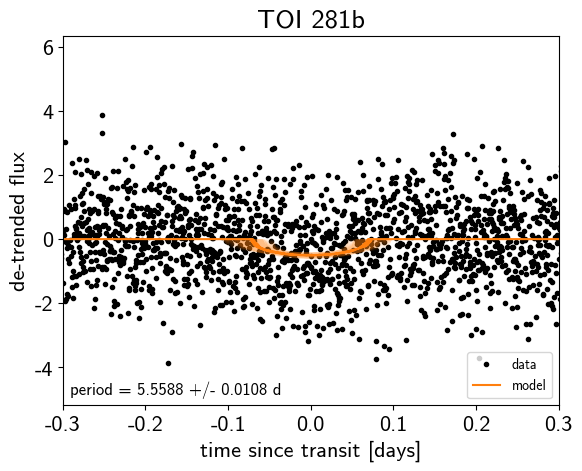

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

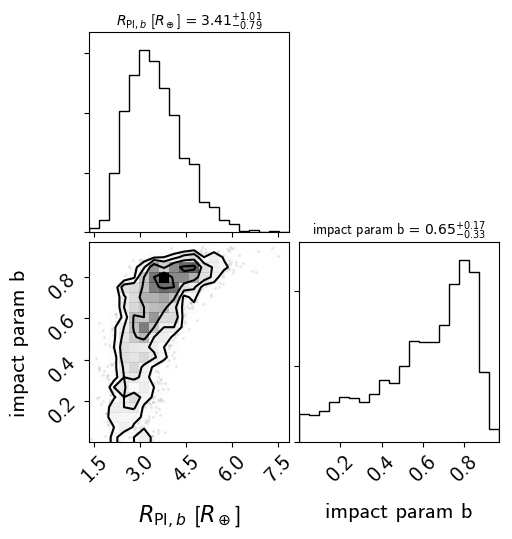

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

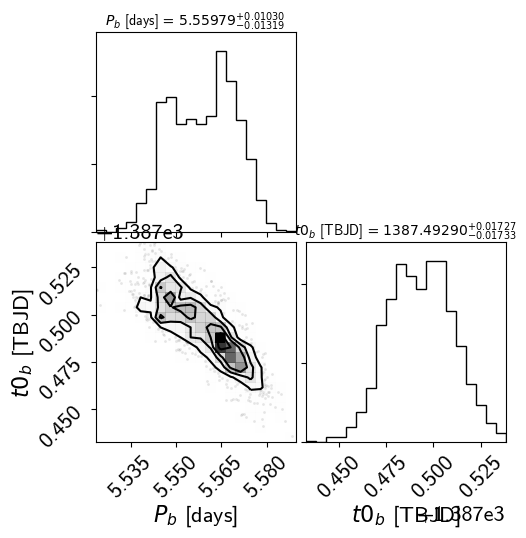

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

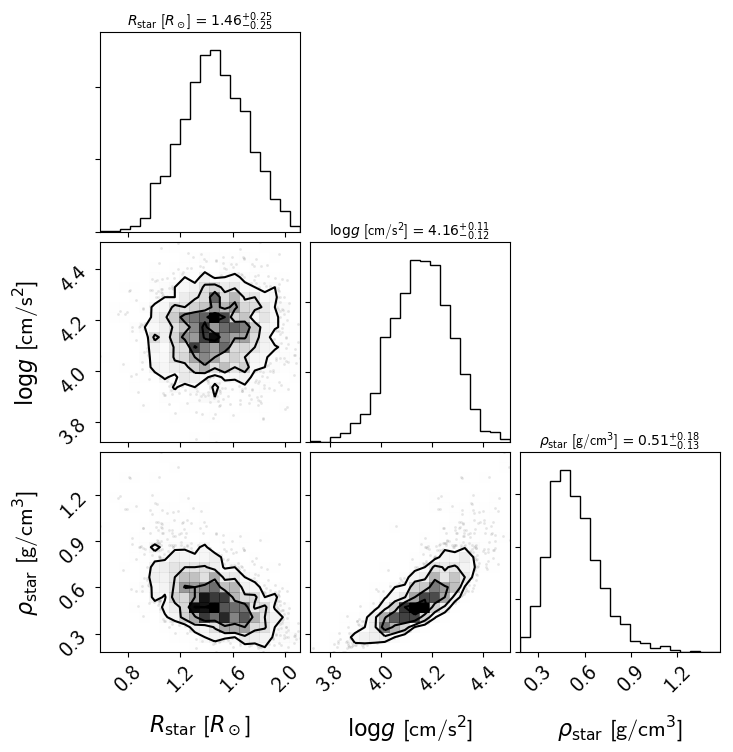

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3